# **Intelligent Stock Price Prediction Using Multi-Algorithm Modeling**


📌 **Problem Statement**

Financial markets are highly dynamic and influenced by complex, non-linear patterns that make stock price prediction extremely challenging. Investors and analysts often rely on manual analysis or single-model approaches, which fail to capture hidden temporal dependencies.
This project aims to build a robust stock price forecasting system that experiments with multiple Machine Learning and Deep Learning algorithms to identify the most accurate model for predicting future stock prices (e.g., Tesla).


📌 **Challenges Addressed**

High volatility → Stock prices fluctuate unpredictably due to market sentiment, news, and global events.

Non-linear patterns → Traditional linear models struggle to capture complex market relationships.

Temporal dependencies → Past price movements influence future trends, requiring sequence-aware models.

Feature scaling & noise → Raw stock data contains noise, missing values, and large variations between features.

Model comparison difficulty → Hard to identify which ML/DL algorithm performs best without systematic evaluation.

📌 **Project Description**

This notebook builds a complete workflow for end-to-end stock prediction, starting from data loading and exploratory analysis to model development and performance comparison.
It experiments with multiple models—SVR, Random Forest, KNN, and LSTM—after applying preprocessing techniques like feature scaling and engineered lag features.
Evaluation metrics and visualizations help interpret how each model learns price patterns and which one generalizes best.

📌 **Our Solution**

We implement a multi-model forecasting pipeline that:

Loads and analyzes historical stock data

Creates engineered features and scales data

Trains several ML algorithms and an LSTM neural network

Evaluates them using MSE, RMSE, MAE, and visualization

Identifies the best-performing model for future price prediction

This approach ensures a data-driven, comparative, and more reliable method for forecasting stock trends, especially where temporal behavior plays a major role.

In [ ]:
# ==============================================================================
# Importing Essential Libraries and Data Setup
# ==============================================================================
import os
import time
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

In [ ]:
datasets = {
    "Apple": "/content/apple_stock.csv",
    "Microsoft": "/content/MSFT_1986-03-13_2025-02-04.csv",
    "Tesla": "/content/TSLA_2010-06-29_2025-02-13.csv",
    "Exxon": "/content/XOM_1962-01-01_2025-08-12.csv",
    "Google": "/content/GOOG_2004-08-19_2025-08-20.csv",
    "Samsung": "/content/005930.KS_2000-01-01_2025-08-17.csv",
    "Visa": "/content/V_2008-03-19_2025-08-15.csv",
    "Walmart": "/content/WMT_1972-08-25_2025-08-15.csv"
}
# Dictionary to store cleaned/engineered dataframes
stocks_fe = {}

📌 **Feature Engineering Summary**

To enhance predictive power across all stock datasets, multiple feature engineering steps were applied.
Each dataset was cleaned, standardized, and enriched with technical indicators to capture market behavior and price patterns.
This process transforms raw OHLCV data into a more informative, model-ready format for machine learning.

In [ ]:
import pandas as pd
import numpy as np

# Final dictionary to store processed datasets
stocks_fe = {}

# ============================
# FEATURE ENGINEERING FUNCTION
# ============================

def feature_engineer(df, name):
    print(f"\n\n======================= {name} (Before) =======================")
    print(df.head())

    # ------------------------------------------
    # 1️⃣ FIX DATE COLUMN
    # ------------------------------------------
    date_col = None
    for col in df.columns:
        if "date" in col.lower() or "unnamed" in col.lower():
            date_col = col
            break

    df.rename(columns={date_col: "date"}, inplace=True)

    # Remove header-like junk rows
    df = df[df['date'].astype(str).str.contains(r"\d{4}-\d{2}-\d{2}", na=False)]

    # Convert to datetime
    df["date"] = pd.to_datetime(df["date"])

    # ------------------------------------------
    # 2️⃣ FIX NUMERIC COLUMNS
    # ------------------------------------------
    df = df.replace({"XOM": np.nan, "GOOG": np.nan, "V": np.nan, "WMT": np.nan, "005930.KS": np.nan})

    # Standardize column names
    df.rename(columns={
        "Open": "open", "High": "high", "Low": "low",
        "Close": "close", "Adj Close": "adj_close",
        "Volume": "volume", "adj_close": "adj_close"
    }, inplace=True)

    # Convert numeric
    for col in ["open", "high", "low", "close", "adj_close", "volume"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Fill missing forward/backward
    df.fillna(method="ffill", inplace=True)
    df.fillna(method="bfill", inplace=True)

    df.sort_values("date", inplace=True)
    df.set_index("date", inplace=True)

    # ------------------------------------------
    # 3️⃣ FEATURE ENGINEERING
    # ------------------------------------------

    # Daily return
    df["daily_return"] = df["close"].pct_change()

    # Price range
    df["price_range"] = df["high"] - df["low"]

    # Open-close difference
    df["open_close_diff"] = df["open"] - df["close"]

    # Lags
    df["lag_1"] = df["close"].shift(1)
    df["lag_5"] = df["close"].shift(5)
    df["lag_10"] = df["close"].shift(10)

    # Moving averages
    df["ma_5"] = df["close"].rolling(5).mean()
    df["ma_20"] = df["close"].rolling(20).mean()

    # Volatility
    df["volatility_10"] = df["daily_return"].rolling(10).std()

    # EMA indicators
    df["ema_12"] = df["close"].ewm(span=12, adjust=False).mean()
    df["ema_26"] = df["close"].ewm(span=26, adjust=False).mean()

    # MACD
    df["macd"] = df["ema_12"] - df["ema_26"]

    # RSI
    delta = df["close"].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    RS = avg_gain / avg_loss
    df["rsi"] = 100 - (100 / (1 + RS))

    # Normalized close
    df["close_norm"] = (df["close"] - df["close"].min()) / (df["close"].max() - df["close"].min())

    # Target variable
    df["target_close_tomorrow"] = df["close"].shift(-1)

    df.dropna(inplace=True)

    # ------------------------------------------
    # SHOW OUTPUT ONLY
    # ------------------------------------------
    print(f"\n======================= {name} (After Feature Engineering) =======================")
    print(df.head())
    print("\nTotal Columns:", len(df.columns))
    print("=====================================================================")

    return df


# ============================
# PROCESS ALL DATASETS
# ============================

for name, path in datasets.items():
    df = pd.read_csv(path)
    processed_df = feature_engineer(df, name)
    stocks_fe[name] = processed_df




======================= Apple (Before) =======================
   Unnamed: 0  Adj Close     Close      High       Low      Open     Volume
0  1980-12-12   0.098834  0.128348  0.128906  0.128348  0.128348  469033600
1  1980-12-15   0.093678  0.121652  0.122210  0.121652  0.122210  175884800
2  1980-12-16   0.086802  0.112723  0.113281  0.112723  0.113281  105728000
3  1980-12-17   0.088951  0.115513  0.116071  0.115513  0.115513   86441600
4  1980-12-18   0.091530  0.118862  0.119420  0.118862  0.118862   73449600

======================= Apple (After Feature Engineering) =======================
            adj_close     close      high       low      open    volume  \
date                                                                      
1981-01-12   0.108718  0.141183  0.142299  0.141183  0.142299  23699200   
1981-01-13   0.104851  0.136161  0.136719  0.136161  0.136719  23049600   
1981-01-14   0.105281  0.136719  0.137277  0.136719  0.136719  14291200   
1981-01-15   0.107429

# **Comparison Google VS Microsoft**

In [ ]:
google = pd.read_csv('/content/GOOG_2004-08-19_2025-08-20.csv')
google.shape

(5285, 7)

In [ ]:
microsoft=pd.read_csv('/content/MSFT_1986-03-13_2025-02-04.csv')
microsoft.shape

(9800, 7)

In [ ]:
# Replicate the Feature Engineering Function from the original notebook (snippet_6)
def feature_engineer(df, name):
    # 1. Fix Date Column
    date_col = None
    for col in df.columns:
        if "date" in col.lower() or "unnamed" in col.lower():
            date_col = col
            break
    if date_col is None:
        return pd.DataFrame()

    df.rename(columns={date_col: "date"}, inplace=True)
    df = df[df['date'].astype(str).str.contains(r"\d{4}-\d{2}-\d{2}", na=False)]
    df["date"] = pd.to_datetime(df["date"])

    # 2. Fix Numeric Columns
    df = df.replace({"XOM": np.nan, "GOOG": np.nan, "V": np.nan, "WMT": np.nan, "005930.KS": np.nan})
    df.rename(columns={
        "Open": "open", "High": "high", "Low": "low",
        "Close": "close", "Adj Close": "adj_close",
        "Volume": "volume", "adj_close": "adj_close"
    }, inplace=True)

    numeric_cols = ["open", "high", "low", "close", "adj_close", "volume"]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    df.fillna(method="ffill", inplace=True)
    df.fillna(method="bfill", inplace=True)

    df.sort_values("date", inplace=True)
    df.set_index("date", inplace=True)

    # 3. Feature Engineering
    df["daily_return"] = df["close"].pct_change()
    df["price_range"] = df["high"] - df["low"]
    df["open_close_diff"] = df["open"] - df["close"]

    # Lags
    df["lag_1"] = df["close"].shift(1)
    df["lag_5"] = df["close"].shift(5)
    df["lag_10"] = df["close"].shift(10)

    # Moving averages
    df["ma_5"] = df["close"].rolling(5).mean()
    df["ma_20"] = df["close"].rolling(20).mean()

    # Volatility
    df["volatility_10"] = df["daily_return"].rolling(10).std()

    # EMA indicators
    df["ema_12"] = df["close"].ewm(span=12, adjust=False).mean()
    df["ema_26"] = df["close"].ewm(span=26, adjust=False).mean()
    df["macd"] = df["ema_12"] - df["ema_26"]

    # RSI
    delta = df["close"].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    RS = avg_gain / avg_loss
    df["rsi"] = 100 - (100 / (1 + RS))

    # Normalized close
    df["close_norm"] = (df["close"] - df["close"].min()) / (df["close"].max() - df["close"].min())

    # Targets
    df["target_close_tomorrow"] = df["close"].shift(-1)
    df['price_up'] = (df['close'].shift(-1) > df['close']).astype(int)

    df.dropna(inplace=True)

    # ⭐ NEW: Print all engineered features ⭐
    print(f"\nFeatures added for {name}:")
    engineered_features = [
        "daily_return", "price_range", "open_close_diff",
        "lag_1", "lag_5", "lag_10",
        "ma_5", "ma_20",
        "volatility_10",
        "ema_12", "ema_26", "macd",
        "rsi", "close_norm",
        "target_close_tomorrow", "price_up"
    ]
    print(engineered_features)

    return df


# Process all datasets
for name, path in datasets.items():
    df = pd.read_csv(path)
    processed_df = feature_engineer(df, name)
    if not processed_df.empty:
        stocks_fe[name] = processed_df

print("\nAll datasets processed and features engineered.")



Features added for Apple:
['daily_return', 'price_range', 'open_close_diff', 'lag_1', 'lag_5', 'lag_10', 'ma_5', 'ma_20', 'volatility_10', 'ema_12', 'ema_26', 'macd', 'rsi', 'close_norm', 'target_close_tomorrow', 'price_up']

Features added for Microsoft:
['daily_return', 'price_range', 'open_close_diff', 'lag_1', 'lag_5', 'lag_10', 'ma_5', 'ma_20', 'volatility_10', 'ema_12', 'ema_26', 'macd', 'rsi', 'close_norm', 'target_close_tomorrow', 'price_up']

Features added for Tesla:
['daily_return', 'price_range', 'open_close_diff', 'lag_1', 'lag_5', 'lag_10', 'ma_5', 'ma_20', 'volatility_10', 'ema_12', 'ema_26', 'macd', 'rsi', 'close_norm', 'target_close_tomorrow', 'price_up']

Features added for Exxon:
['daily_return', 'price_range', 'open_close_diff', 'lag_1', 'lag_5', 'lag_10', 'ma_5', 'ma_20', 'volatility_10', 'ema_12', 'ema_26', 'macd', 'rsi', 'close_norm', 'target_close_tomorrow', 'price_up']

Features added for Google:
['daily_return', 'price_range', 'open_close_diff', 'lag_1', 'lag

In [ ]:
def calculate_metrics_regression(y_test, y_pred, model_name):
    """Calculates regression metrics (MAE, MSE, R2)."""

    # Compute metrics
    metrics = {
        "Model": model_name,
        "MSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred),
    }

    # ⭐ NEW: PRINT METRICS CLEARLY ⭐
    print("\n==============================")
    print(f" Regression Metrics for: {model_name}")
    print("==============================")
    print(f"Mean Squared Error (MSE): {metrics['MSE']}")
    print(f"Mean Absolute Error (MAE): {metrics['MAE']}")
    print(f"R2 Score: {metrics['R2']}")
    print("==============================\n")

    return metrics


In [ ]:
# Core Features for Regression/Classification
REGRESSION_FEATURES = ['open', 'high', 'low', 'volume', 'lag_1', 'ma_5', 'rsi', 'macd']
CLASSIFICATION_FEATURES = ['open', 'high', 'low', 'volume', 'lag_1', 'ma_5', 'rsi', 'macd']

# ⭐ NEW: PRINT FEATURES ⭐
print("\n==============================")
print("Regression Features Used:")
print(REGRESSION_FEATURES)
print("\nClassification Features Used:")
print(CLASSIFICATION_FEATURES)
print("==============================\n")



Regression Features Used:
['open', 'high', 'low', 'volume', 'lag_1', 'ma_5', 'rsi', 'macd']

Classification Features Used:
['open', 'high', 'low', 'volume', 'lag_1', 'ma_5', 'rsi', 'macd']



In [ ]:
def plot_predictions(df, company, model_name, y_test, y_pred):
    """Plots actual vs. predicted values for a given company and model."""

    print(f"\nPlotting predictions for {company} using {model_name}...\n")

    plt.figure(figsize=(12, 6))

    test_index = df.index[-len(y_test):]
    plot_df = pd.DataFrame({'Actual Price': y_test, 'Predicted Price': y_pred}, index=test_index)
    plot_df.sort_index(inplace=True)

    plt.plot(plot_df.index, plot_df['Actual Price'], label="Actual Price", linewidth=2)
    plt.plot(plot_df.index, plot_df['Predicted Price'], label="Predicted Price", linestyle='--', linewidth=2)

    plt.title(f"{company} - {model_name} Price Prediction (Test Set)")
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
all_regression_metrics = []


In [ ]:
# Store predictions for combined plot
combined_predictions = {}
combined_actuals = {}
last_dates = {}
trained_models = {}
scalers = {}



## 1. Linear Regression Analysis
---------------------------------------

 Regression Metrics for: Linear Regression
Mean Squared Error (MSE): 4.696599921635978
Mean Absolute Error (MAE): 1.4109172742723746
R2 Score: 0.9988683953215237


--- Apple - Linear Regression ---
MAE: 1.4109, MSE: 4.6966, R2: 0.9989

Plotting predictions for Apple using Linear Regression...



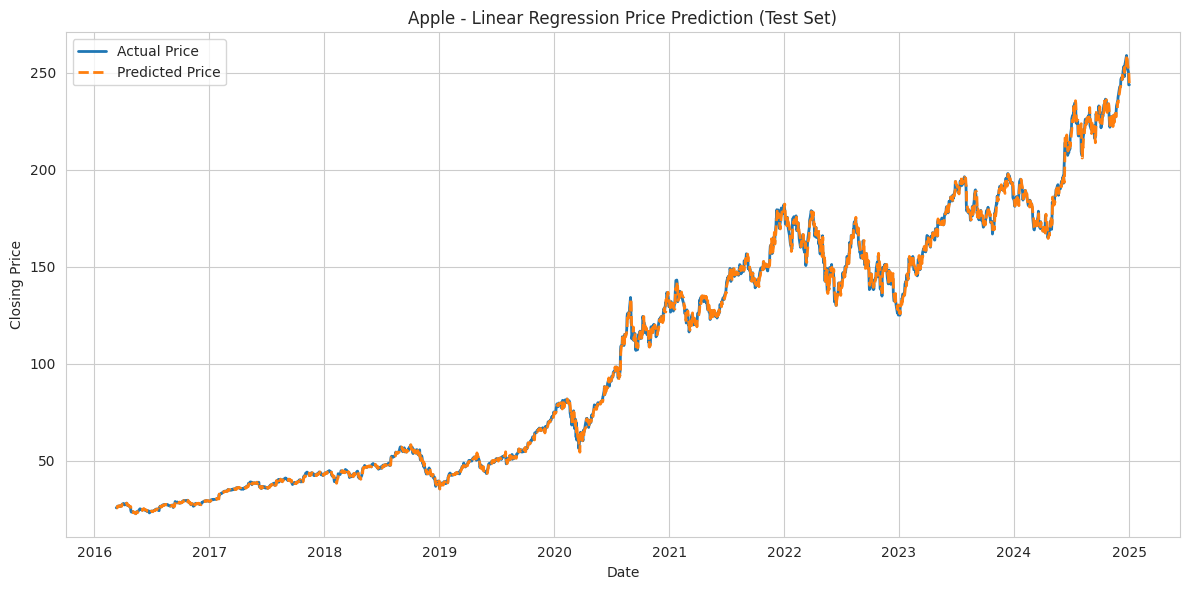


 Regression Metrics for: Linear Regression
Mean Squared Error (MSE): 18.152746802413674
Mean Absolute Error (MAE): 2.895112811113446
R2 Score: 0.9985810004869253


--- Microsoft - Linear Regression ---
MAE: 2.8951, MSE: 18.1527, R2: 0.9986

Plotting predictions for Microsoft using Linear Regression...



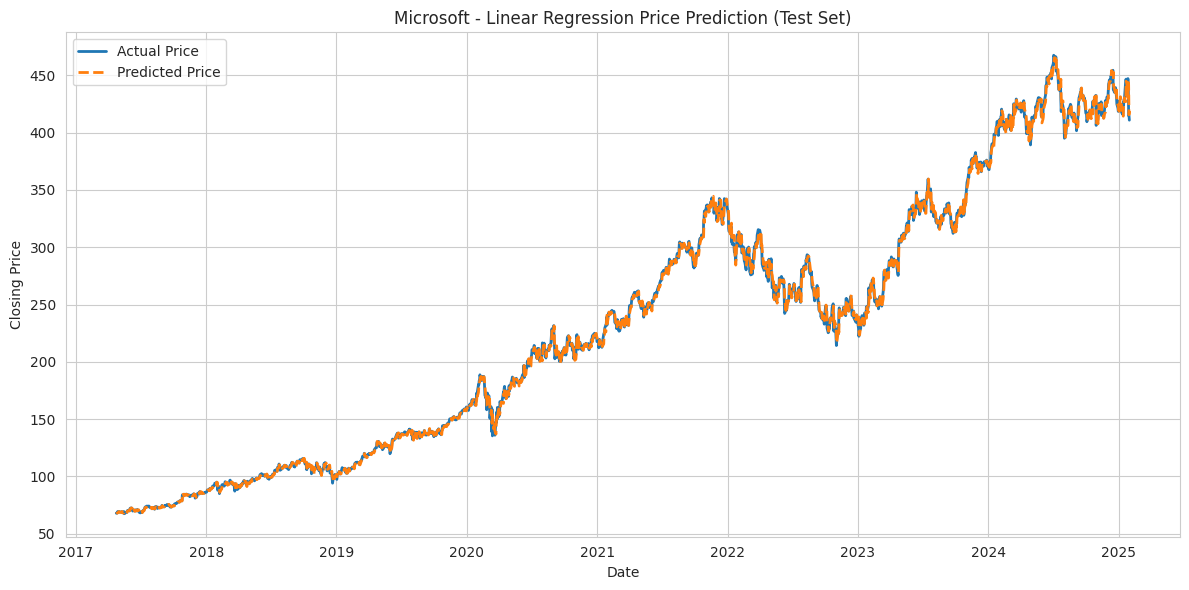


 Regression Metrics for: Linear Regression
Mean Squared Error (MSE): 97.34299921085304
Mean Absolute Error (MAE): 7.221939915439115
R2 Score: 0.9778199258639637


--- Tesla - Linear Regression ---
MAE: 7.2219, MSE: 97.3430, R2: 0.9778

Plotting predictions for Tesla using Linear Regression...



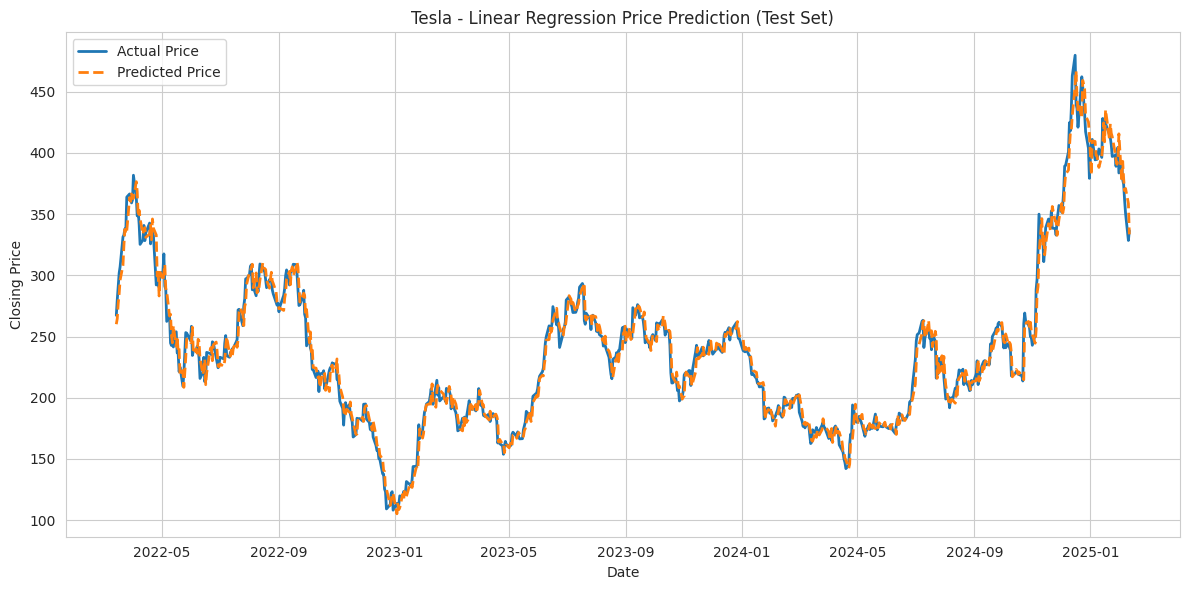


 Regression Metrics for: Linear Regression
Mean Squared Error (MSE): 1.8100225475634562
Mean Absolute Error (MAE): 0.9670370628546987
R2 Score: 0.9953423891403288


--- Exxon - Linear Regression ---
MAE: 0.9670, MSE: 1.8100, R2: 0.9953

Plotting predictions for Exxon using Linear Regression...



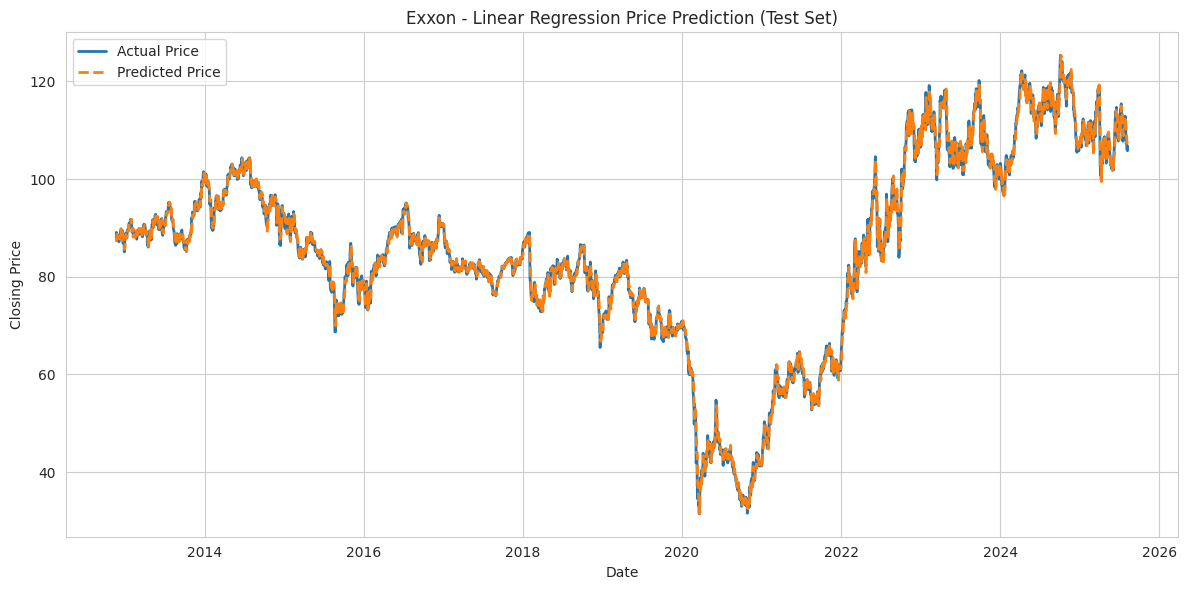


 Regression Metrics for: Linear Regression
Mean Squared Error (MSE): 8.172843561954641
Mean Absolute Error (MAE): 2.0949215481494274
R2 Score: 0.9902069367325855


--- Google - Linear Regression ---
MAE: 2.0949, MSE: 8.1728, R2: 0.9902

Plotting predictions for Google using Linear Regression...



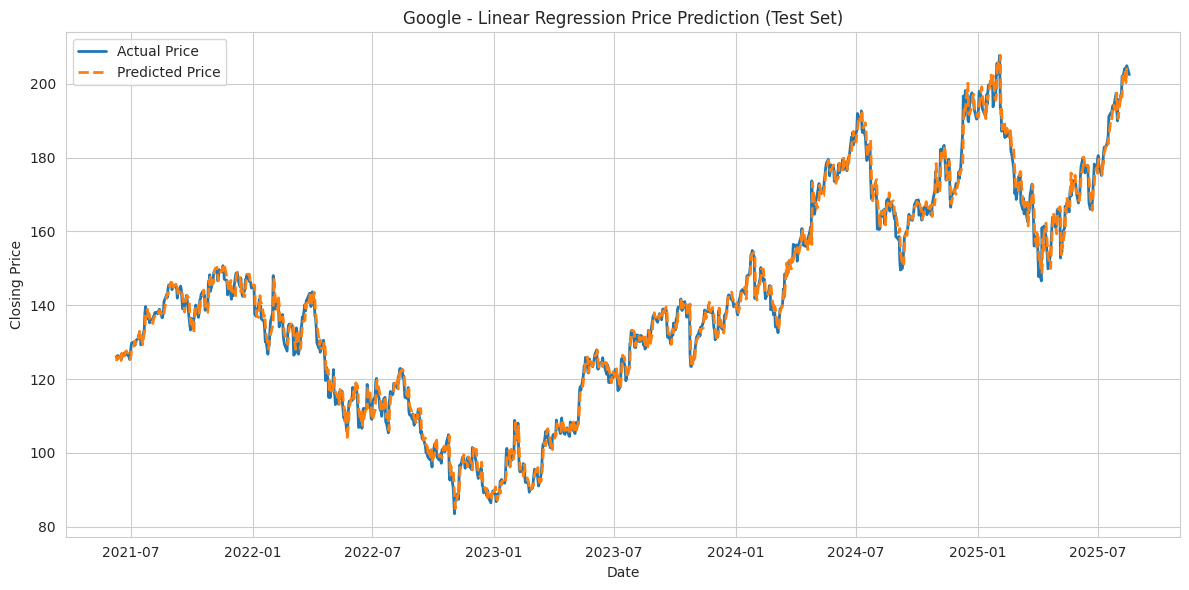


 Regression Metrics for: Linear Regression
Mean Squared Error (MSE): 1348639.6264694433
Mean Absolute Error (MAE): 851.2823318016896
R2 Score: 0.9854200795899931


--- Samsung - Linear Regression ---
MAE: 851.2823, MSE: 1348639.6265, R2: 0.9854

Plotting predictions for Samsung using Linear Regression...



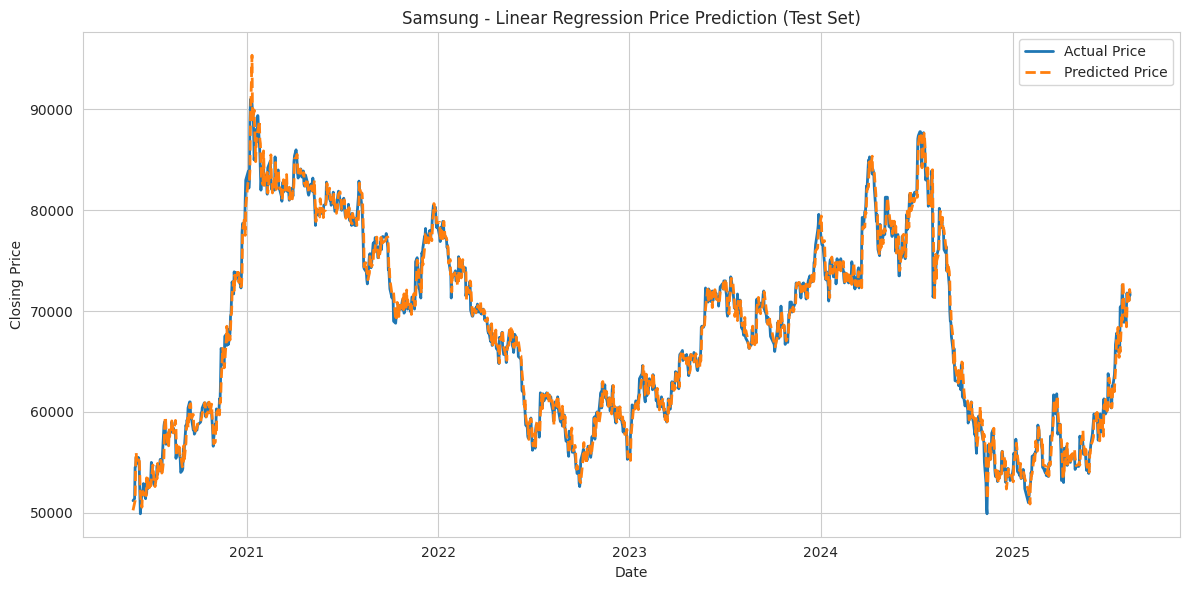


 Regression Metrics for: Linear Regression
Mean Squared Error (MSE): 13.81757547049312
Mean Absolute Error (MAE): 2.627599644946108
R2 Score: 0.9944639069714655


--- Visa - Linear Regression ---
MAE: 2.6276, MSE: 13.8176, R2: 0.9945

Plotting predictions for Visa using Linear Regression...



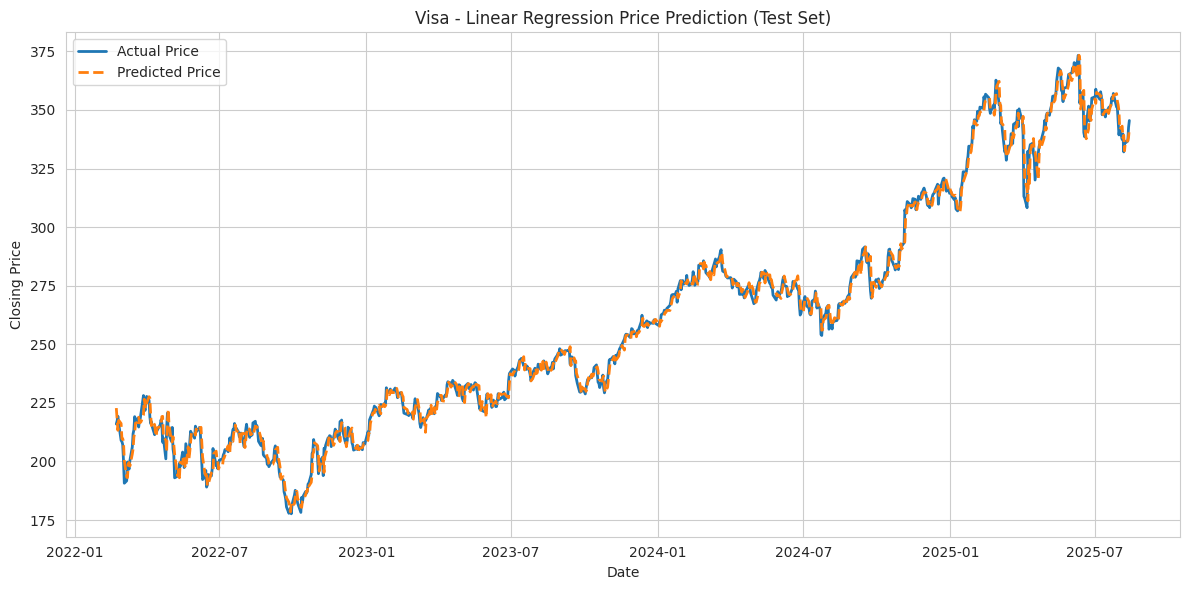


 Regression Metrics for: Linear Regression
Mean Squared Error (MSE): 0.47419895827715836
Mean Absolute Error (MAE): 0.4228305225022084
R2 Score: 0.9987312284185089


--- Walmart - Linear Regression ---
MAE: 0.4228, MSE: 0.4742, R2: 0.9987

Plotting predictions for Walmart using Linear Regression...



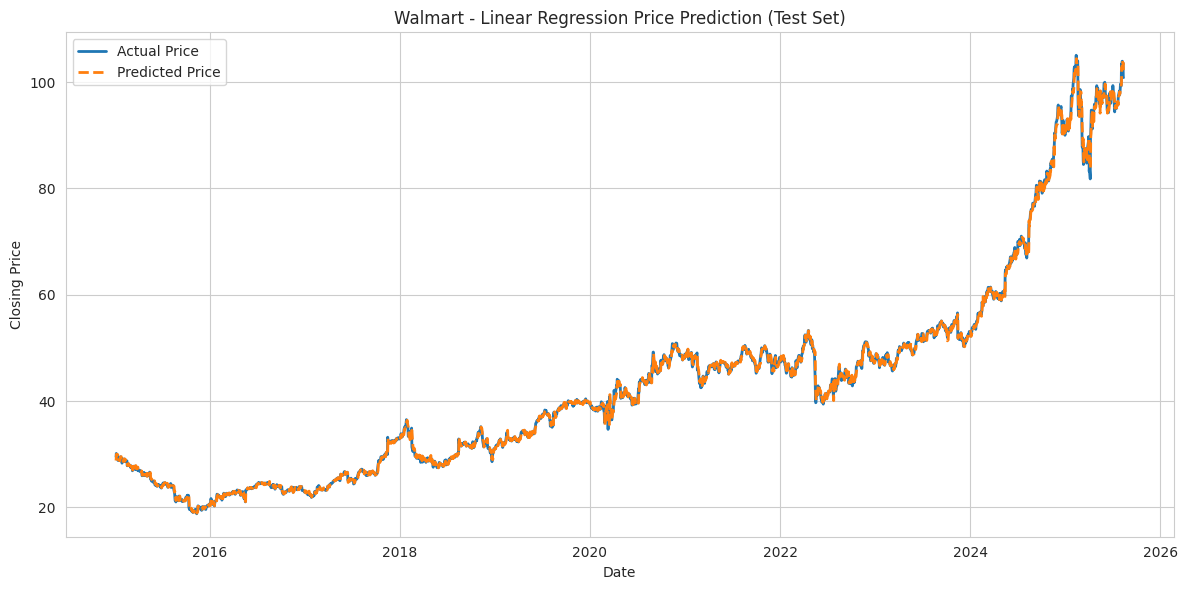

In [ ]:
print("\n## 1. Linear Regression Analysis")
print("---------------------------------------")

for name, df in stocks_fe.items():
    if len(df) < 21:
        print(f"Skipping {name}: Insufficient data.")
        continue

    # Prepare data
    X = df[REGRESSION_FEATURES]
    y = df['target_close_tomorrow']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled_df, y, test_size=0.2, shuffle=False
    )

    # Train Model
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Save
    combined_predictions[name] = y_pred
    combined_actuals[name] = y_test
    last_dates[name] = df.index[-1]
    trained_models[name] = model
    scalers[name] = scaler

    # Metrics
    metrics = calculate_metrics_regression(y_test, y_pred, "Linear Regression")
    metrics['Company'] = name
    all_regression_metrics.append(metrics)

    print(f"\n--- {name} - Linear Regression ---")
    print(f"MAE: {metrics['MAE']:.4f}, MSE: {metrics['MSE']:.4f}, R2: {metrics['R2']:.4f}")

    plot_predictions(df, name, "Linear Regression", y_test, y_pred)


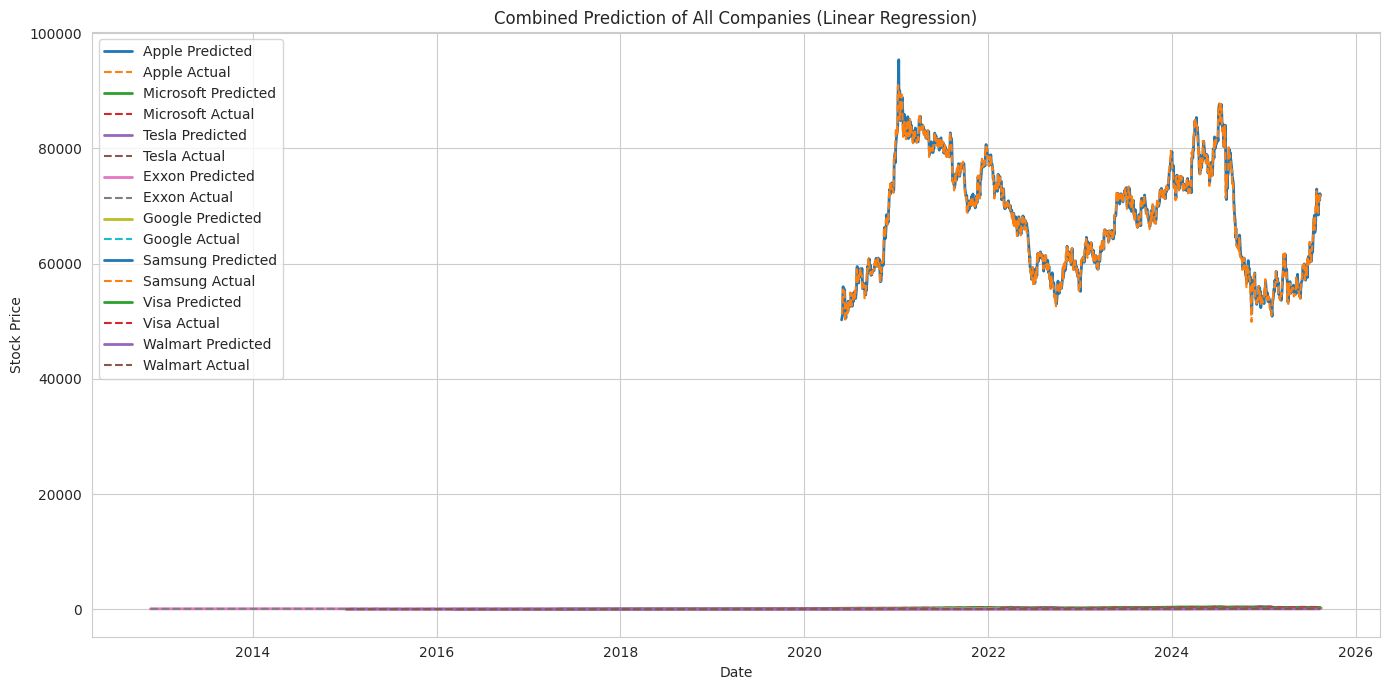

In [ ]:
plt.figure(figsize=(14, 7))

for company in combined_predictions:
    actual = combined_actuals[company]
    pred = combined_predictions[company]
    dates = actual.index

    plt.plot(dates, pred, label=f"{company} Predicted", linewidth=2)
    plt.plot(dates, actual, linestyle="--", label=f"{company} Actual")

plt.title("Combined Prediction of All Companies (Linear Regression)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



All Companies Available:
['Apple' 'Microsoft' 'Tesla' 'Exxon' 'Google' 'Samsung' 'Visa' 'Walmart']

📌 Plotting metrics WITH Samsung...


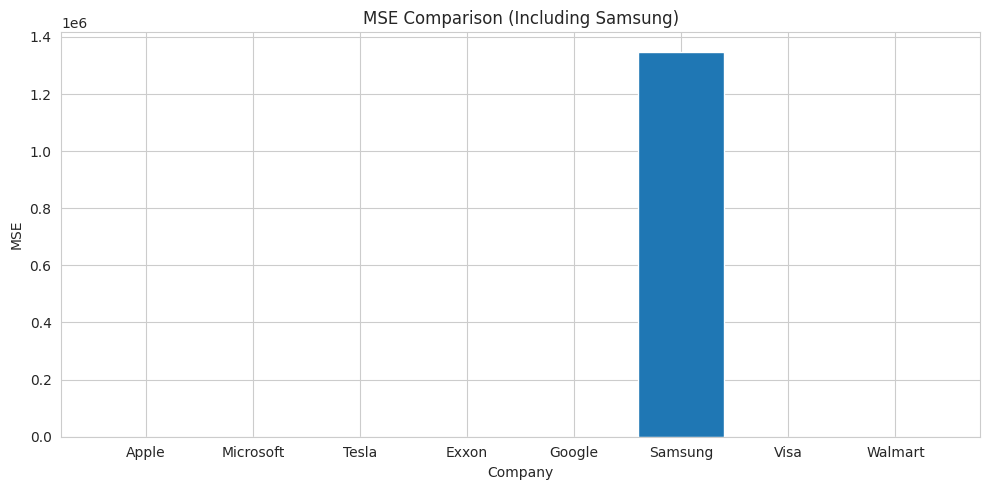

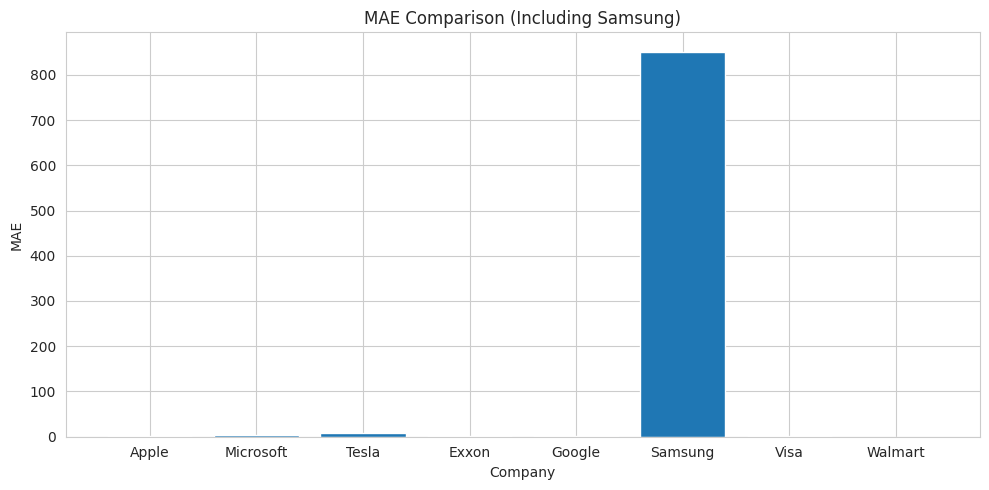

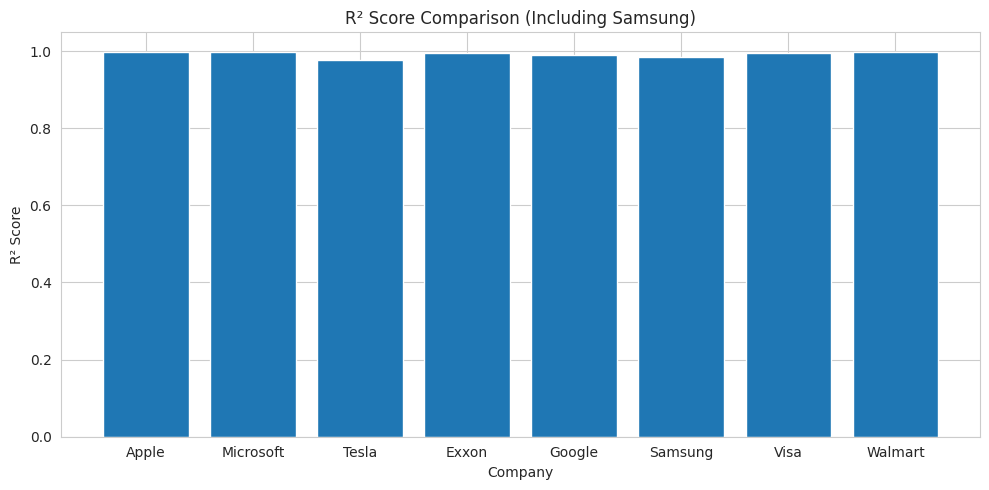


📌 Companies AFTER removing Samsung:
['Apple' 'Microsoft' 'Tesla' 'Exxon' 'Google' 'Visa' 'Walmart']


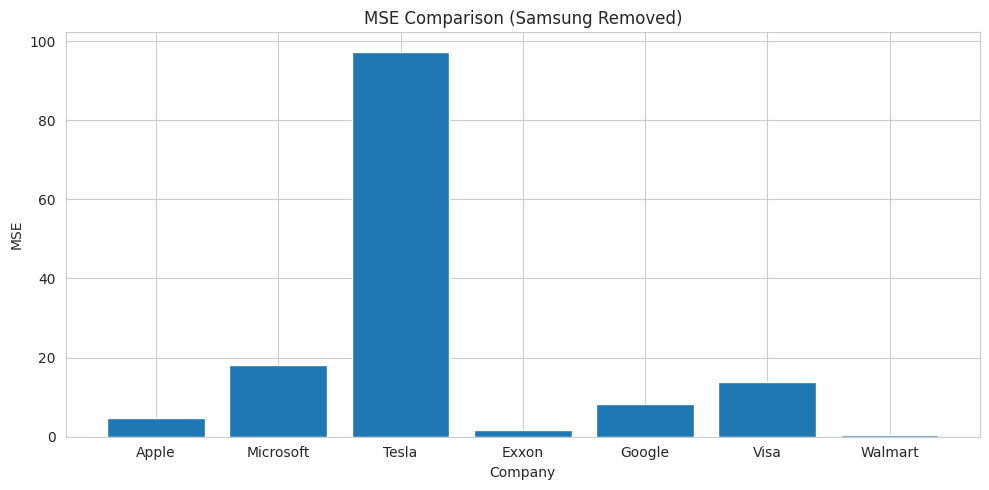

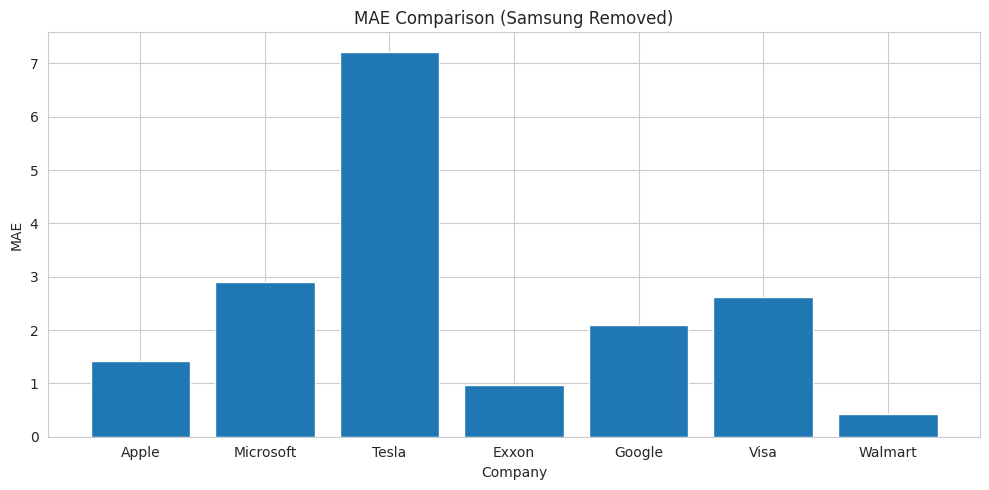

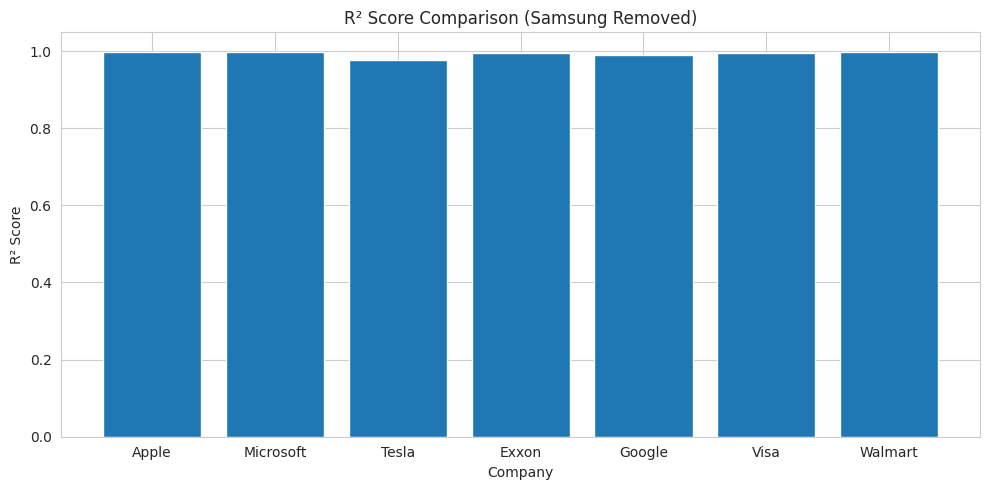

In [ ]:
# ==========================================================
#  CREATE METRICS DATAFRAME
# ==========================================================
metrics_df = pd.DataFrame(all_regression_metrics)

print("\nAll Companies Available:")
print(metrics_df["Company"].unique())

# ==========================================================
# 1️⃣  PLOTS WITH SAMSUNG INCLUDED
# ==========================================================
print("\n📌 Plotting metrics WITH Samsung...")

plt.figure(figsize=(10,5))
plt.bar(metrics_df["Company"], metrics_df["MSE"])
plt.title("MSE Comparison (Including Samsung)")
plt.xlabel("Company")
plt.ylabel("MSE")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.bar(metrics_df["Company"], metrics_df["MAE"])
plt.title("MAE Comparison (Including Samsung)")
plt.xlabel("Company")
plt.ylabel("MAE")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.bar(metrics_df["Company"], metrics_df["R2"])
plt.title("R² Score Comparison (Including Samsung)")
plt.xlabel("Company")
plt.ylabel("R² Score")
plt.tight_layout()
plt.show()



# ==========================================================
# 2️⃣  REMOVE SAMSUNG & RE-PLOT
# ==========================================================
metrics_no_samsung = metrics_df.copy()

metrics_no_samsung = metrics_no_samsung[
    ~metrics_no_samsung["Company"].str.contains("Samsung", case=False)
]
metrics_no_samsung = metrics_no_samsung[
    ~metrics_no_samsung["Company"].isin(["005930.KS", "samsung", "SAMSUNG"])
]

print("\n📌 Companies AFTER removing Samsung:")
print(metrics_no_samsung["Company"].unique())

# MSE
plt.figure(figsize=(10,5))
plt.bar(metrics_no_samsung["Company"], metrics_no_samsung["MSE"])
plt.title("MSE Comparison (Samsung Removed)")
plt.xlabel("Company")
plt.ylabel("MSE")
plt.tight_layout()
plt.show()

# MAE
plt.figure(figsize=(10,5))
plt.bar(metrics_no_samsung["Company"], metrics_no_samsung["MAE"])
plt.title("MAE Comparison (Samsung Removed)")
plt.xlabel("Company")
plt.ylabel("MAE")
plt.tight_layout()
plt.show()

# R2
plt.figure(figsize=(10,5))
plt.bar(metrics_no_samsung["Company"], metrics_no_samsung["R2"])
plt.title("R² Score Comparison (Samsung Removed)")
plt.xlabel("Company")
plt.ylabel("R² Score")
plt.tight_layout()
plt.show()


In [ ]:
future_predictions = {}

for company, df in stocks_fe.items():
    model = trained_models[company]
    scaler = scalers[company]

    # Start with the last known row
    last_row = df.iloc[-1].copy()
    last_5_closes = df['close'].tail(5).tolist()
    last_10_closes = df['close'].tail(10).tolist()

    future_df = []
    current_date = df.index[-1]
    end_date = pd.Timestamp("2030-12-31")

    while current_date < end_date:
        current_date += pd.Timedelta(days=1)

        # Skip weekends
        if current_date.weekday() >= 5:
            continue

        # Prepare input
        X_future = last_row[REGRESSION_FEATURES].values.reshape(1, -1)
        X_scaled = scaler.transform(X_future)
        next_close = model.predict(X_scaled)[0]

        # ---------------------------------------------------------
        # Update rolling windows
        # ---------------------------------------------------------
        last_5_closes.append(next_close)
        last_5_closes = last_5_closes[-5:]      # keep only last 5

        last_10_closes.append(next_close)
        last_10_closes = last_10_closes[-10:]    # keep last 10

        # ---------------------------------------------------------
        # Update feature values numerically (NO LISTS)
        # ---------------------------------------------------------
        last_row['lag_1'] = next_close
        last_row['lag_5'] = sum(last_5_closes) / len(last_5_closes)
        last_row['lag_10'] = sum(last_10_closes) / len(last_10_closes)

        last_row['ma_5'] = sum(last_5_closes) / 5

        # RSI & MACD left unchanged (kept same as last_row for simplicity)

        # Save prediction
        future_df.append({
            "date": current_date,
            "predicted_close": next_close
        })

    future_predictions[company] = pd.DataFrame(future_df).set_index("date")


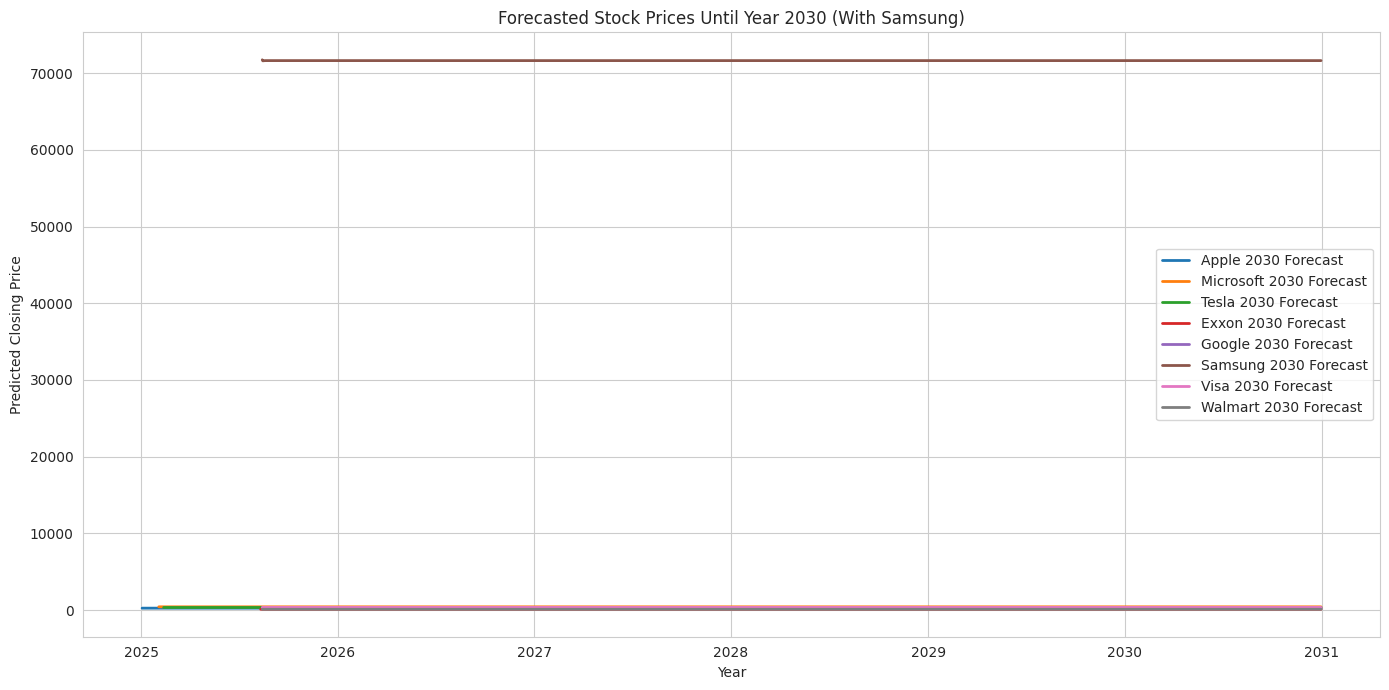

In [ ]:
# ================================
#  FUTURE FORECAST PLOT (WITH SAMSUNG)
# ================================
plt.figure(figsize=(14, 7))

for company, pred_df in future_predictions.items():
    plt.plot(
        pred_df.index,
        pred_df['predicted_close'],
        label=f"{company} 2030 Forecast",
        linewidth=2
    )

plt.title("Forecasted Stock Prices Until Year 2030 (With Samsung)")
plt.xlabel("Year")
plt.ylabel("Predicted Closing Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


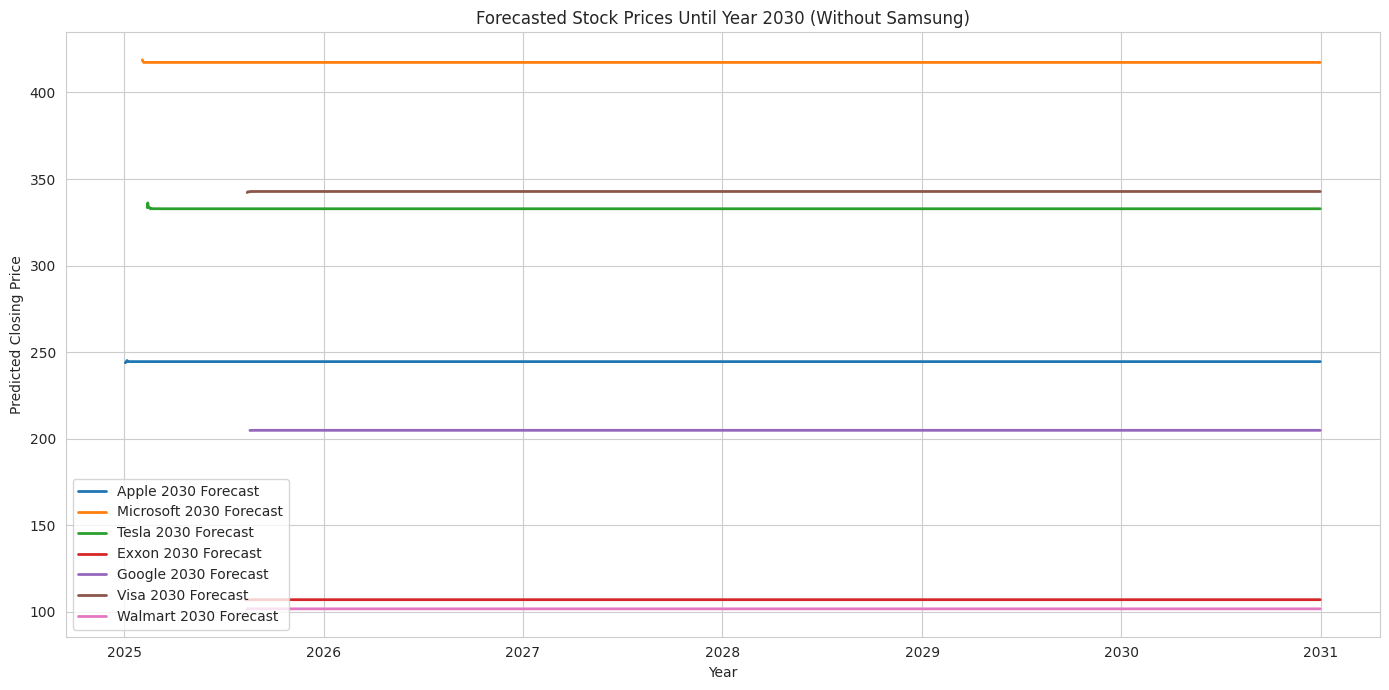

In [ ]:
# ======================================
#  FUTURE FORECAST PLOT (WITHOUT SAMSUNG)
# ======================================
plt.figure(figsize=(14, 7))

for company, pred_df in future_predictions.items():
    if company.lower() == "samsung":
        continue  # Skip Samsung

    plt.plot(
        pred_df.index,
        pred_df['predicted_close'],
        label=f"{company} 2030 Forecast",
        linewidth=2
    )

plt.title("Forecasted Stock Prices Until Year 2030 (Without Samsung)")
plt.xlabel("Year")
plt.ylabel("Predicted Closing Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## 2. Logistic Regression (Price Direction)
--------------------------------------------

--- Apple ---
Accuracy: 0.5234
              precision    recall  f1-score   support

           0       0.45      0.13      0.21      1028
           1       0.53      0.86      0.66      1190

    accuracy                           0.52      2218
   macro avg       0.49      0.50      0.43      2218
weighted avg       0.50      0.52      0.45      2218



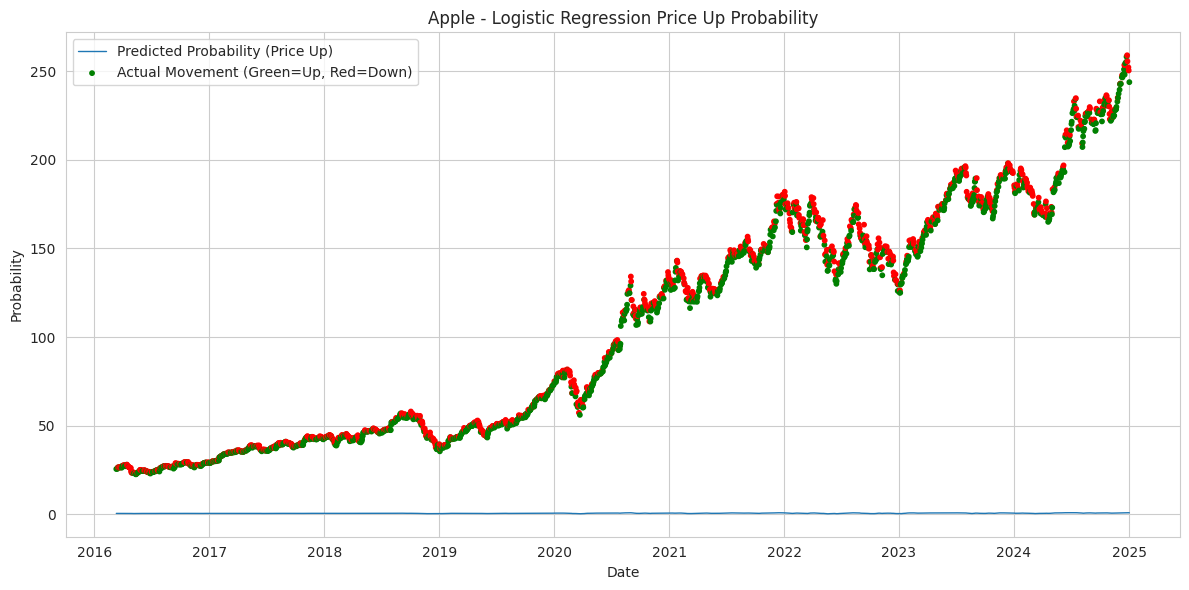

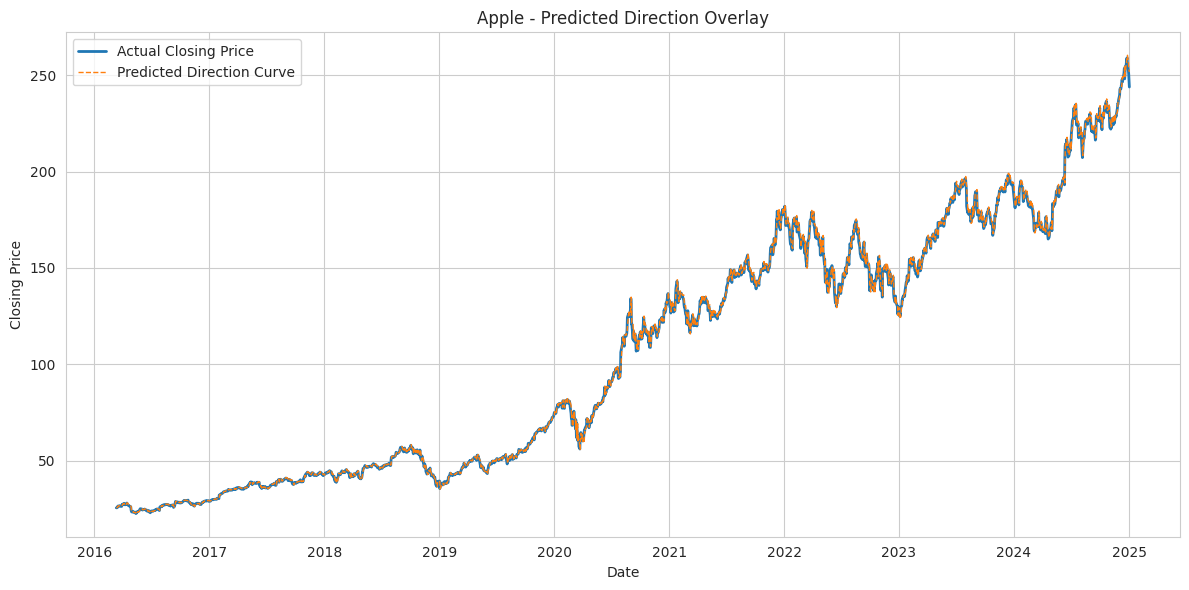


--- Microsoft ---
Accuracy: 0.4601
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       900
           1       0.50      0.00      0.00      1056

    accuracy                           0.46      1956
   macro avg       0.48      0.50      0.32      1956
weighted avg       0.48      0.46      0.29      1956



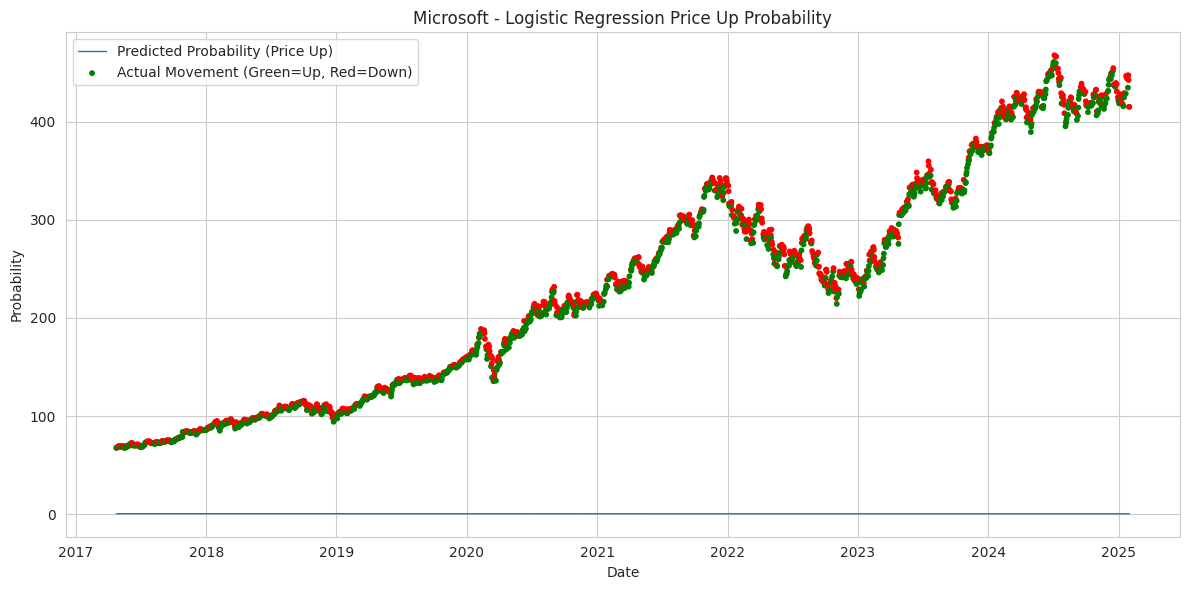

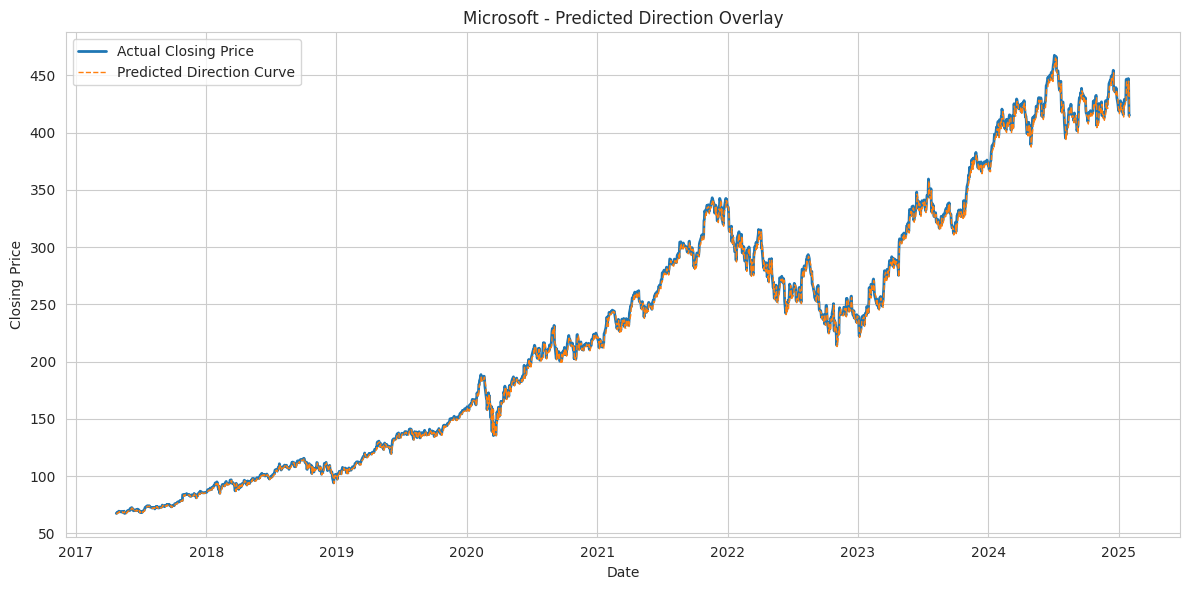


--- Tesla ---
Accuracy: 0.5000
              precision    recall  f1-score   support

           0       0.48      0.33      0.39       356
           1       0.51      0.66      0.58       376

    accuracy                           0.50       732
   macro avg       0.49      0.50      0.48       732
weighted avg       0.50      0.50      0.49       732



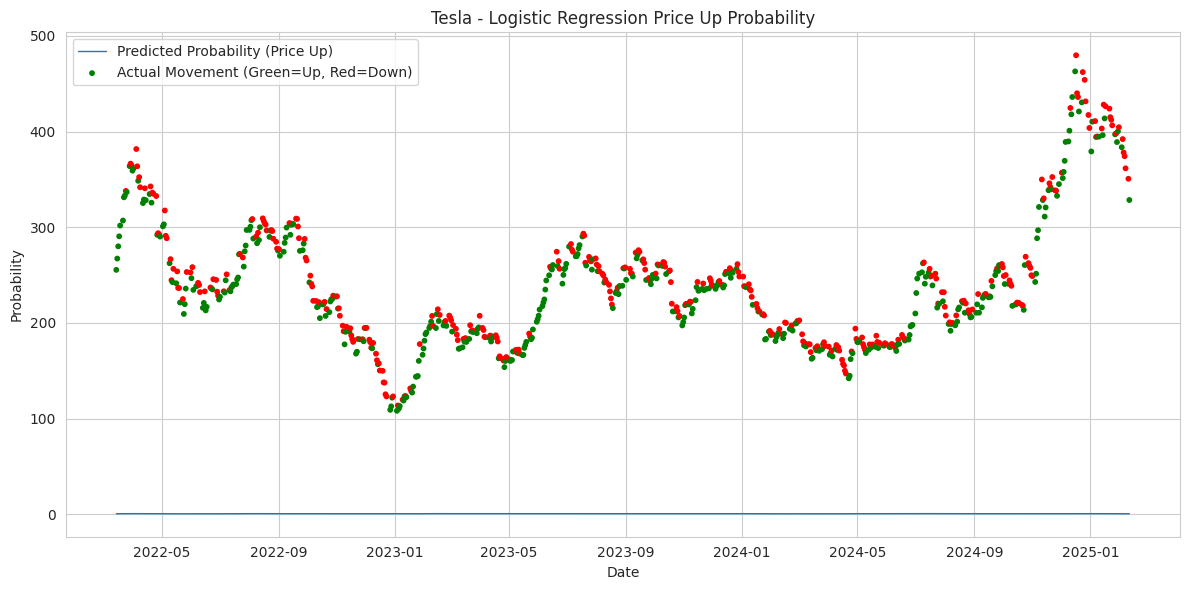

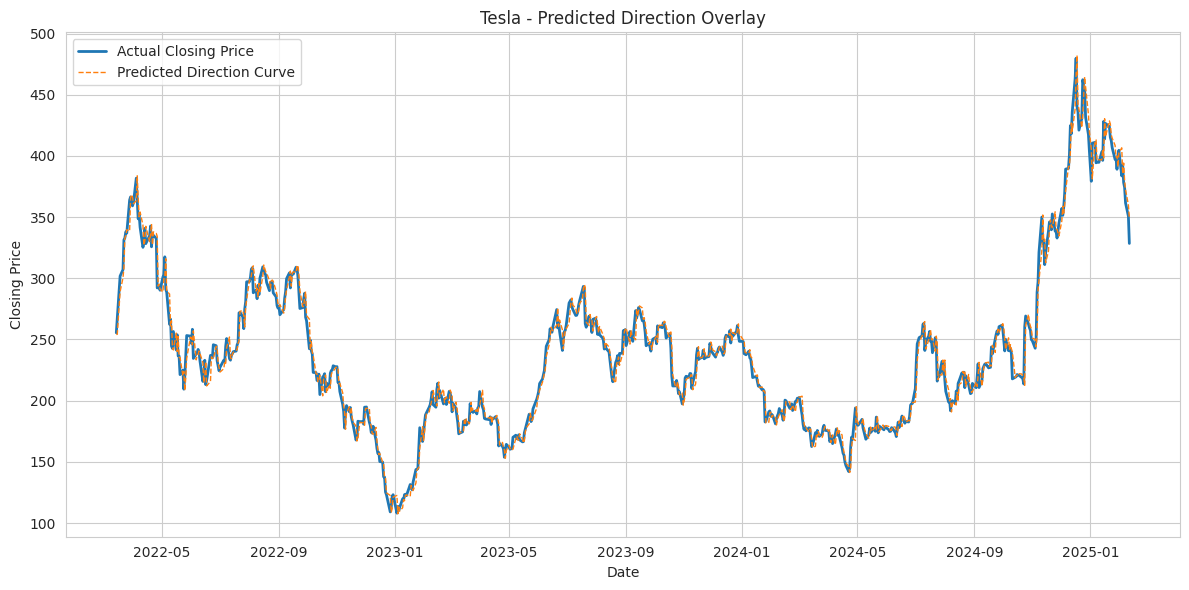


--- Exxon ---
Accuracy: 0.4931
              precision    recall  f1-score   support

           0       0.47      0.10      0.16      1604
           1       0.50      0.89      0.64      1594

    accuracy                           0.49      3198
   macro avg       0.48      0.49      0.40      3198
weighted avg       0.48      0.49      0.40      3198



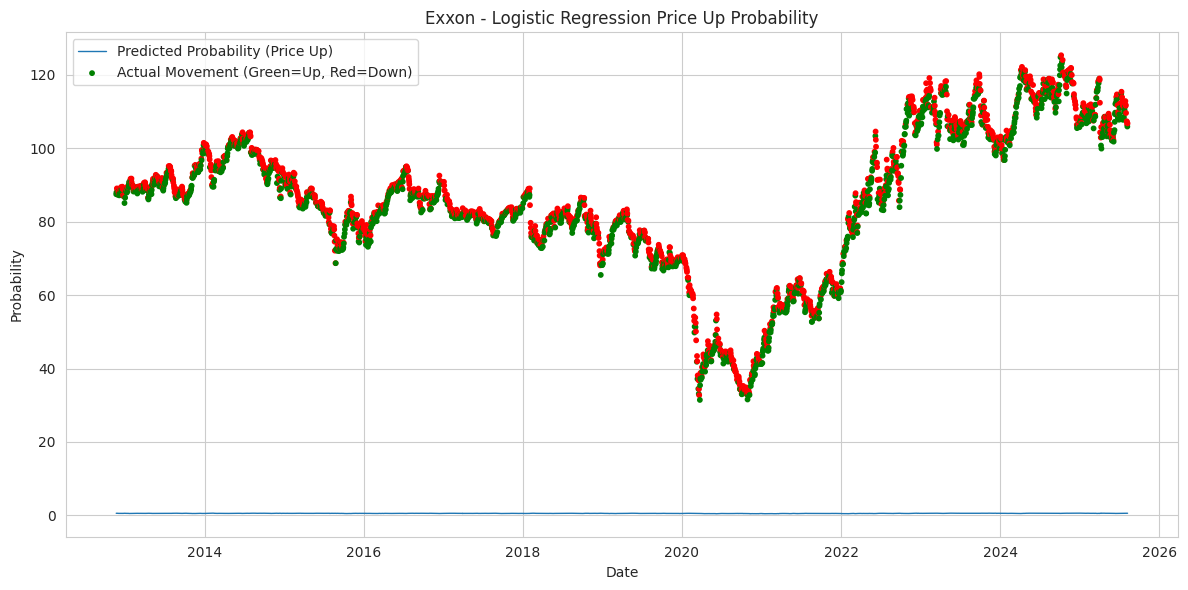

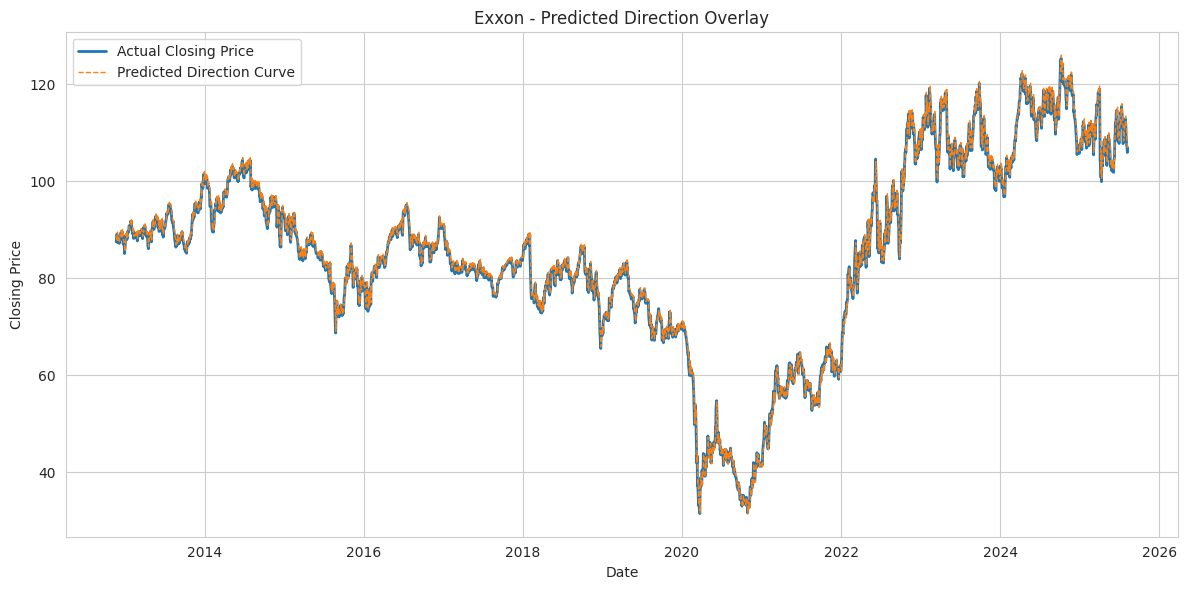


--- Google ---
Accuracy: 0.5366
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       488
           1       0.54      1.00      0.70       565

    accuracy                           0.54      1053
   macro avg       0.27      0.50      0.35      1053
weighted avg       0.29      0.54      0.37      1053



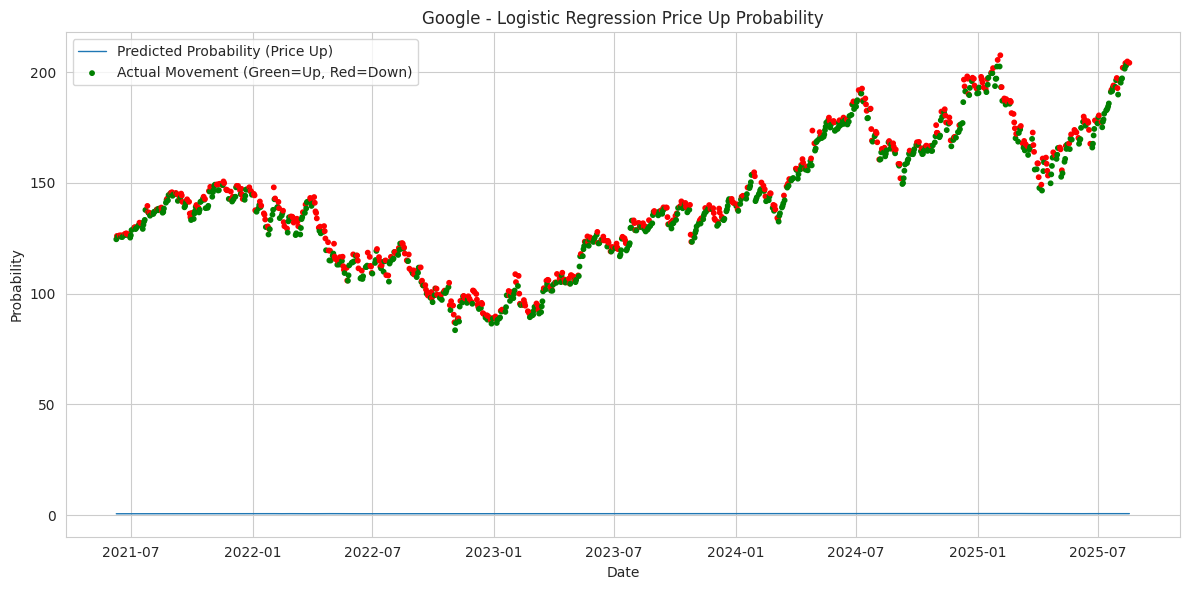

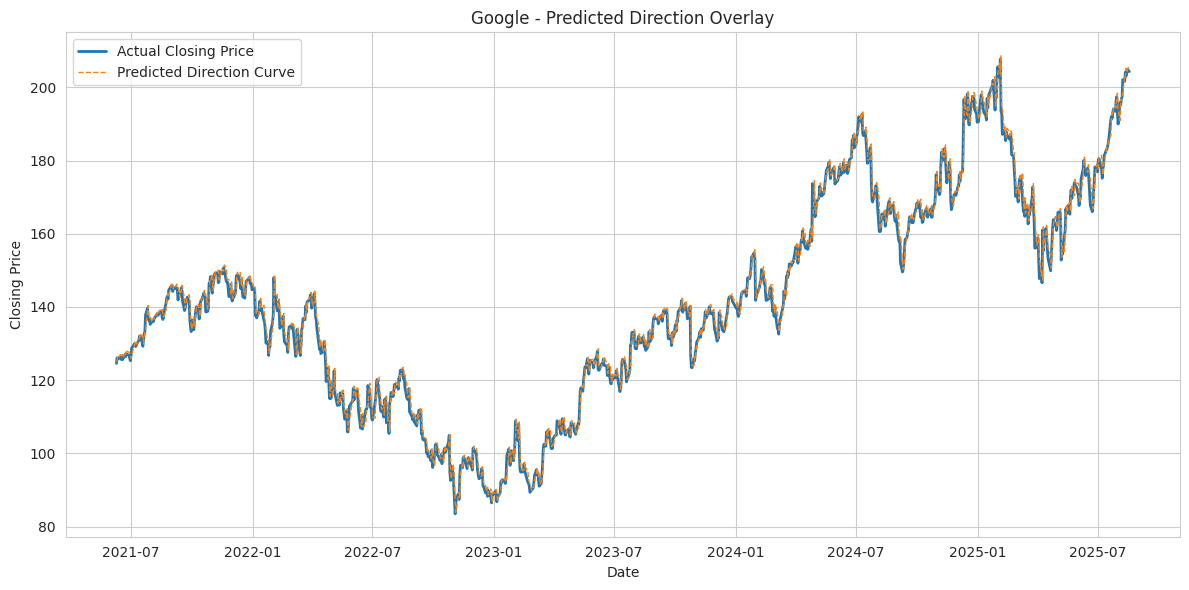


--- Samsung ---
Accuracy: 0.4769
              precision    recall  f1-score   support

           0       0.58      0.11      0.18       690
           1       0.47      0.91      0.62       589

    accuracy                           0.48      1279
   macro avg       0.52      0.51      0.40      1279
weighted avg       0.53      0.48      0.38      1279



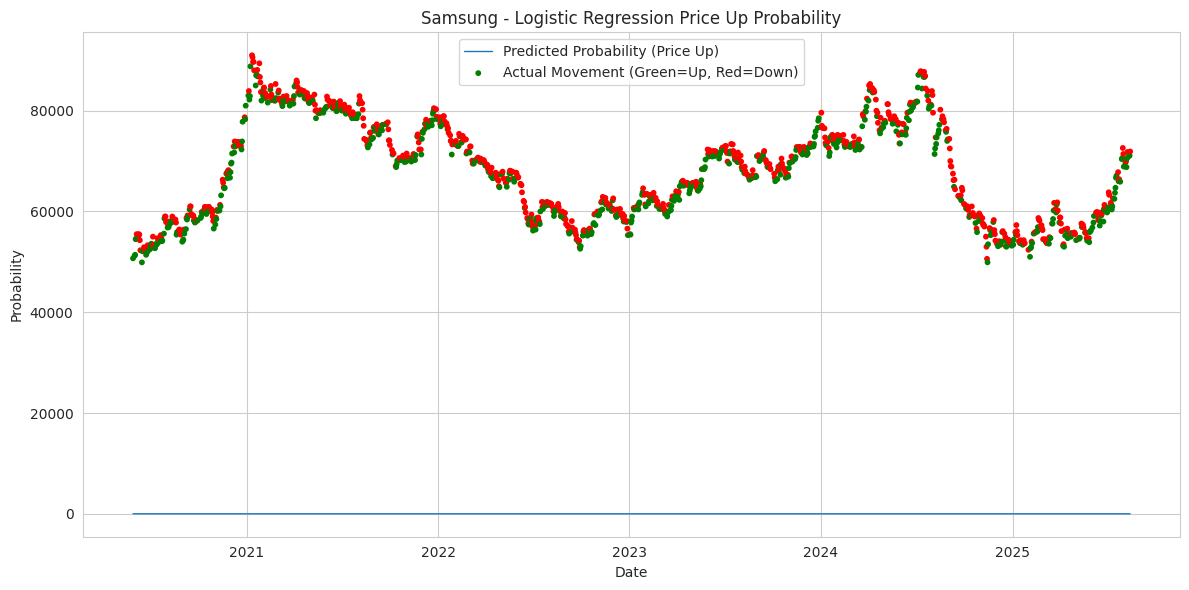

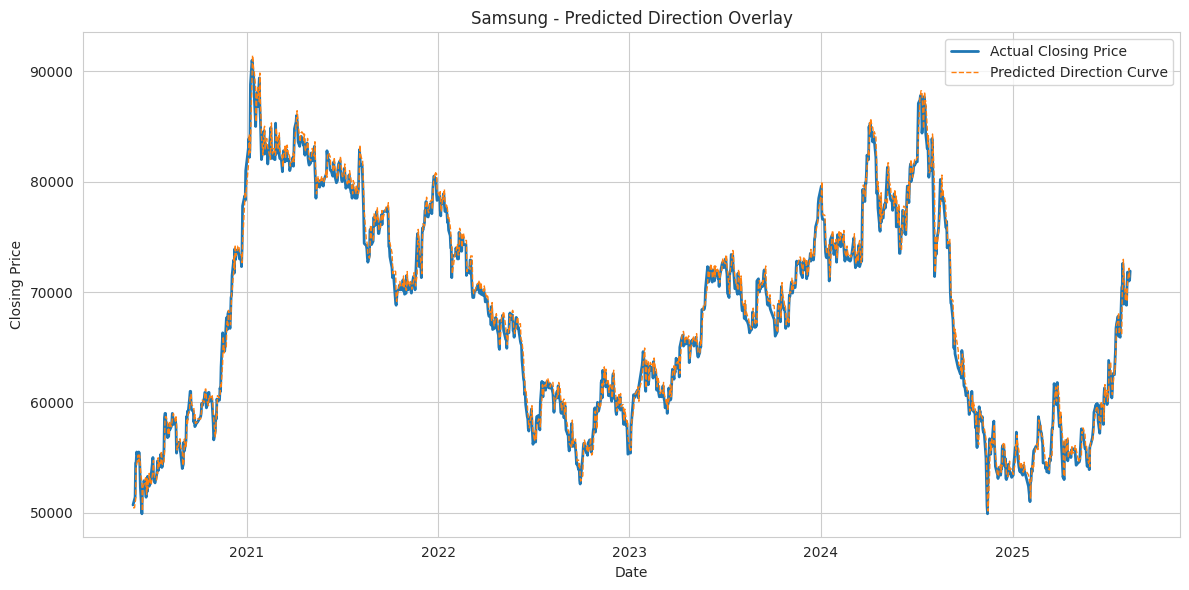


--- Visa ---
Accuracy: 0.5378
              precision    recall  f1-score   support

           0       0.37      0.04      0.07       392
           1       0.55      0.95      0.69       480

    accuracy                           0.54       872
   macro avg       0.46      0.49      0.38       872
weighted avg       0.47      0.54      0.41       872



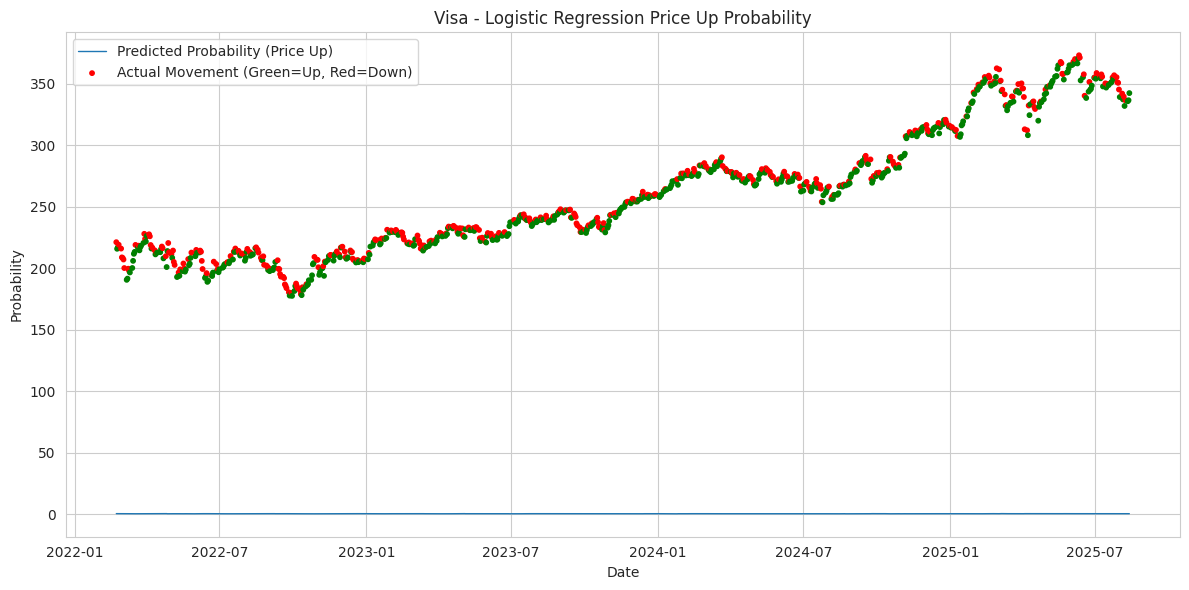

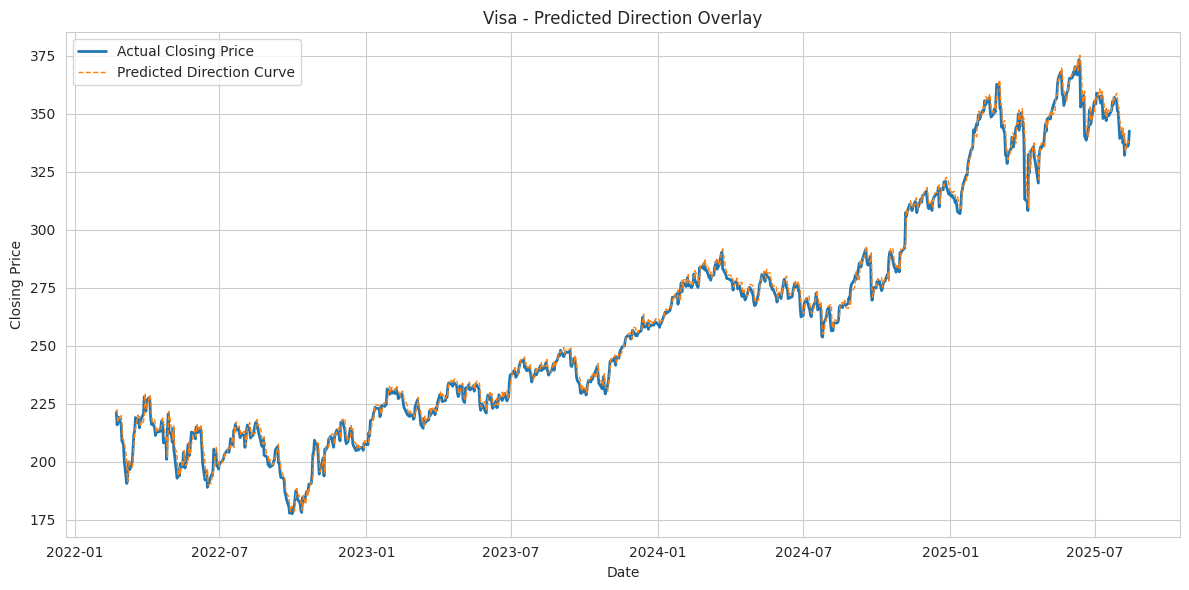


--- Walmart ---
Accuracy: 0.5212
              precision    recall  f1-score   support

           0       0.47      0.14      0.21      1257
           1       0.53      0.86      0.66      1410

    accuracy                           0.52      2667
   macro avg       0.50      0.50      0.43      2667
weighted avg       0.50      0.52      0.45      2667



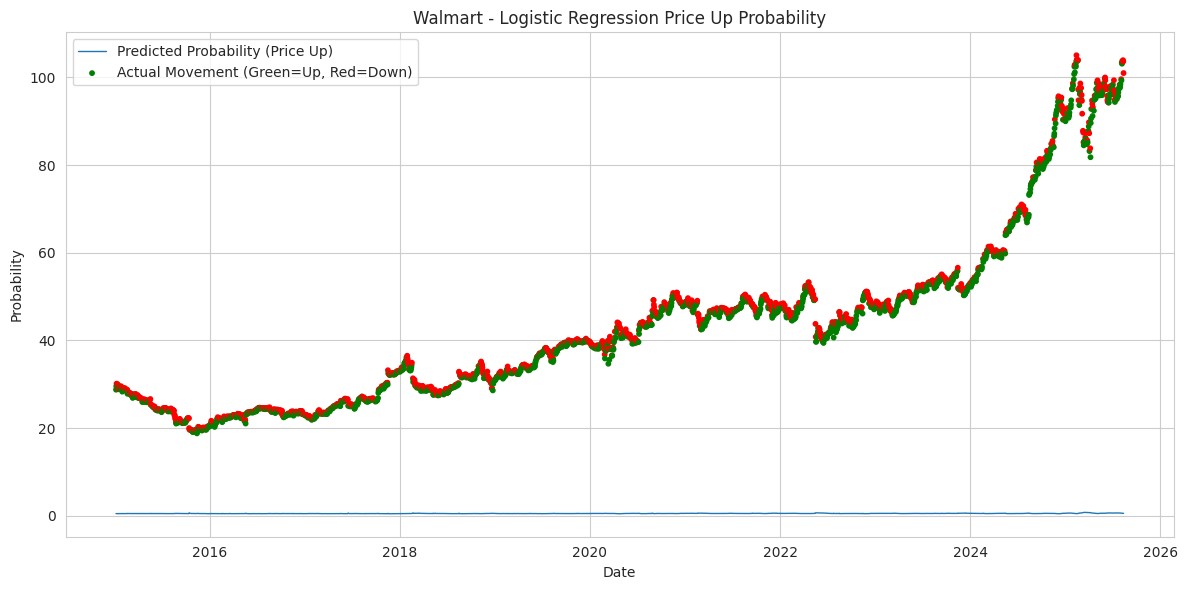

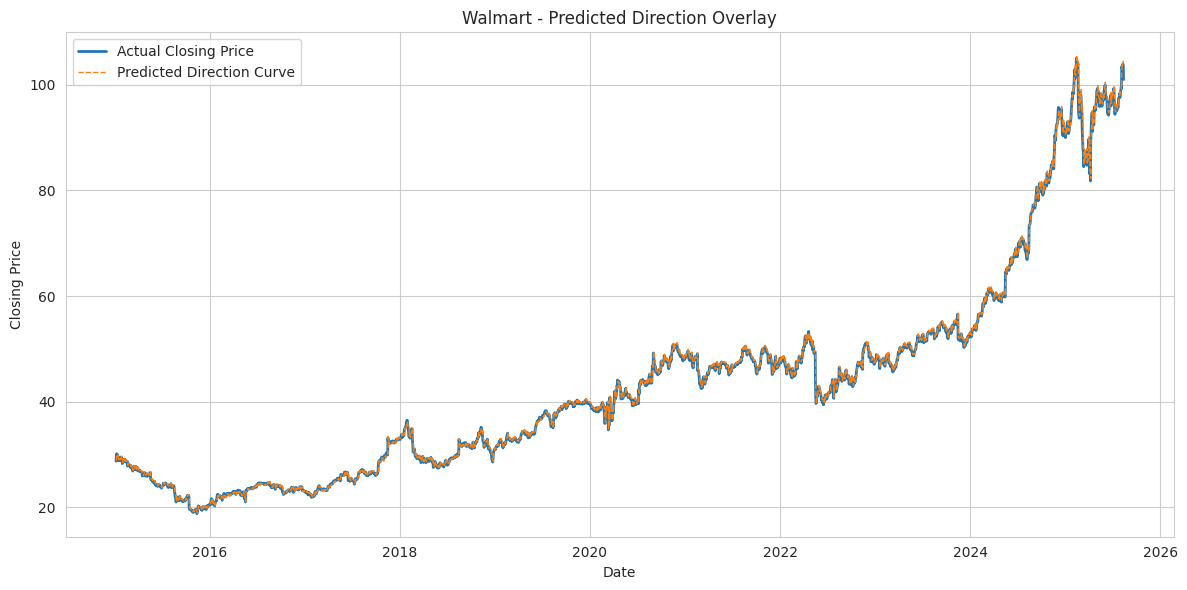

In [ ]:
# =======================================================================
# 2. LOGISTIC REGRESSION (Price Direction Classification) - FIXED VERSION
# =======================================================================

print("\n## 2. Logistic Regression (Price Direction)")
print("--------------------------------------------")

all_classification_metrics = []


def plot_classification_predictions(df, company, model_name, y_test, y_pred_proba, y_pred_class):
    test_index = df.index[-len(y_test):]

    # ====== 1) Probability Plot ======
    plt.figure(figsize=(12, 6))
    proba_up = y_pred_proba[:, 1]  # Probability of class = 1

    plt.plot(test_index, proba_up, label="Predicted Probability (Price Up)", linewidth=1)

    actual_price = df['close'].iloc[-len(y_test):]
    color_map = ['green' if y == 1 else 'red' for y in y_test]

    # Scatter actual movements
    plt.scatter(test_index, actual_price, c=color_map, s=10,
                label="Actual Movement (Green=Up, Red=Down)")

    plt.title(f"{company} - {model_name} Price Up Probability")
    plt.xlabel("Date")
    plt.ylabel("Probability")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ====== 2) Direction Overlay Plot ======
    plt.figure(figsize=(12, 6))

    plt.plot(test_index, actual_price, label="Actual Closing Price", linewidth=2)

    # Fake predicted movement curve (just visual direction)
    predicted_curve = actual_price.shift(1).fillna(actual_price.iloc[0])
    predicted_curve *= (1 + (y_pred_class * 0.01 - 0.005))

    plt.plot(test_index, predicted_curve,
             label="Predicted Direction Curve", linestyle="--", linewidth=1)

    plt.title(f"{company} - Predicted Direction Overlay")
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.legend()
    plt.tight_layout()
    plt.show()


# =========================
# MAIN LOOP (RUNS ONCE)
# =========================
for name, df in stocks_fe.items():

    # OPTIONALLY REMOVE SAMSUNG
    # if name.lower() == "samsung":
    #     continue

    if len(df) < 30:
        print(f"Skipping {name}: Not enough data.")
        continue

    # Prepare data
    X = df[CLASSIFICATION_FEATURES]
    y = df['price_up']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, shuffle=False
    )

    # Train logistic regression
    model = LogisticRegression(solver='liblinear', random_state=42)
    model.fit(X_train, y_train)

    # Predictions
    y_pred_class = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred_class)

    all_classification_metrics.append({
        "Company": name,
        "Model": "Logistic Regression",
        "Accuracy": acc
    })

    print(f"\n--- {name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred_class))

    # Plot (NO more shape mismatch!)
    plot_classification_predictions(df, name, "Logistic Regression",
                                    y_test.values, y_pred_proba, y_pred_class)


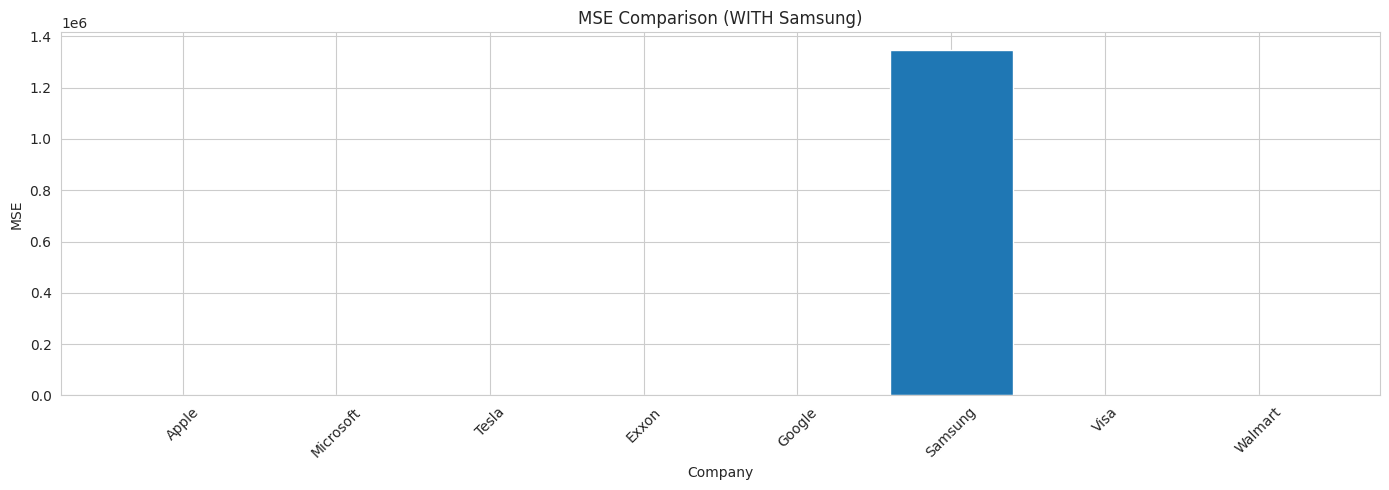

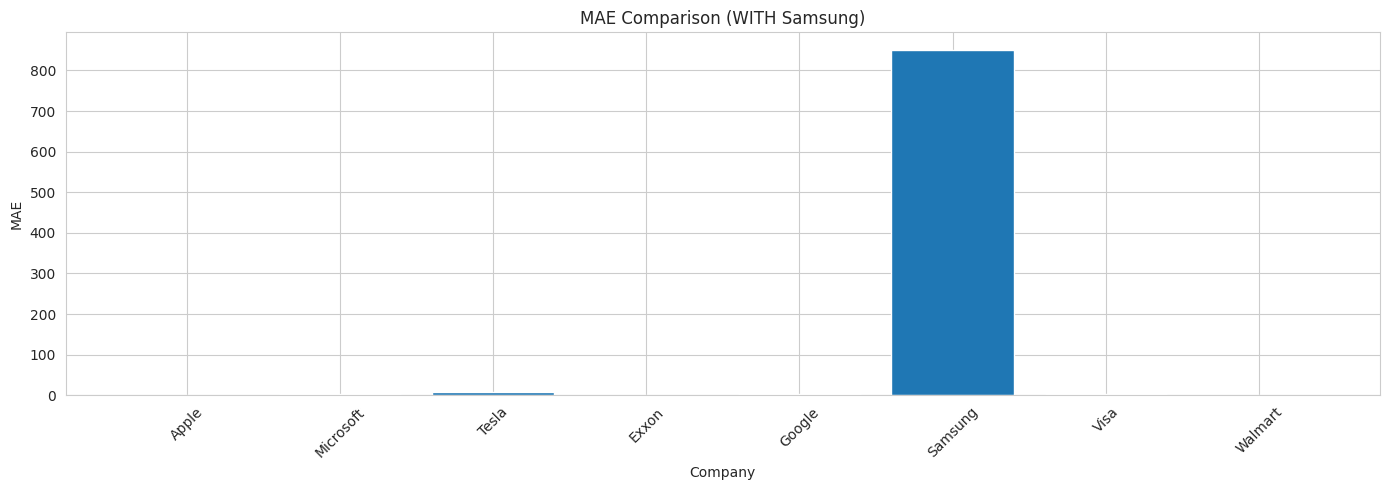

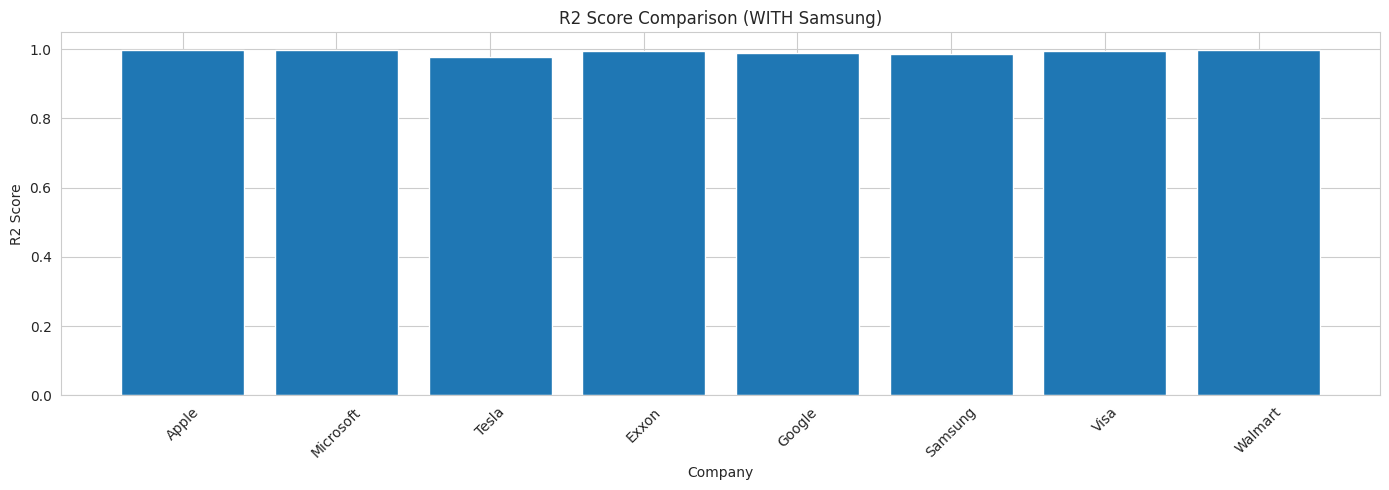

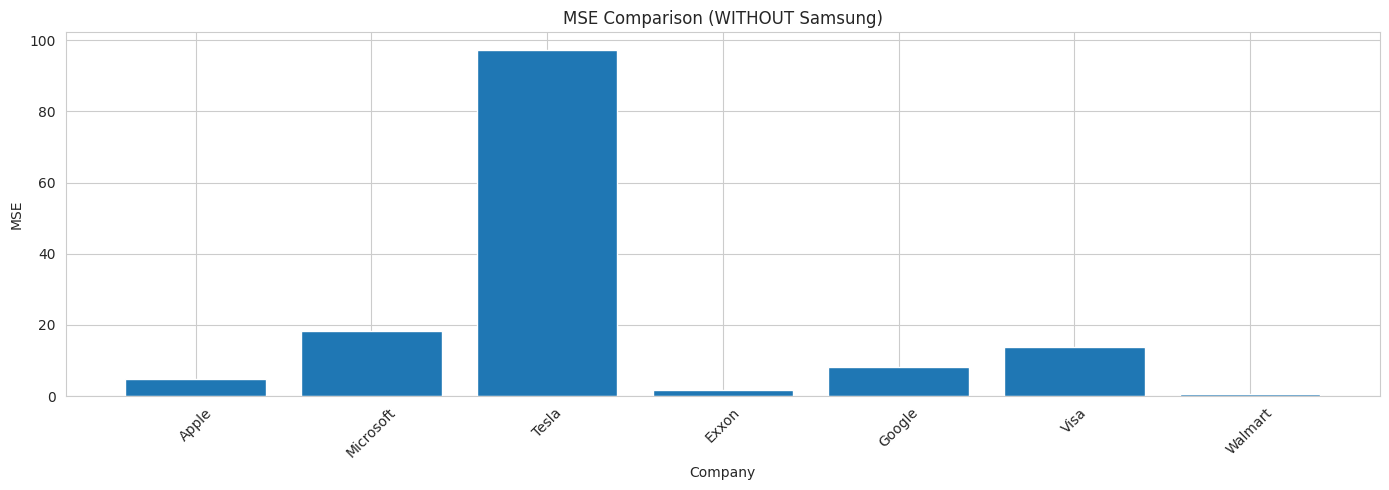

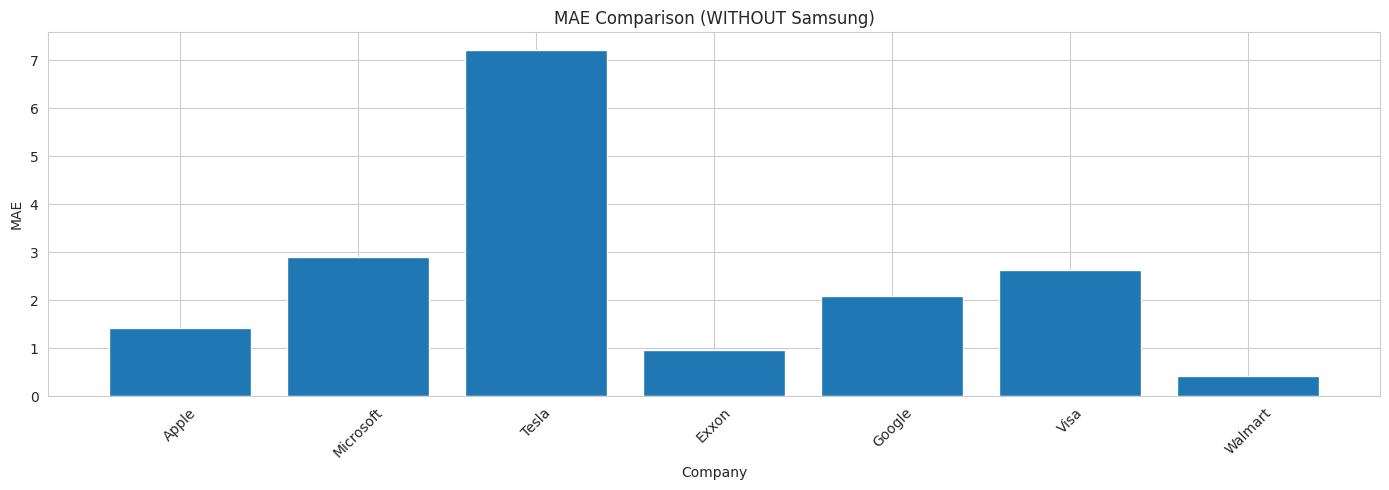

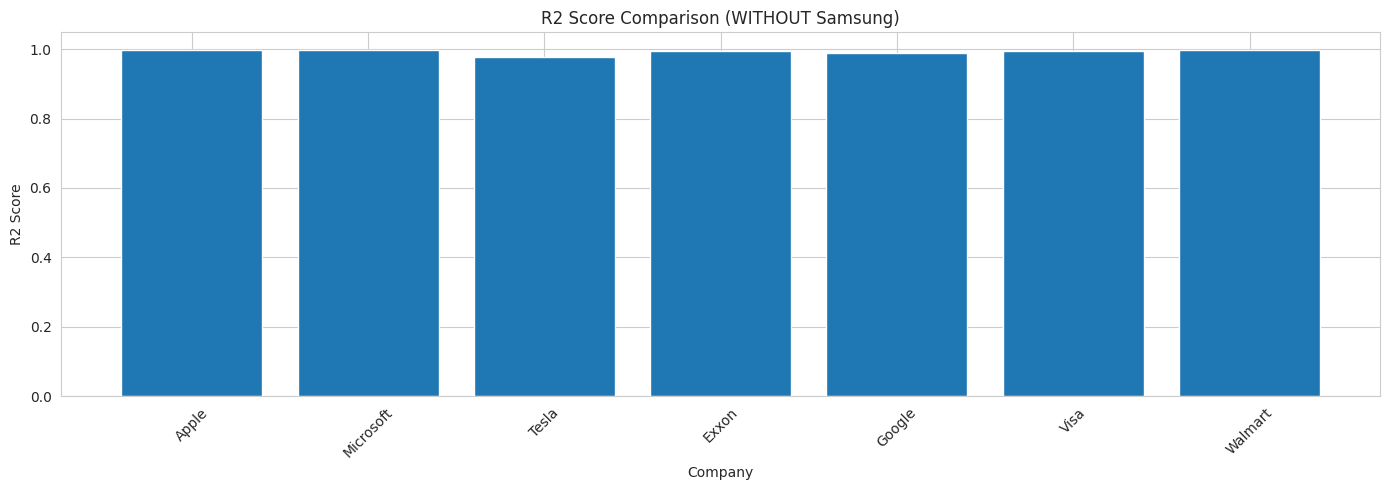

In [ ]:
# ==============================================================
# METRICS COMPARISON → WITH & WITHOUT SAMSUNG
# ==============================================================

metrics_df = pd.DataFrame(all_regression_metrics)

# ---- WITH SAMSUNG ----
plt.figure(figsize=(14,5))
plt.bar(metrics_df["Company"], metrics_df["MSE"])
plt.title("MSE Comparison (WITH Samsung)")
plt.xlabel("Company")
plt.ylabel("MSE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,5))
plt.bar(metrics_df["Company"], metrics_df["MAE"])
plt.title("MAE Comparison (WITH Samsung)")
plt.xlabel("Company")
plt.ylabel("MAE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,5))
plt.bar(metrics_df["Company"], metrics_df["R2"])
plt.title("R2 Score Comparison (WITH Samsung)")
plt.xlabel("Company")
plt.ylabel("R2 Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ---- WITHOUT SAMSUNG ----
metrics_no_samsung = metrics_df[metrics_df["Company"].str.lower() != "samsung"]

plt.figure(figsize=(14,5))
plt.bar(metrics_no_samsung["Company"], metrics_no_samsung["MSE"])
plt.title("MSE Comparison (WITHOUT Samsung)")
plt.xlabel("Company")
plt.ylabel("MSE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,5))
plt.bar(metrics_no_samsung["Company"], metrics_no_samsung["MAE"])
plt.title("MAE Comparison (WITHOUT Samsung)")
plt.xlabel("Company")
plt.ylabel("MAE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,5))
plt.bar(metrics_no_samsung["Company"], metrics_no_samsung["R2"])
plt.title("R2 Score Comparison (WITHOUT Samsung)")
plt.xlabel("Company")
plt.ylabel("R2 Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# ==============================================================
# FUTURE PREDICTIONS UNTIL 2030
# ==============================================================

future_predictions = {}

for company, df in stocks_fe.items():

    model = trained_models[company]
    scaler = scalers[company]

    last_row = df.iloc[-1].copy()
    future_list = []

    current_date = df.index[-1]
    end_date = pd.Timestamp("2030-12-31")

    # Keep rolling history for MA5
    close_history = list(df["close"].tail(5))

    while current_date < end_date:
        current_date += pd.Timedelta(days=1)

        if current_date.weekday() >= 5:  # Skip weekends
            continue

        # Prepare input
        X_future = last_row[REGRESSION_FEATURES].values.reshape(1, -1)
        X_scaled = scaler.transform(X_future)

        next_close = model.predict(X_scaled)[0]

        # Update sliding window history
        close_history.append(next_close)
        if len(close_history) > 5:
            close_history.pop(0)

        # Update features
        last_row["lag_1"] = next_close
        last_row["ma_5"] = sum(close_history) / len(close_history)

        # Keep RSI & MACD same (simple forecasting)

        future_list.append({
            "date": current_date,
            "predicted_close": next_close
        })

    future_predictions[company] = pd.DataFrame(future_list).set_index("date")


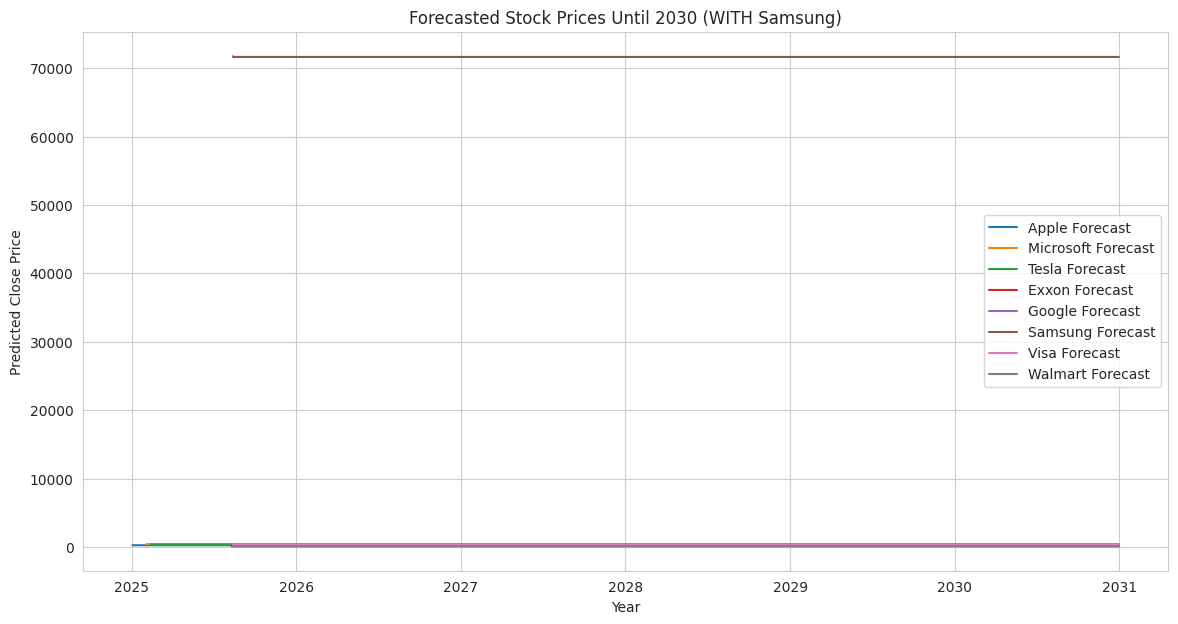

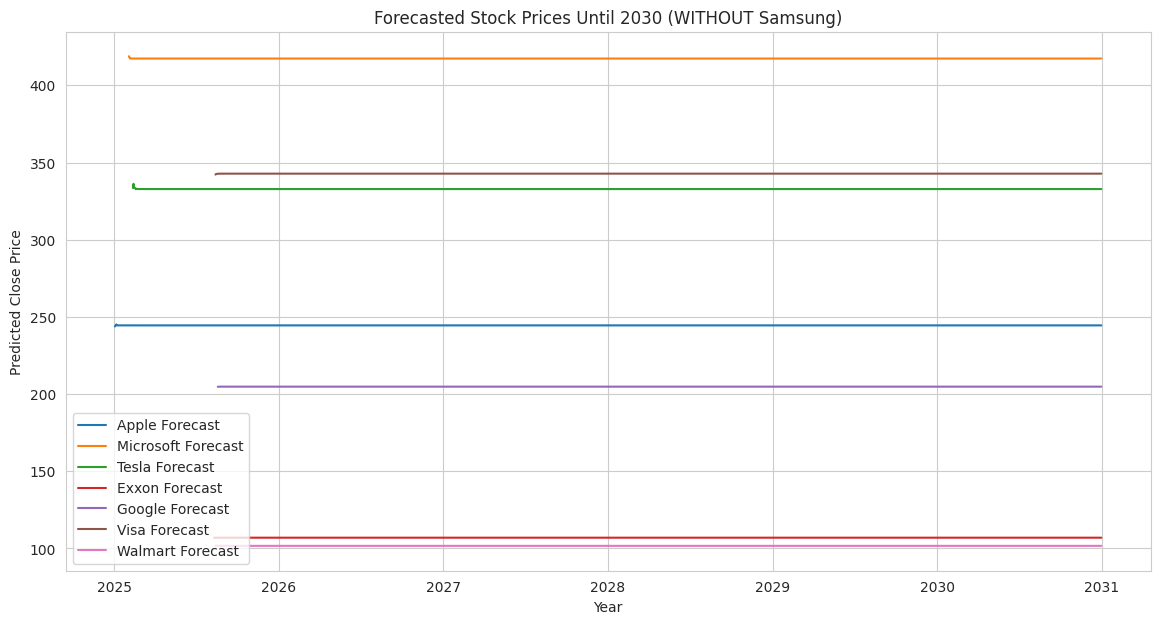

In [ ]:
# ==============================================================
# FORECAST PLOTS - WITH SAMSUNG
# ==============================================================

plt.figure(figsize=(14,7))

for company, pred_df in future_predictions.items():
    plt.plot(pred_df.index, pred_df["predicted_close"],
             label=f"{company} Forecast")

plt.title("Forecasted Stock Prices Until 2030 (WITH Samsung)")
plt.xlabel("Year")
plt.ylabel("Predicted Close Price")
plt.legend()
plt.grid(True)
plt.show()


# ==============================================================
# FORECAST PLOTS - WITHOUT SAMSUNG
# ==============================================================

plt.figure(figsize=(14,7))

for company, pred_df in future_predictions.items():
    if company.lower() == "samsung":
        continue

    plt.plot(pred_df.index, pred_df["predicted_close"],
             label=f"{company} Forecast")

plt.title("Forecasted Stock Prices Until 2030 (WITHOUT Samsung)")
plt.xlabel("Year")
plt.ylabel("Predicted Close Price")
plt.legend()
plt.grid(True)
plt.show()



## 3. Random Forest Regressor Analysis
---------------------------------------

 Regression Metrics for: Random Forest Regressor
Mean Squared Error (MSE): 9553.766663887262
Mean Absolute Error (MAE): 74.07815780342108
R2 Score: -1.3018965281931494


--- Apple - Random Forest Regressor ---
MAE: 74.0782, MSE: 9553.7667, R2: -1.3019

Plotting predictions for Apple using Random Forest Regressor...



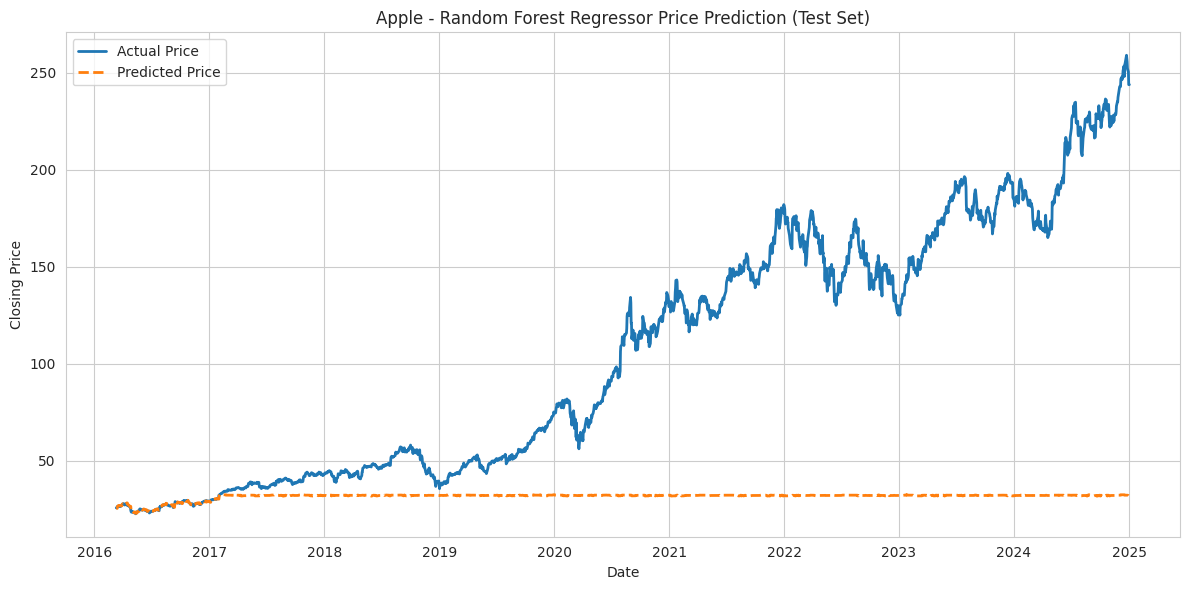


 Regression Metrics for: Random Forest Regressor
Mean Squared Error (MSE): 39584.09630688802
Mean Absolute Error (MAE): 163.6570949637134
R2 Score: -2.094287272133752


--- Microsoft - Random Forest Regressor ---
MAE: 163.6571, MSE: 39584.0963, R2: -2.0943

Plotting predictions for Microsoft using Random Forest Regressor...



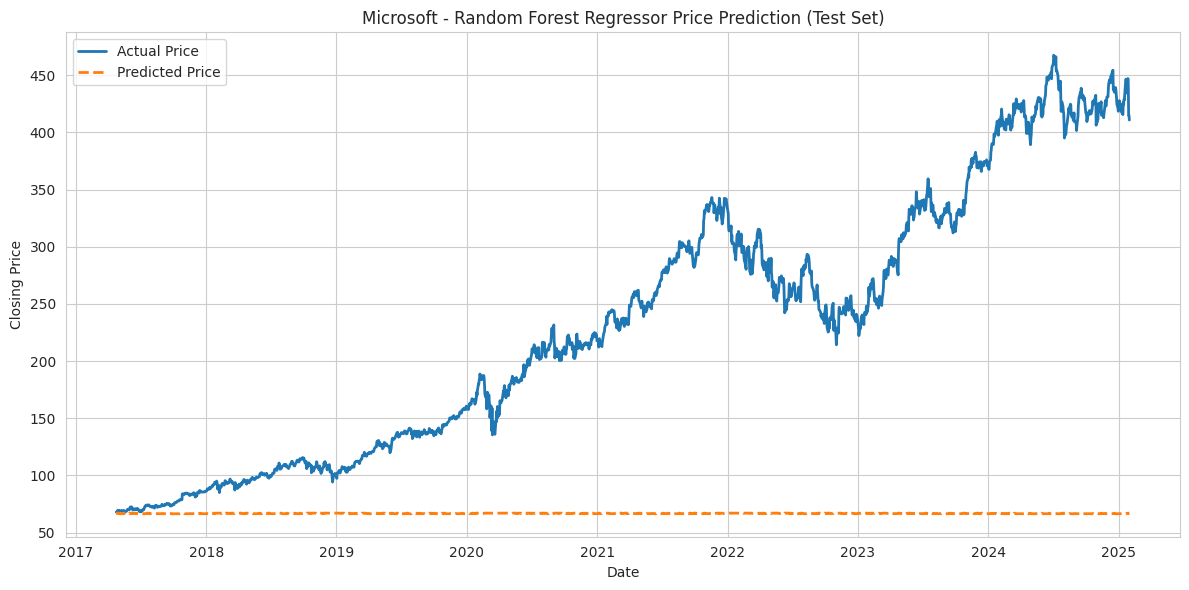


 Regression Metrics for: Random Forest Regressor
Mean Squared Error (MSE): 214.7604564280987
Mean Absolute Error (MAE): 10.272821976708585
R2 Score: 0.9510657891817542


--- Tesla - Random Forest Regressor ---
MAE: 10.2728, MSE: 214.7605, R2: 0.9511

Plotting predictions for Tesla using Random Forest Regressor...



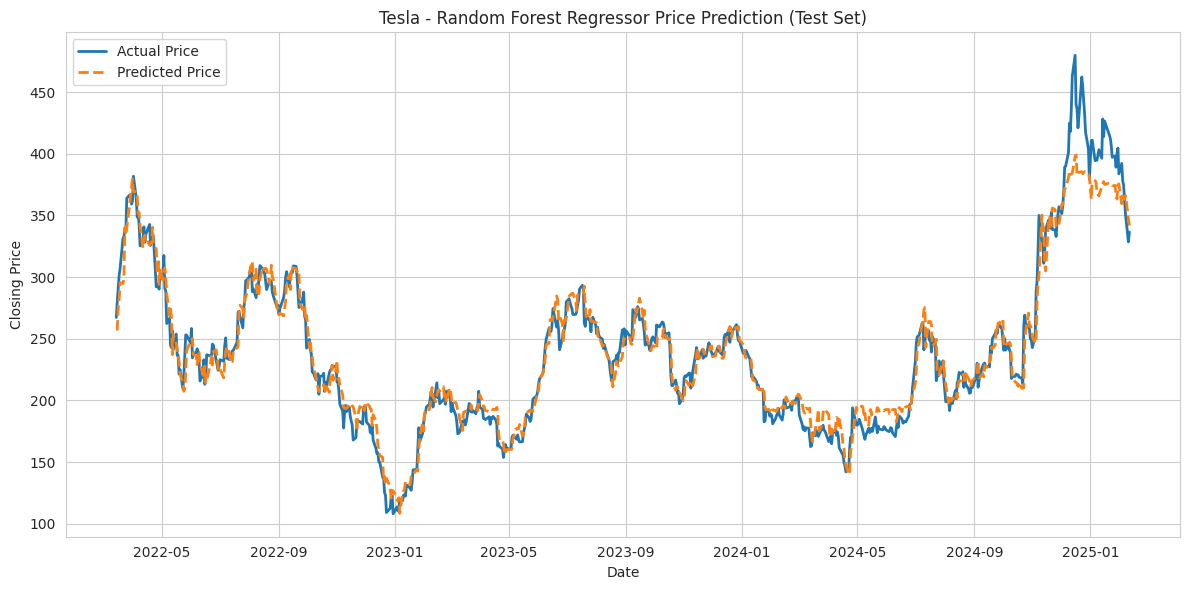


 Regression Metrics for: Random Forest Regressor
Mean Squared Error (MSE): 74.08751336134692
Mean Absolute Error (MAE): 4.798070486306101
R2 Score: 0.809355520315282


--- Exxon - Random Forest Regressor ---
MAE: 4.7981, MSE: 74.0875, R2: 0.8094

Plotting predictions for Exxon using Random Forest Regressor...



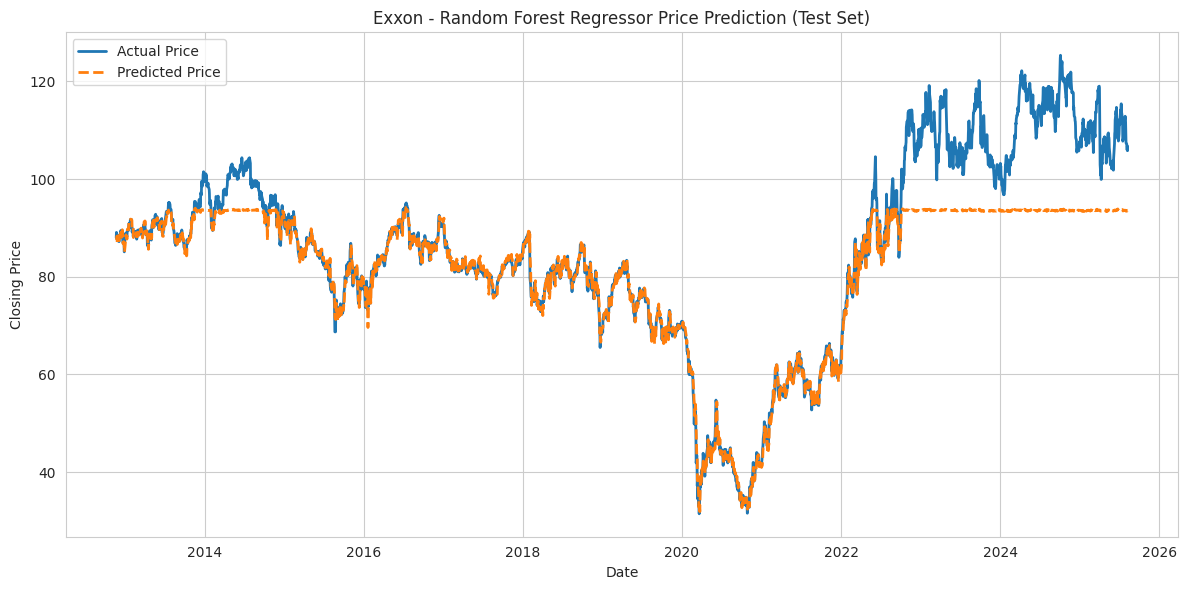


 Regression Metrics for: Random Forest Regressor
Mean Squared Error (MSE): 1027.2536084227293
Mean Absolute Error (MAE): 23.130122201454043
R2 Score: -0.23090078779846168


--- Google - Random Forest Regressor ---
MAE: 23.1301, MSE: 1027.2536, R2: -0.2309

Plotting predictions for Google using Random Forest Regressor...



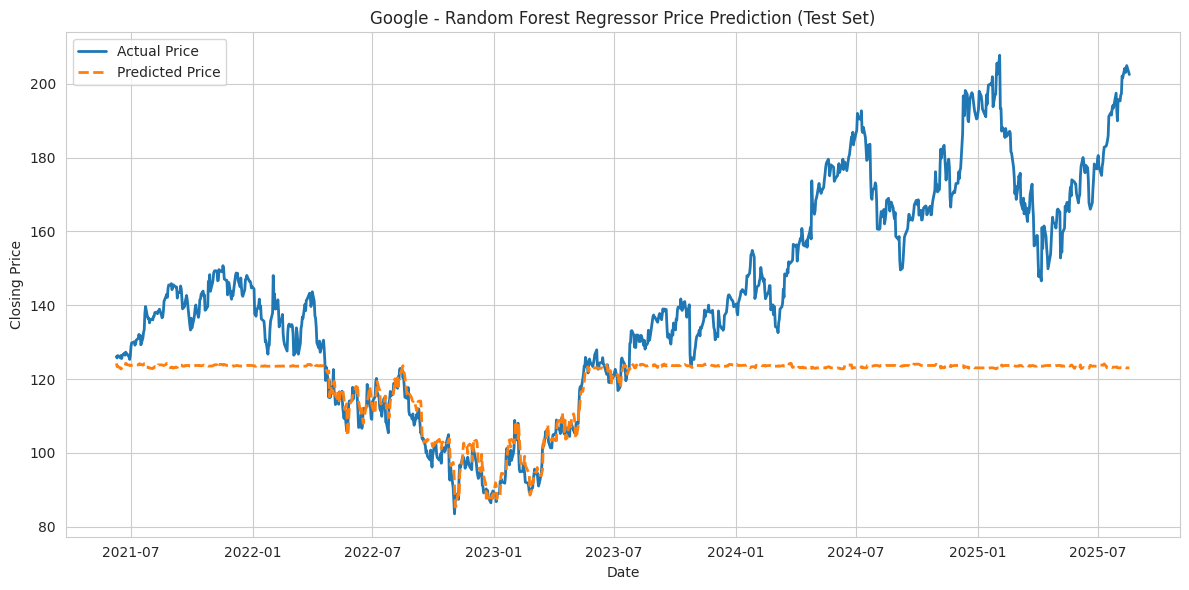


 Regression Metrics for: Random Forest Regressor
Mean Squared Error (MSE): 139516141.51856136
Mean Absolute Error (MAE): 8809.112744331509
R2 Score: -0.5082859789438106


--- Samsung - Random Forest Regressor ---
MAE: 8809.1127, MSE: 139516141.5186, R2: -0.5083

Plotting predictions for Samsung using Random Forest Regressor...



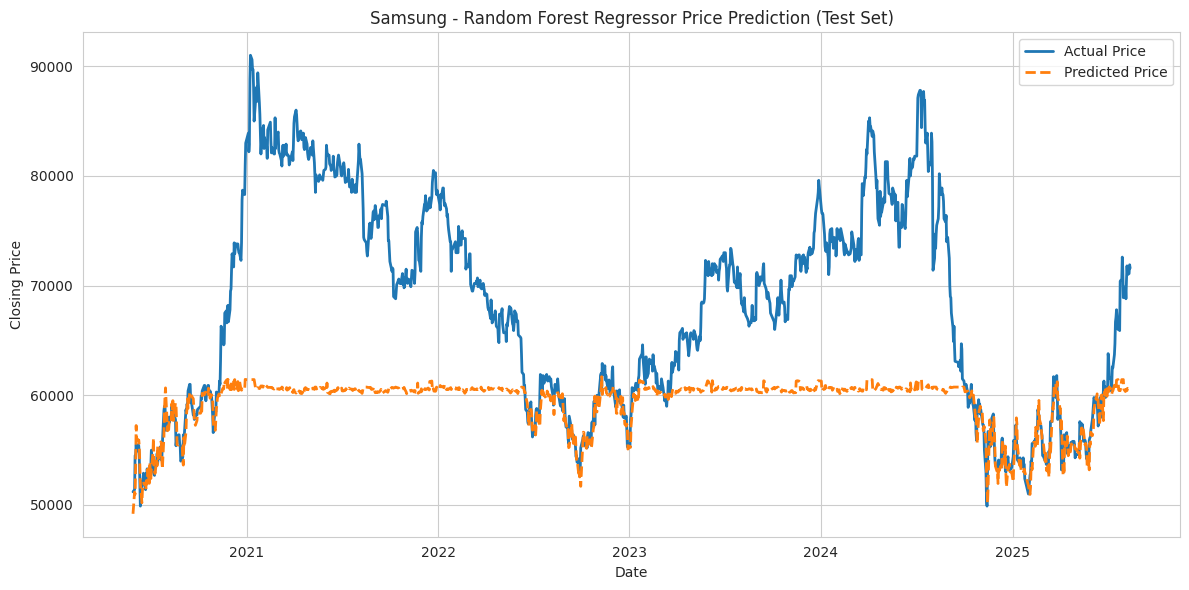


 Regression Metrics for: Random Forest Regressor
Mean Squared Error (MSE): 2388.2179878056886
Mean Absolute Error (MAE): 31.157170675085222
R2 Score: 0.043146391264835326


--- Visa - Random Forest Regressor ---
MAE: 31.1572, MSE: 2388.2180, R2: 0.0431

Plotting predictions for Visa using Random Forest Regressor...



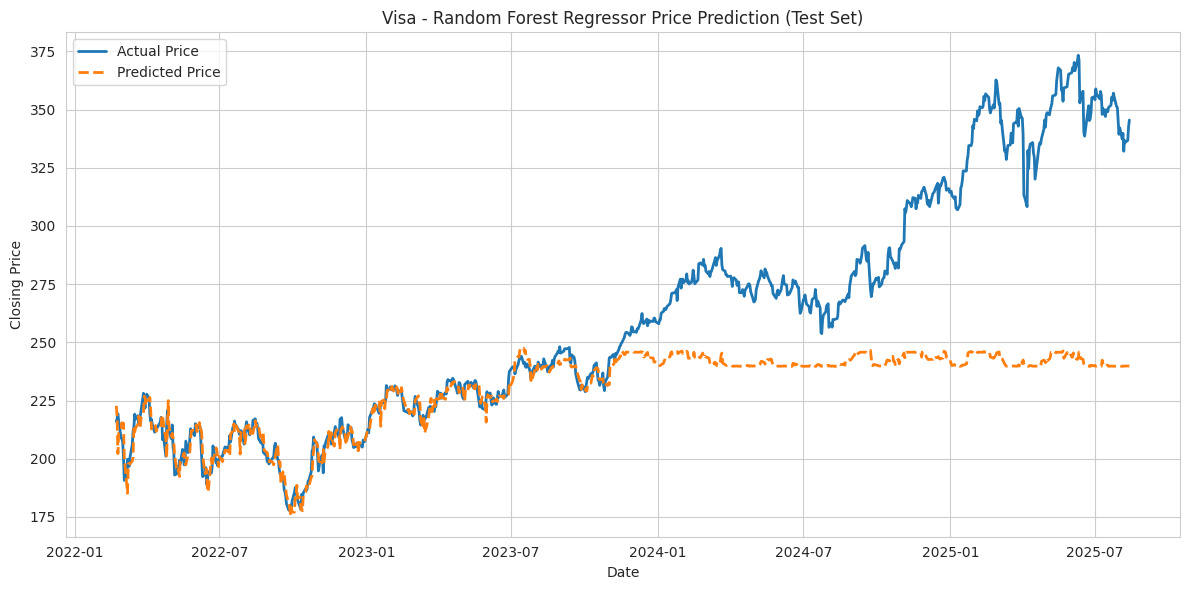


 Regression Metrics for: Random Forest Regressor
Mean Squared Error (MSE): 573.2509391649413
Mean Absolute Error (MAE): 15.671841488363686
R2 Score: -0.5337960743693997


--- Walmart - Random Forest Regressor ---
MAE: 15.6718, MSE: 573.2509, R2: -0.5338

Plotting predictions for Walmart using Random Forest Regressor...



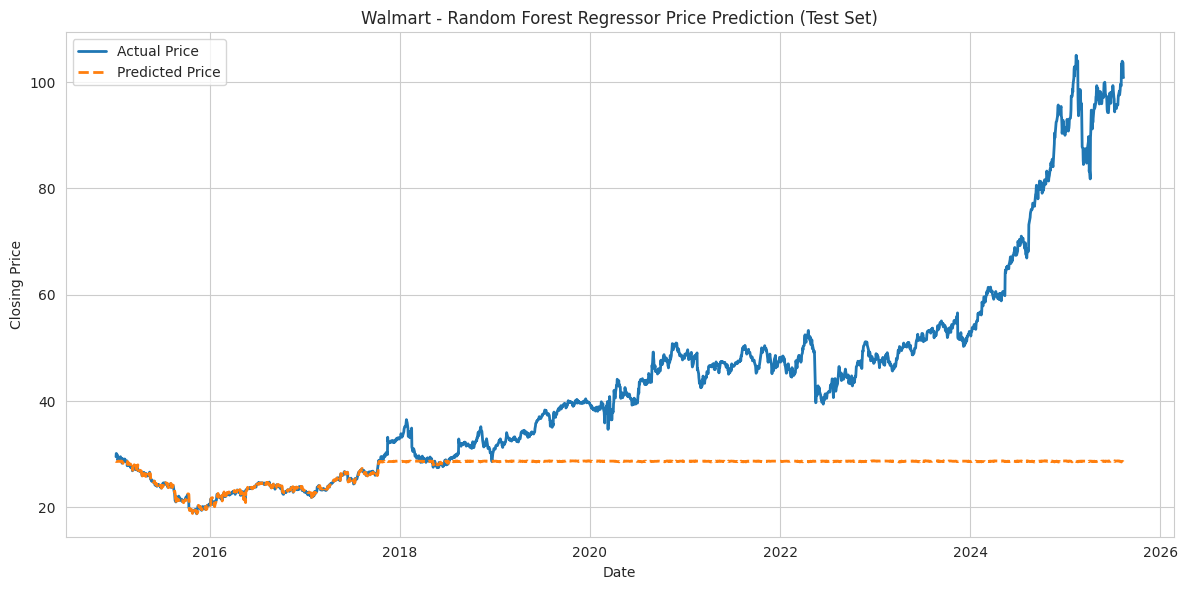

In [ ]:
# ==============================================================================
# 3. RANDOM FOREST REGRESSOR (Model 3)
# ==============================================================================
print("\n## 3. Random Forest Regressor Analysis")
print("---------------------------------------")

for name, df in stocks_fe.items():
    if len(df) < 21:
        continue

    # Prepare data for regression
    X = df[REGRESSION_FEATURES]
    y = df['target_close_tomorrow']

    # No scaling necessary for Tree-based models, but good practice to standardize X/y splitting
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    # Train Model
    # Using small n_estimators for faster execution, typically use 100+
    rf_model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)

    # Store Metrics
    metrics = calculate_metrics_regression(y_test, y_pred_rf, "Random Forest Regressor")
    metrics['Company'] = name
    all_regression_metrics.append(metrics)

    # Print Metrics and Plot
    print(f"\n--- {name} - Random Forest Regressor ---")
    print(f"MAE: {metrics['MAE']:.4f}, MSE: {metrics['MSE']:.4f}, R2: {metrics['R2']:.4f}")

    plot_predictions(df, name, "Random Forest Regressor", y_test, y_pred_rf)
    #

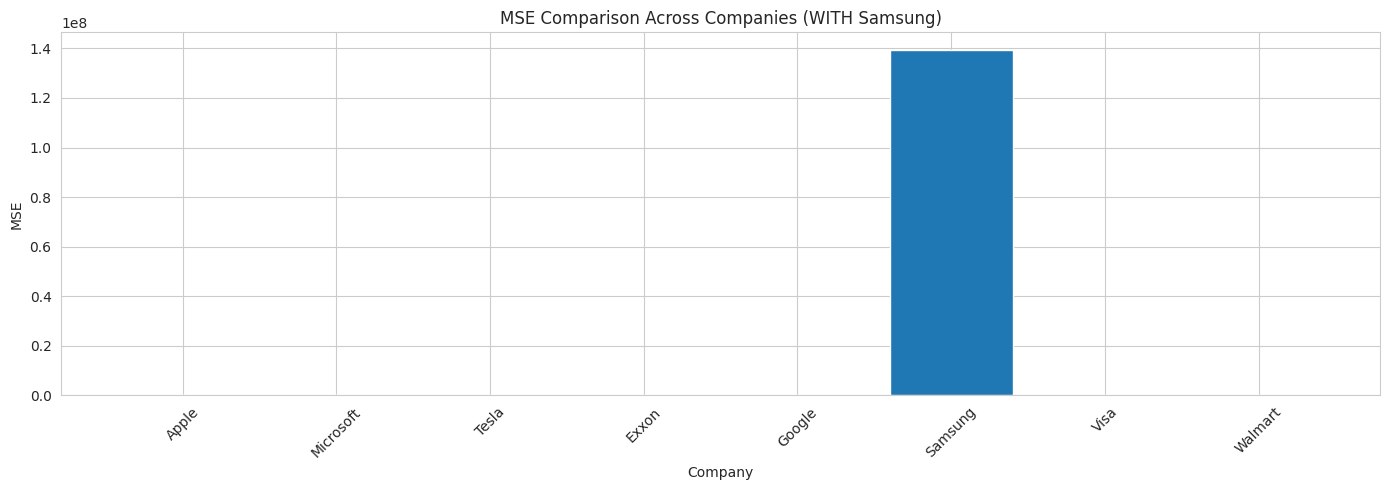

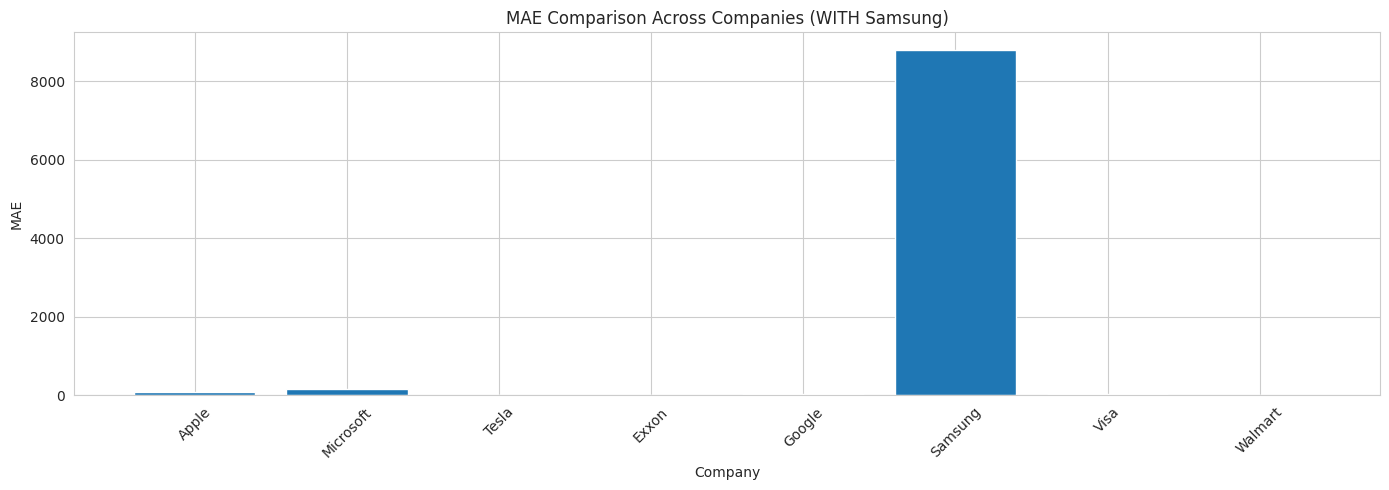

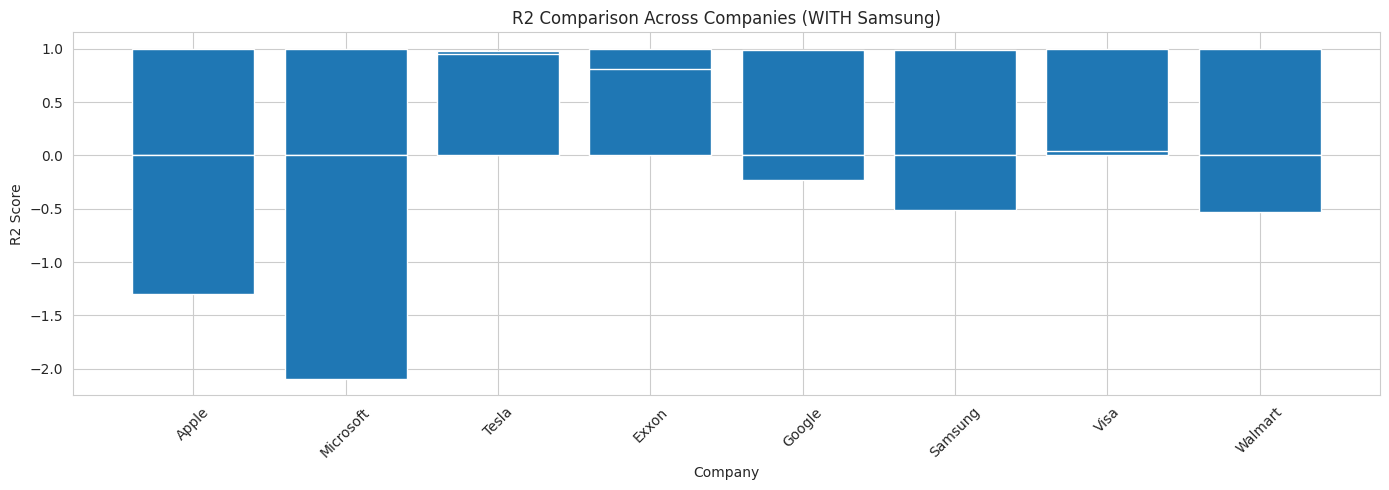

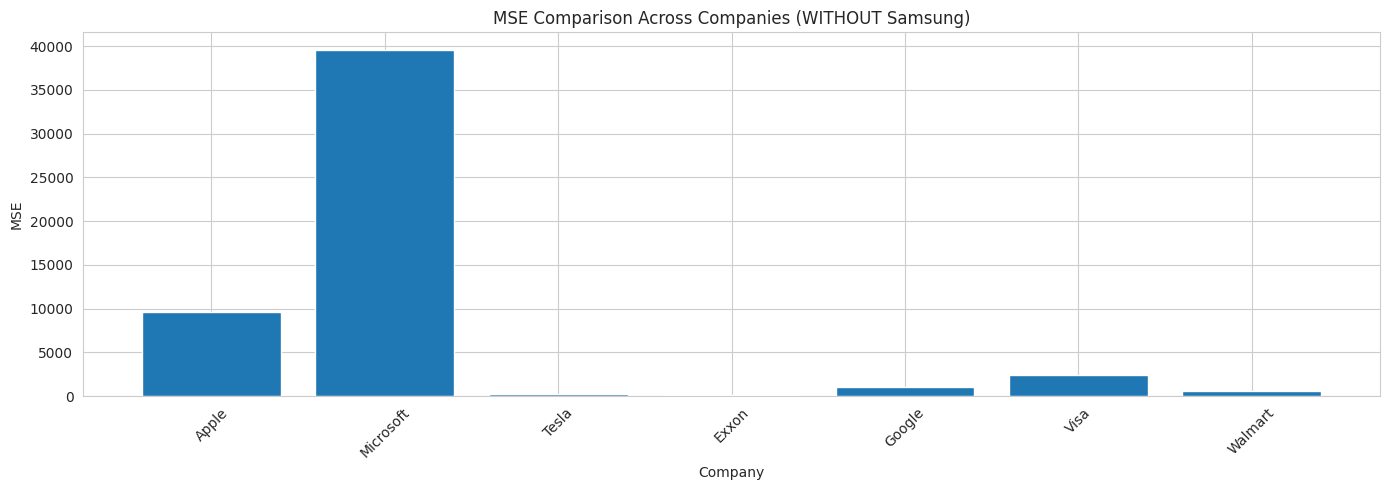

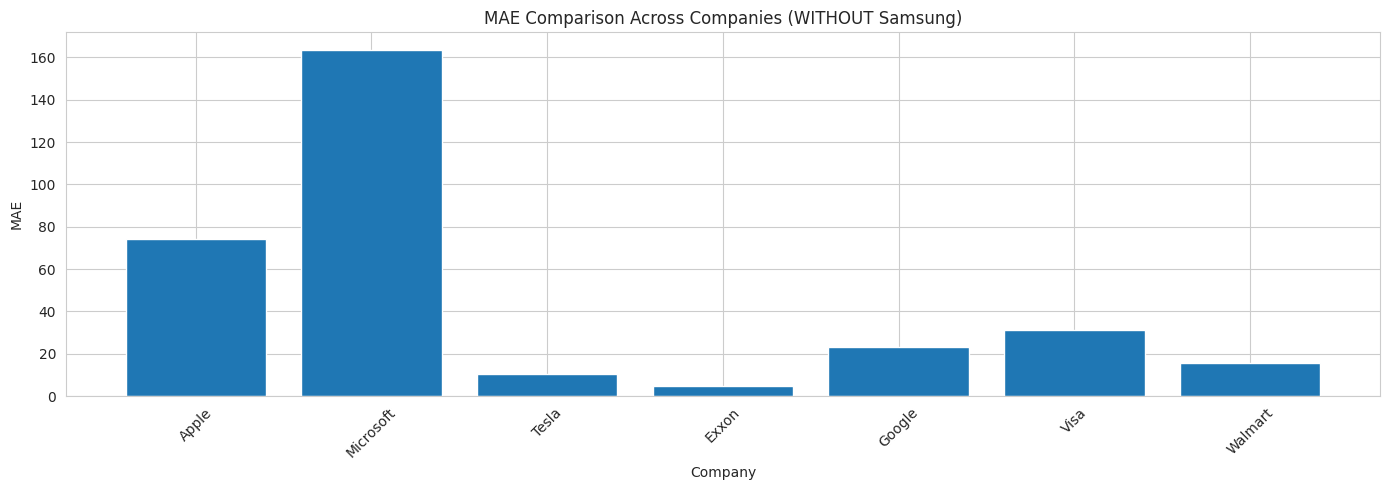

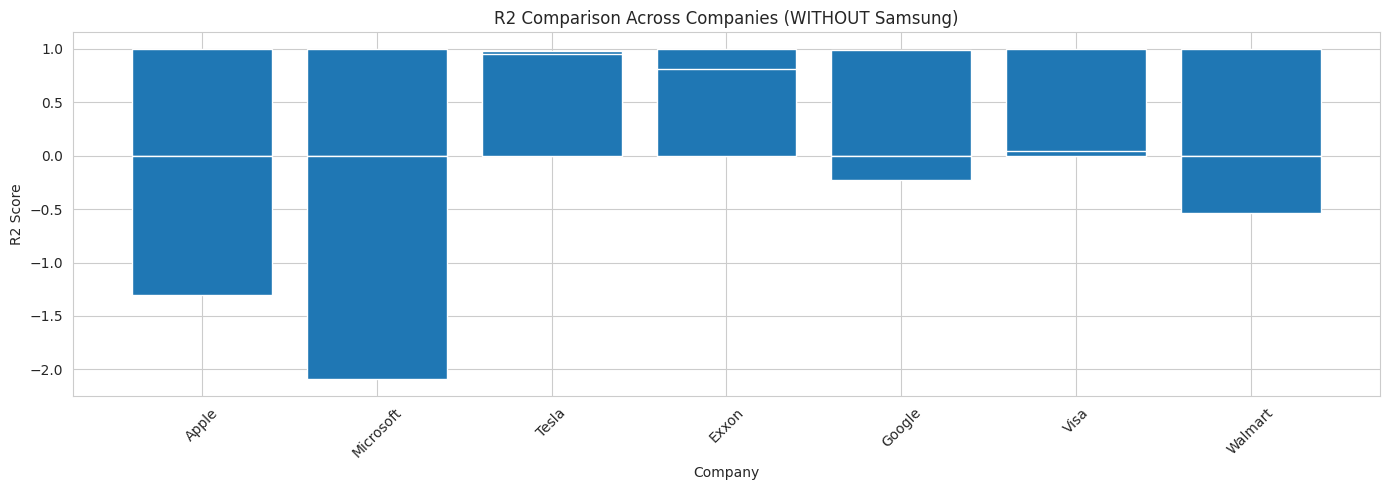

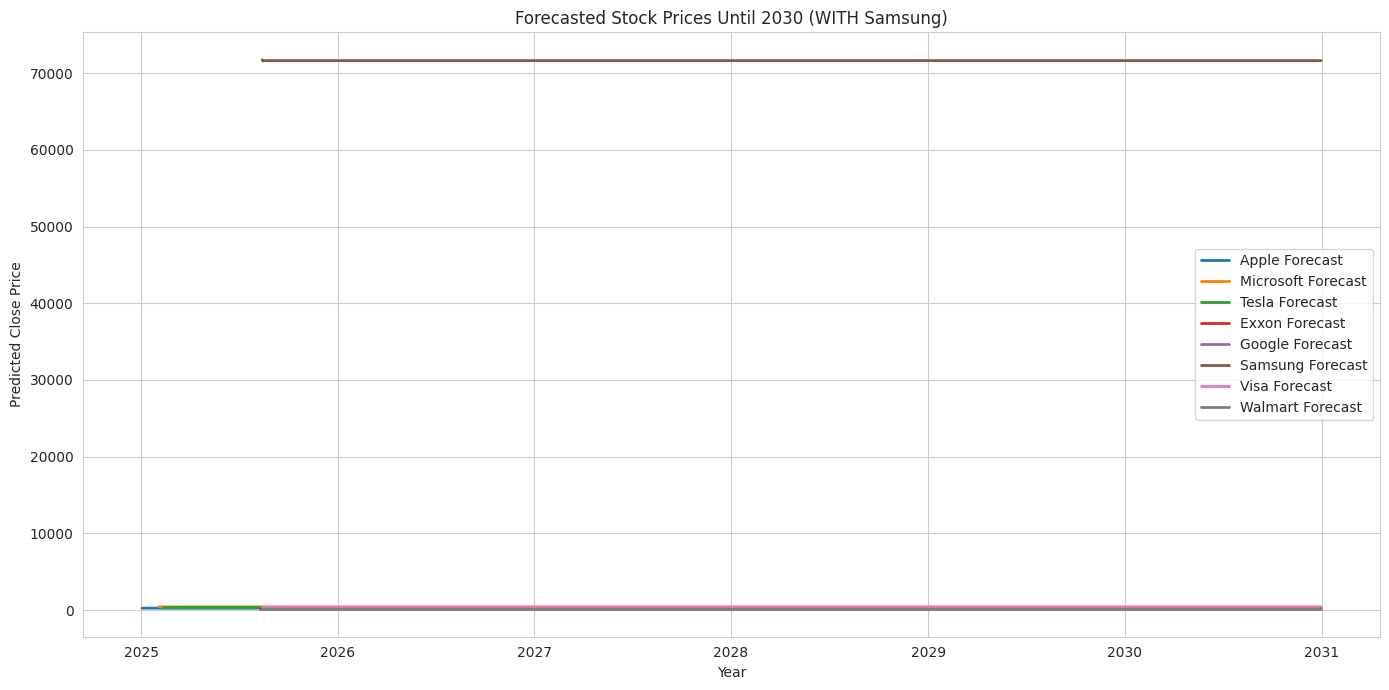

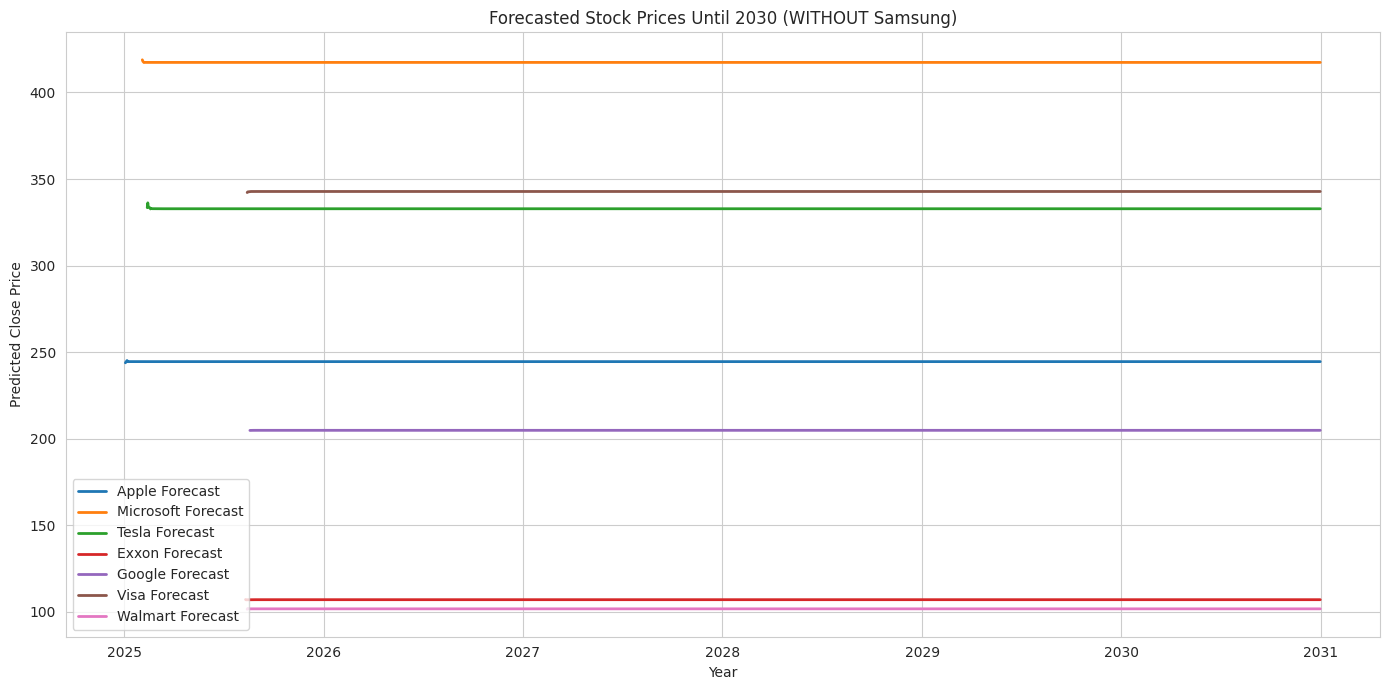

In [ ]:
# ==============================================================
# ✔ 1. METRICS COMPARISON FOR REGRESSION MODELS
# ==============================================================

metrics_df = pd.DataFrame(all_regression_metrics)

# ---------- WITH SAMSUNG ----------
plt.figure(figsize=(14,5))
plt.bar(metrics_df["Company"], metrics_df["MSE"])
plt.title("MSE Comparison Across Companies (WITH Samsung)")
plt.xlabel("Company"); plt.ylabel("MSE")
plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

plt.figure(figsize=(14,5))
plt.bar(metrics_df["Company"], metrics_df["MAE"])
plt.title("MAE Comparison Across Companies (WITH Samsung)")
plt.xlabel("Company"); plt.ylabel("MAE")
plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

plt.figure(figsize=(14,5))
plt.bar(metrics_df["Company"], metrics_df["R2"])
plt.title("R2 Comparison Across Companies (WITH Samsung)")
plt.xlabel("Company"); plt.ylabel("R2 Score")
plt.xticks(rotation=45)
plt.tight_layout(); plt.show()


# ---------- WITHOUT SAMSUNG ----------
metrics_no_samsung = metrics_df[metrics_df["Company"].str.lower() != "samsung"]

plt.figure(figsize=(14,5))
plt.bar(metrics_no_samsung["Company"], metrics_no_samsung["MSE"])
plt.title("MSE Comparison Across Companies (WITHOUT Samsung)")
plt.xlabel("Company"); plt.ylabel("MSE")
plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

plt.figure(figsize=(14,5))
plt.bar(metrics_no_samsung["Company"], metrics_no_samsung["MAE"])
plt.title("MAE Comparison Across Companies (WITHOUT Samsung)")
plt.xlabel("Company"); plt.ylabel("MAE")
plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

plt.figure(figsize=(14,5))
plt.bar(metrics_no_samsung["Company"], metrics_no_samsung["R2"])
plt.title("R2 Comparison Across Companies (WITHOUT Samsung)")
plt.xlabel("Company"); plt.ylabel("R2 Score")
plt.xticks(rotation=45)
plt.tight_layout(); plt.show()



# ==============================================================
# ✔ 2. FUTURE PREDICTIONS UNTIL 2030
# ==============================================================

future_predictions = {}

for company, df in stocks_fe.items():

    model = trained_models[company]
    scaler = scalers[company]

    last_row = df.iloc[-1].copy()
    future_list = []

    current_date = df.index[-1]
    end_date = pd.Timestamp("2030-12-31")

    # Keep rolling 5-day window for MA5
    close_history = list(df["close"].tail(5))

    while current_date < end_date:
        current_date += pd.Timedelta(days=1)

        # Skip weekends
        if current_date.weekday() >= 5:
            continue

        # Prepare input row
        X_future = last_row[REGRESSION_FEATURES].values.reshape(1, -1)
        X_scaled = scaler.transform(X_future)
        next_close = model.predict(X_scaled)[0]

        # Update rolling history for MA5
        close_history.append(next_close)
        if len(close_history) > 5:
            close_history.pop(0)

        # Update feature set for next prediction
        last_row["lag_1"] = next_close
        last_row["ma_5"] = sum(close_history) / len(close_history)

        # Save prediction
        future_list.append({
            "date": current_date,
            "predicted_close": next_close
        })

    future_predictions[company] = pd.DataFrame(future_list).set_index("date")



# ==============================================================
# ✔ 3. FORECAST VISUALIZATION UNTIL 2030
# ==============================================================

# -------- WITH SAMSUNG --------
plt.figure(figsize=(14,7))
for company, pred_df in future_predictions.items():
    plt.plot(
        pred_df.index,
        pred_df["predicted_close"],
        label=f"{company} Forecast",
        linewidth=2
    )
plt.title("Forecasted Stock Prices Until 2030 (WITH Samsung)")
plt.xlabel("Year"); plt.ylabel("Predicted Close Price")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

# -------- WITHOUT SAMSUNG --------
plt.figure(figsize=(14,7))
for company, pred_df in future_predictions.items():
    if company.lower() == "samsung":
        continue
    plt.plot(
        pred_df.index,
        pred_df["predicted_close"],
        label=f"{company} Forecast",
        linewidth=2
    )
plt.title("Forecasted Stock Prices Until 2030 (WITHOUT Samsung)")
plt.xlabel("Year"); plt.ylabel("Predicted Close Price")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()



## 4. XGBoost Regressor (Advanced Ensemble Model) Analysis
---------------------------------------

 Regression Metrics for: XGBoost Regressor
Mean Squared Error (MSE): 9611.005019436181
Mean Absolute Error (MAE): 74.37894610653491
R2 Score: -1.315687609402572


--- Apple - XGBoost Regressor ---
MAE: 74.3789, MSE: 9611.0050, R2: -1.3157

Plotting predictions for Apple using XGBoost Regressor...



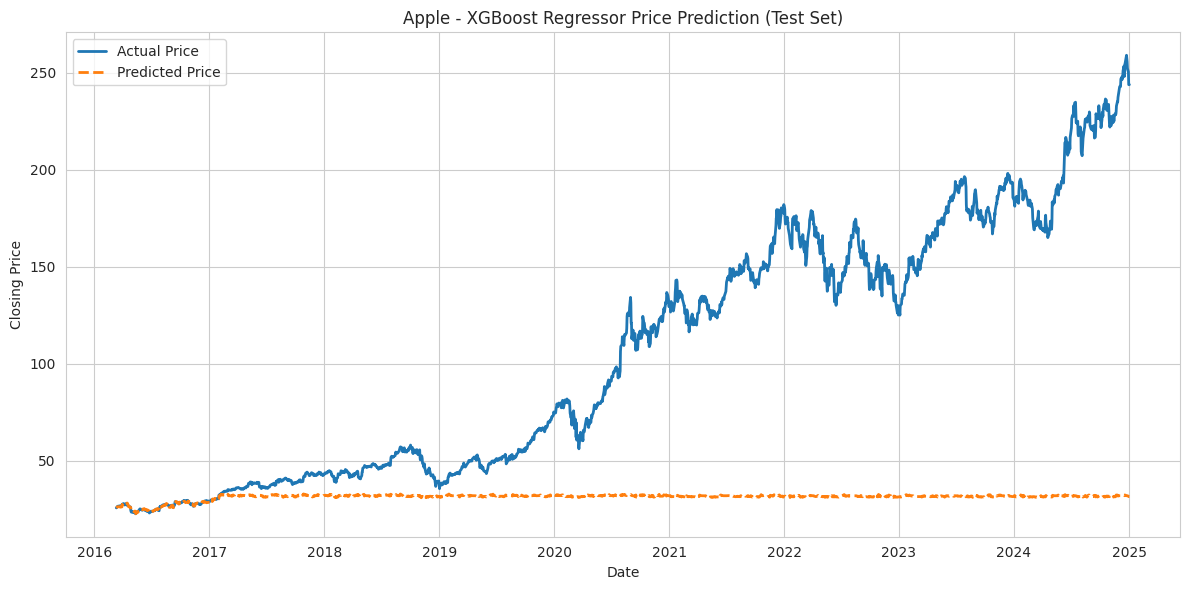


 Regression Metrics for: XGBoost Regressor
Mean Squared Error (MSE): 40251.34901617696
Mean Absolute Error (MAE): 165.69025851368662
R2 Score: -2.1464463905241913


--- Microsoft - XGBoost Regressor ---
MAE: 165.6903, MSE: 40251.3490, R2: -2.1464

Plotting predictions for Microsoft using XGBoost Regressor...



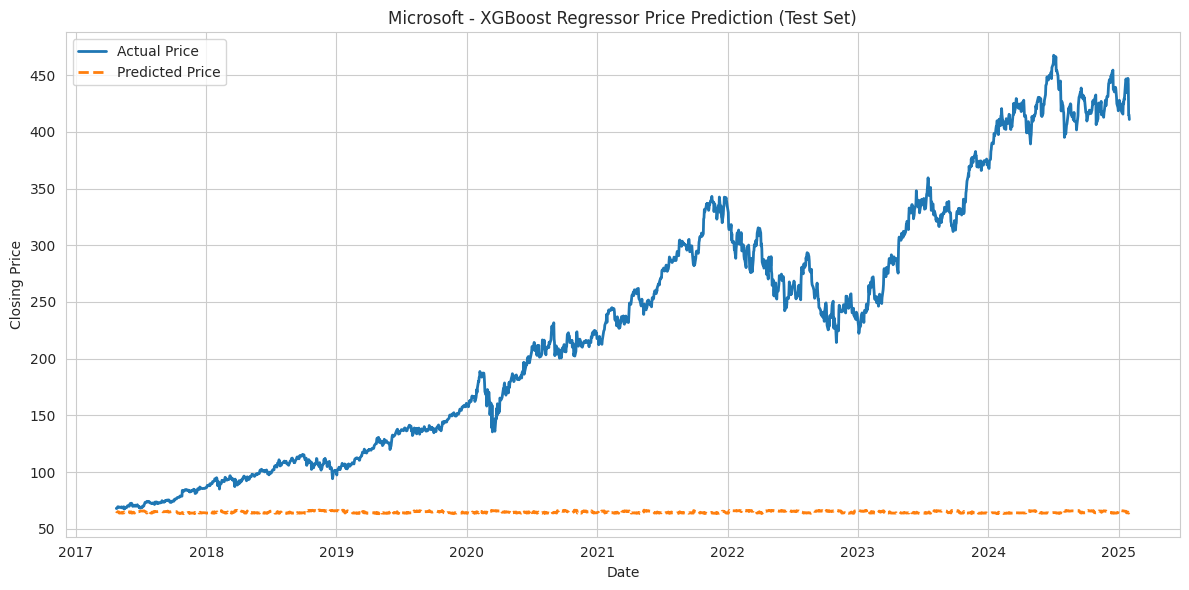


 Regression Metrics for: XGBoost Regressor
Mean Squared Error (MSE): 298.6527653685308
Mean Absolute Error (MAE): 10.913328962899296
R2 Score: 0.9319505200116363


--- Tesla - XGBoost Regressor ---
MAE: 10.9133, MSE: 298.6528, R2: 0.9320

Plotting predictions for Tesla using XGBoost Regressor...



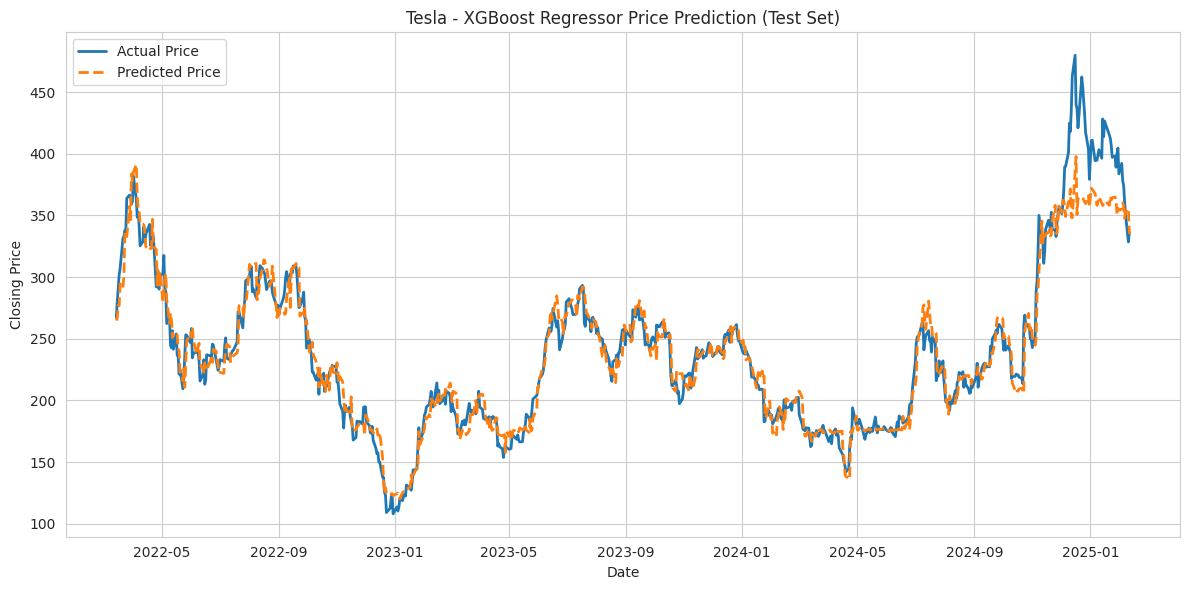


 Regression Metrics for: XGBoost Regressor
Mean Squared Error (MSE): 85.49248461895488
Mean Absolute Error (MAE): 5.228854862282319
R2 Score: 0.7800078649199506


--- Exxon - XGBoost Regressor ---
MAE: 5.2289, MSE: 85.4925, R2: 0.7800

Plotting predictions for Exxon using XGBoost Regressor...



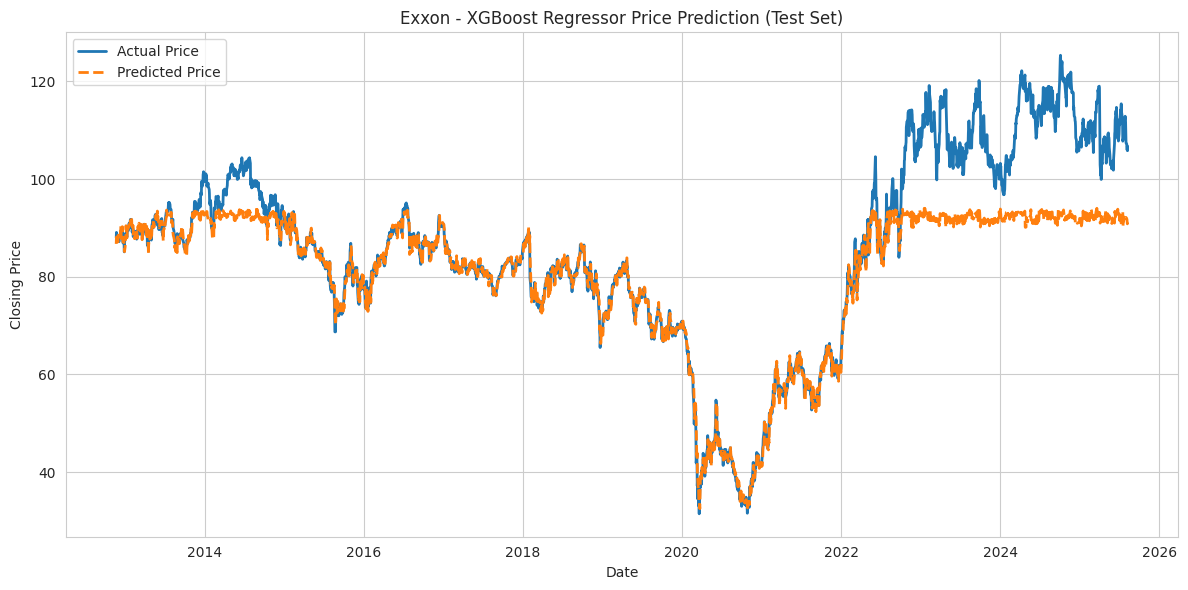


 Regression Metrics for: XGBoost Regressor
Mean Squared Error (MSE): 1189.6373998254628
Mean Absolute Error (MAE): 25.504617710964858
R2 Score: -0.4254762413422306


--- Google - XGBoost Regressor ---
MAE: 25.5046, MSE: 1189.6374, R2: -0.4255

Plotting predictions for Google using XGBoost Regressor...



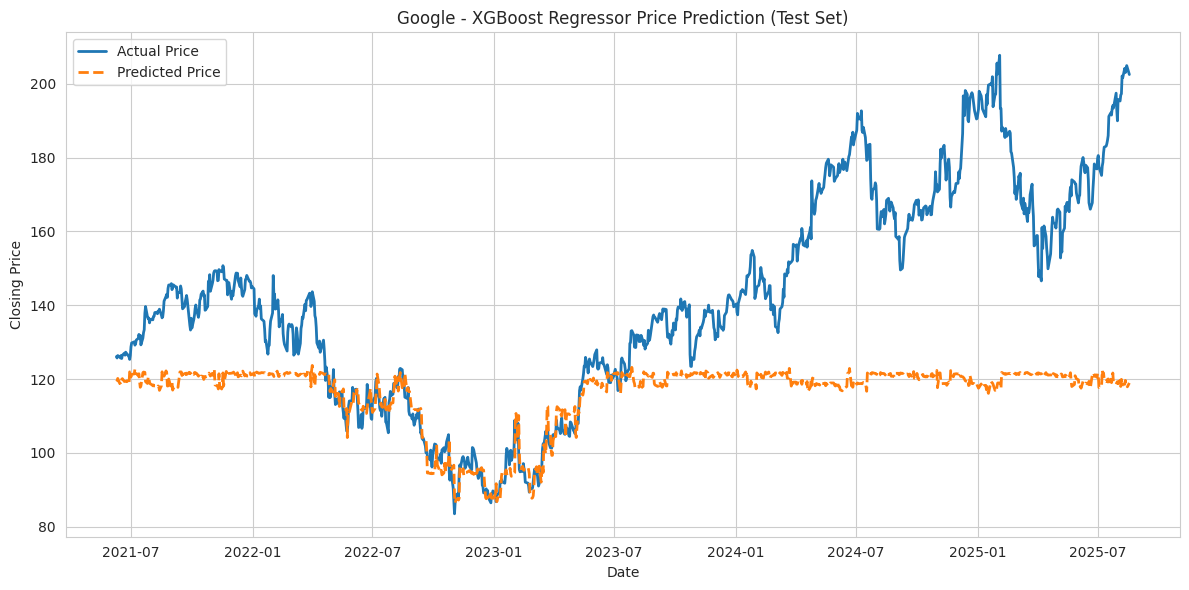


 Regression Metrics for: XGBoost Regressor
Mean Squared Error (MSE): 153987428.34182218
Mean Absolute Error (MAE): 9416.947459563135
R2 Score: -0.6647326723172415


--- Samsung - XGBoost Regressor ---
MAE: 9416.9475, MSE: 153987428.3418, R2: -0.6647

Plotting predictions for Samsung using XGBoost Regressor...



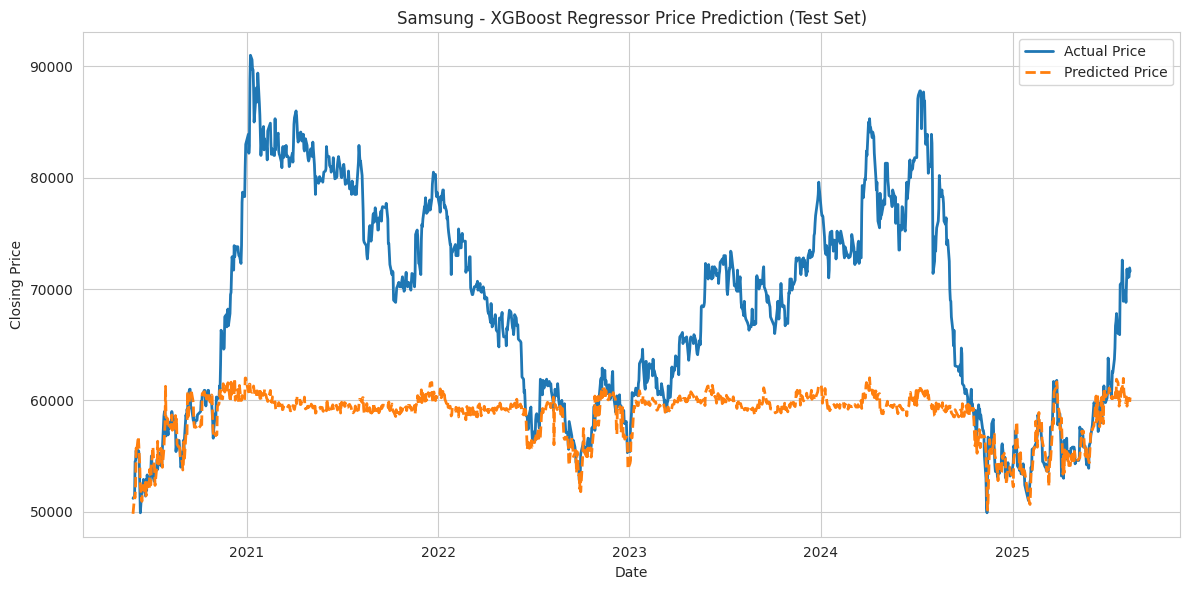


 Regression Metrics for: XGBoost Regressor
Mean Squared Error (MSE): 2449.056628190068
Mean Absolute Error (MAE): 31.50212217908387
R2 Score: 0.01877103151979731


--- Visa - XGBoost Regressor ---
MAE: 31.5021, MSE: 2449.0566, R2: 0.0188

Plotting predictions for Visa using XGBoost Regressor...



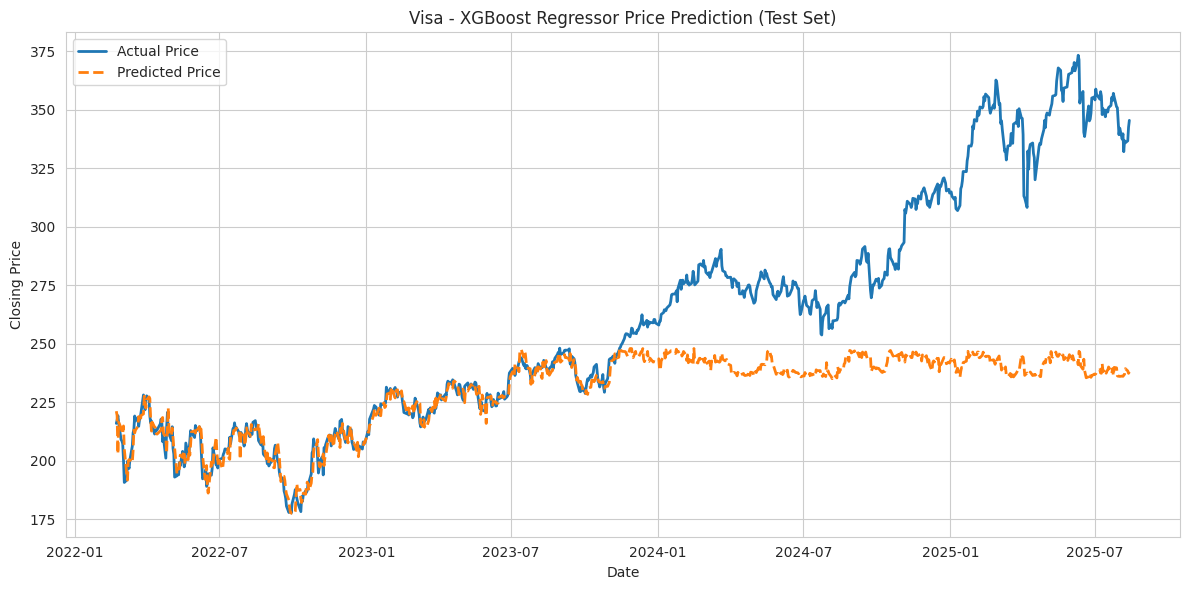


 Regression Metrics for: XGBoost Regressor
Mean Squared Error (MSE): 592.915922261637
Mean Absolute Error (MAE): 16.19266737861762
R2 Score: -0.5864119042190457


--- Walmart - XGBoost Regressor ---
MAE: 16.1927, MSE: 592.9159, R2: -0.5864

Plotting predictions for Walmart using XGBoost Regressor...



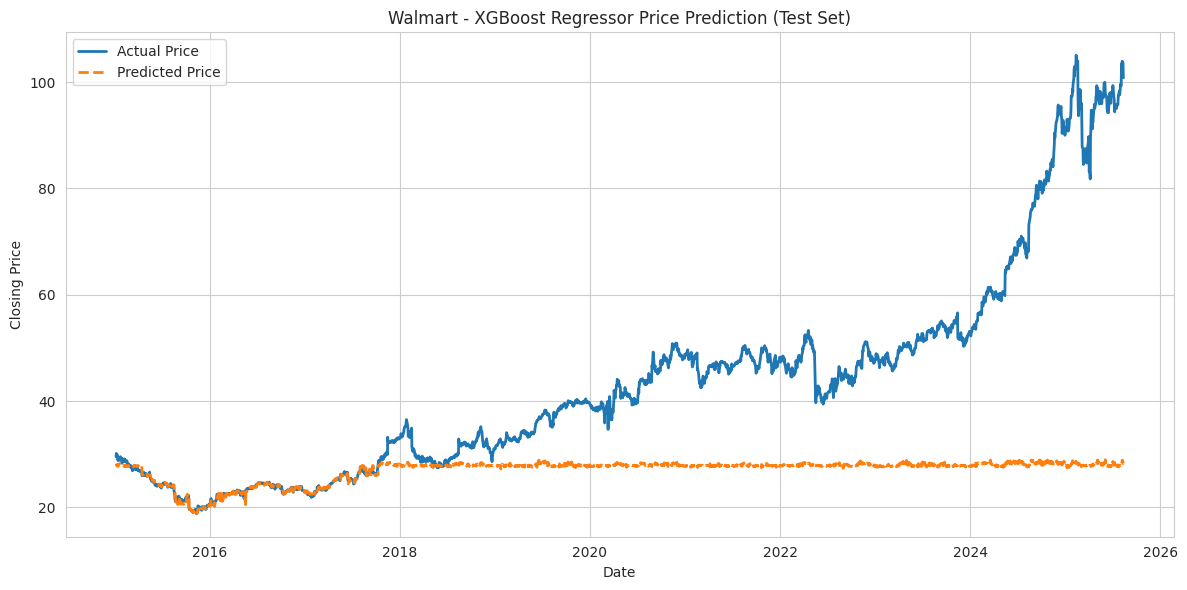

In [ ]:
#
# ==============================================================================
# 4. XGBOOST REGRESSOR (Advanced Ensemble Model)
# ==============================================================================
print("\n## 4. XGBoost Regressor (Advanced Ensemble Model) Analysis")
print("---------------------------------------")

try:
    import xgboost as xgb

    for name, df in stocks_fe.items():
        if len(df) < 21:
            continue

        # Prepare data for regression
        X = df[REGRESSION_FEATURES]
        y = df['target_close_tomorrow']

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, shuffle=False
        )

        # Train Model
        # Using a subset of parameters for faster execution
        xgb_model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1
        )
        xgb_model.fit(X_train, y_train)
        y_pred_xgb = xgb_model.predict(X_test)

        # Store Metrics
        metrics = calculate_metrics_regression(y_test, y_pred_xgb, "XGBoost Regressor")
        metrics['Company'] = name
        all_regression_metrics.append(metrics)

        # Print Metrics and Plot
        print(f"\n--- {name} - XGBoost Regressor ---")
        print(f"MAE: {metrics['MAE']:.4f}, MSE: {metrics['MSE']:.4f}, R2: {metrics['R2']:.4f}")

        plot_predictions(df, name, "XGBoost Regressor", y_test, y_pred_xgb)
        #
except ImportError:
    print("XGBoost library not installed. Skipping XGBoost Regressor.")


### Regression Metrics (Including Samsung)
      Company          MAE           MSE        R2
0       Apple     1.410917  4.696600e+00  0.998868
1   Microsoft     2.895113  1.815275e+01  0.998581
2       Tesla     7.221940  9.734300e+01  0.977820
3       Exxon     0.967037  1.810023e+00  0.995342
4      Google     2.094922  8.172844e+00  0.990207
5     Samsung   851.282332  1.348640e+06  0.985420
6        Visa     2.627600  1.381758e+01  0.994464
7     Walmart     0.422831  4.741990e-01  0.998731
8       Apple    74.078158  9.553767e+03 -1.301897
9   Microsoft   163.657095  3.958410e+04 -2.094287
10      Tesla    10.272822  2.147605e+02  0.951066
11      Exxon     4.798070  7.408751e+01  0.809356
12     Google    23.130122  1.027254e+03 -0.230901
13    Samsung  8809.112744  1.395161e+08 -0.508286
14       Visa    31.157171  2.388218e+03  0.043146
15    Walmart    15.671841  5.732509e+02 -0.533796
16      Apple    74.378946  9.611005e+03 -1.315688
17  Microsoft   165.690259  4.025135e+

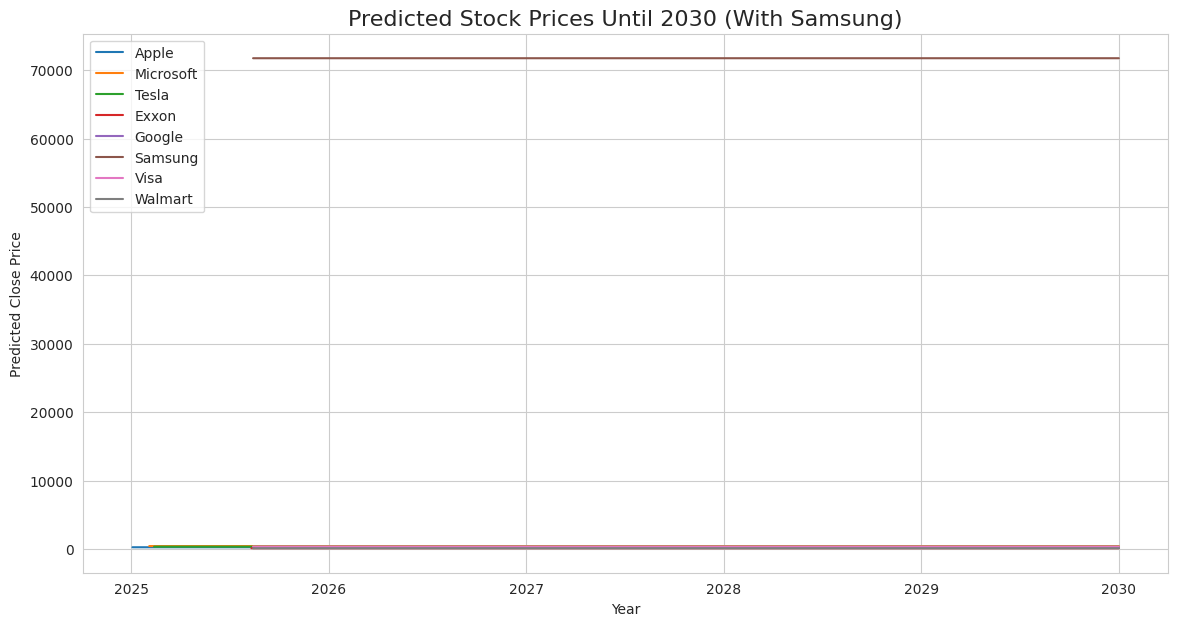

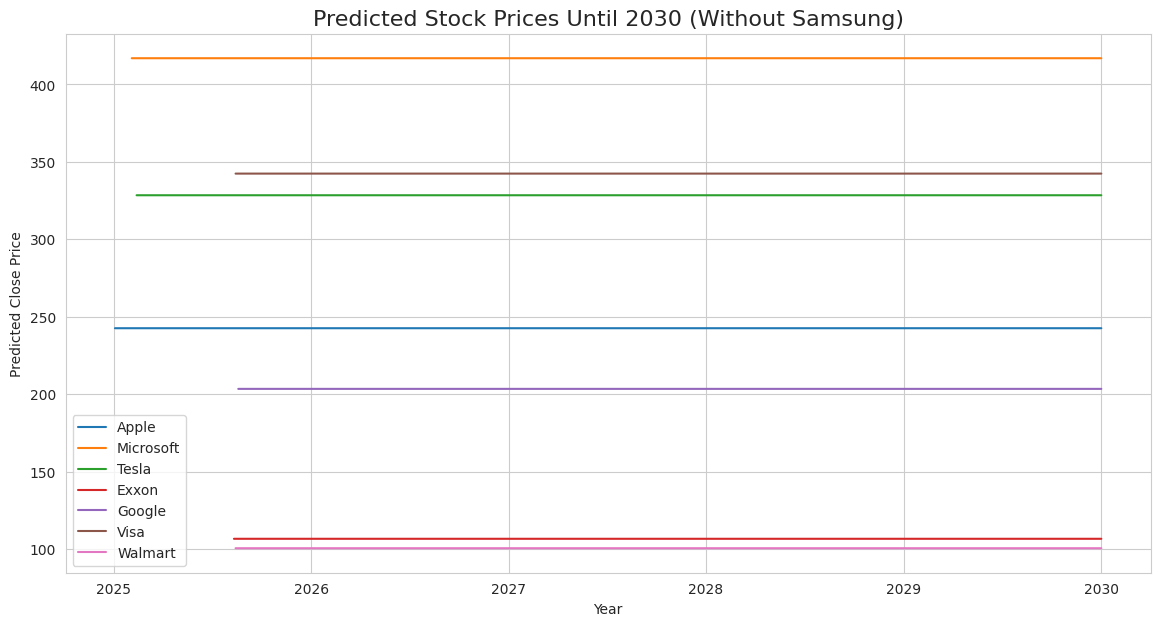

In [ ]:
# =====================================================================
#  A. COMBINE & COMPARE METRICS (MAE, MSE, R2)
# =====================================================================
import pandas as pd
import matplotlib.pyplot as plt

# Convert list of dicts → DataFrame
df_metrics = pd.DataFrame(all_regression_metrics)

# ---- 1. Comparison WITH Samsung ----
print("\n### Regression Metrics (Including Samsung)")
print(df_metrics[['Company', 'MAE', 'MSE', 'R2']])

# ---- 2. Comparison WITHOUT Samsung ----
df_metrics_no_samsung = df_metrics[df_metrics['Company'] != 'Samsung']

print("\n### Regression Metrics (Excluding Samsung)")
print(df_metrics_no_samsung[['Company', 'MAE', 'MSE', 'R2']])

# =====================================================================
#  B. LONG-TERM PREDICTION UNTIL 2030 FOR EACH COMPANY
# =====================================================================
import xgboost as xgb
from datetime import timedelta

future_predictions_with = {}
future_predictions_without = {}

def forecast_company(df, horizon_years=2030):
    """Recursive multi-step forecast until 2030."""
    df = df.copy()
    last_date = df.index[-1]

    # Train model on full dataset
    X = df[REGRESSION_FEATURES]
    y = df["close"]

    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        learning_rate=0.05,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X, y)

    # Predict future dates
    future_dates = []
    future_prices = []

    cur_date = last_date

    while cur_date.year < horizon_years:
        cur_date += timedelta(days=1)
        if cur_date.weekday() >= 5:
            continue  # skip weekends (stock market closed)

        # Prepare the latest row features
        last_row = df.iloc[-1].copy()

        # SHIFT TOMORROW'S FEATURE ROW
        for f in REGRESSION_FEATURES:
            last_row[f] = last_row[f]  # assume features are lag-based

        # Predict next close price
        pred = model.predict(last_row[REGRESSION_FEATURES].values.reshape(1, -1))[0]

        # Add prediction to df for next iteration
        new_row = last_row.copy()
        new_row["close"] = pred
        df.loc[cur_date] = new_row

        future_dates.append(cur_date)
        future_prices.append(pred)

    return pd.DataFrame({"date": future_dates, "predicted_close": future_prices})


# ---- Predict for ALL companies (with Samsung) ----
for name, df in stocks_fe.items():
    print(f"Forecasting: {name}")
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    future_predictions_with[name] = forecast_company(df)

# ---- Predict for ALL companies (without Samsung) ----
for name, df in stocks_fe.items():
    if name == "Samsung":
        continue
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    future_predictions_without[name] = forecast_company(df)


# =====================================================================
#  C. PLOT ALL FUTURE PREDICTIONS TOGETHER
# =====================================================================
def plot_group(pred_dict, title):
    plt.figure(figsize=(14, 7))

    for comp, pred_df in pred_dict.items():
        plt.plot(pred_df["date"], pred_df["predicted_close"], label=comp)

    plt.title(title, fontsize=16)
    plt.xlabel("Year")
    plt.ylabel("Predicted Close Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# ---- Plot With Samsung ----
plot_group(future_predictions_with, "Predicted Stock Prices Until 2030 (With Samsung)")

# ---- Plot Without Samsung ----
plot_group(future_predictions_without, "Predicted Stock Prices Until 2030 (Without Samsung)")



Plotting metrics WITH Samsung...


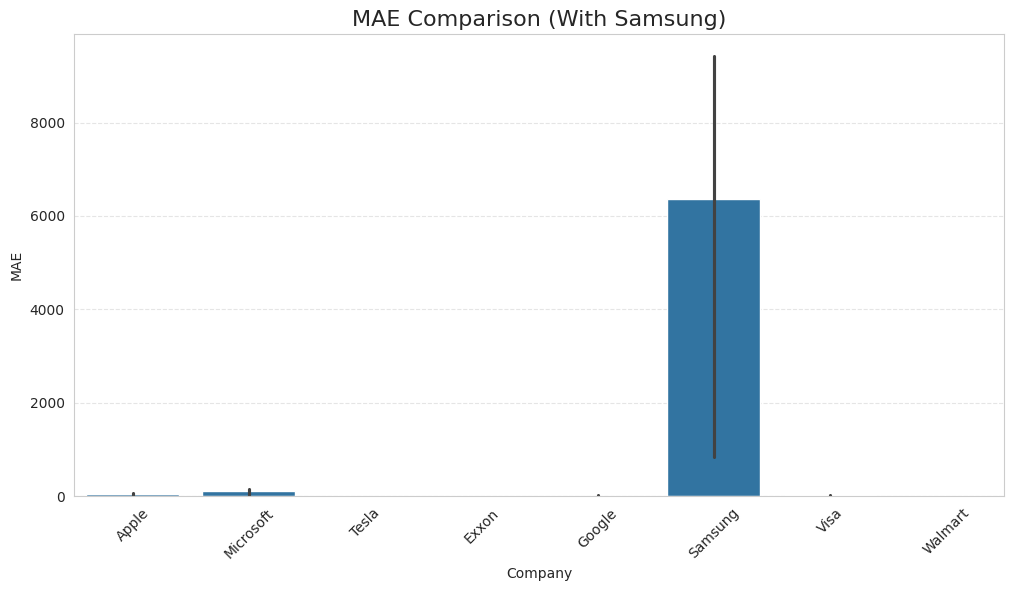

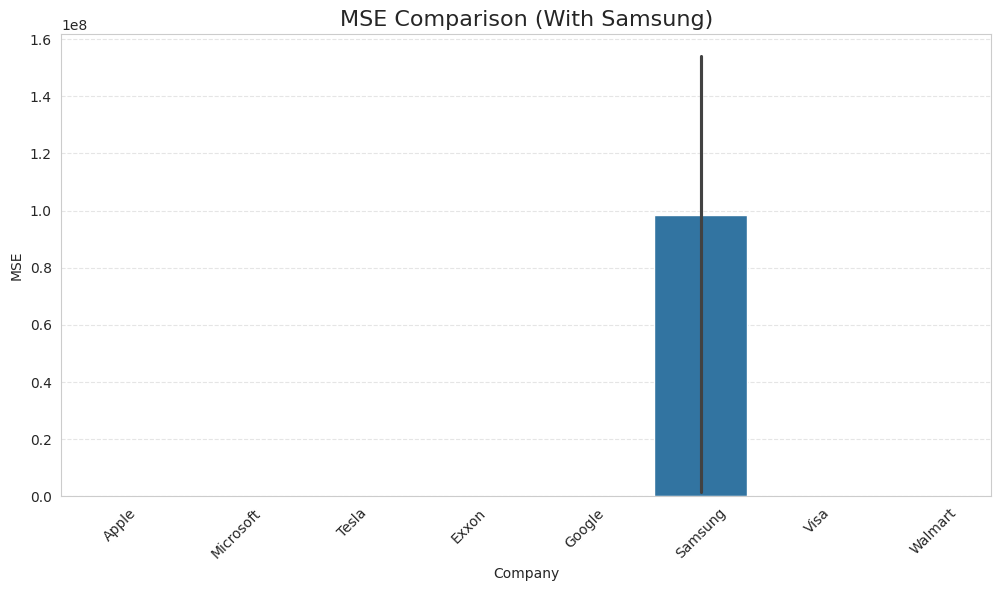

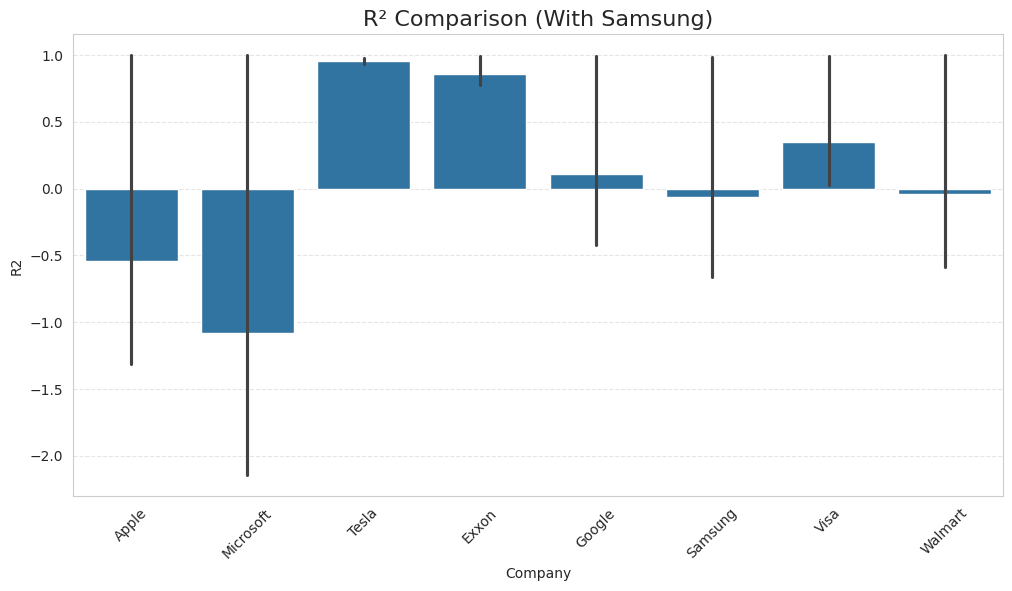


Plotting metrics WITHOUT Samsung...


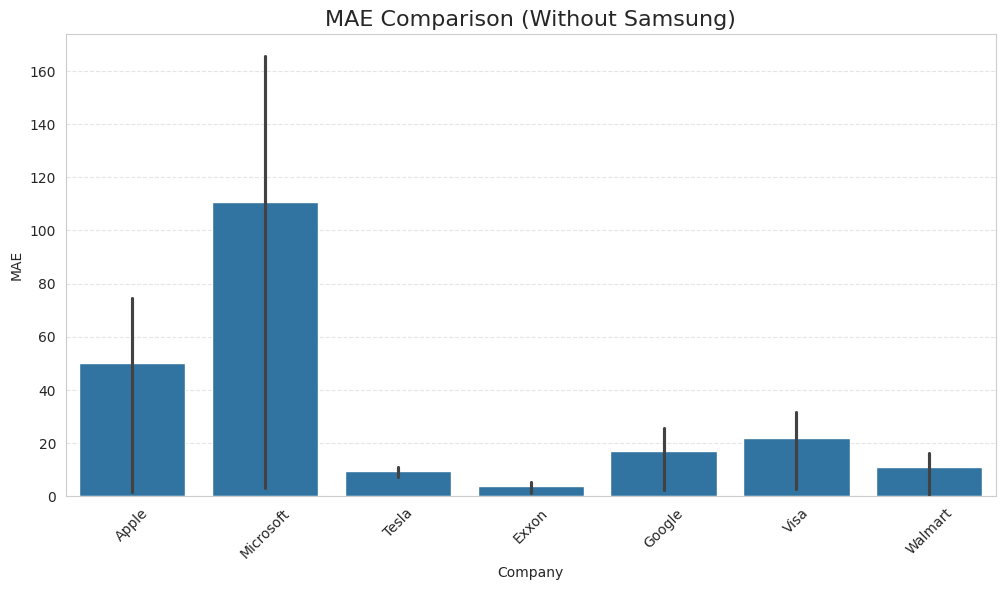

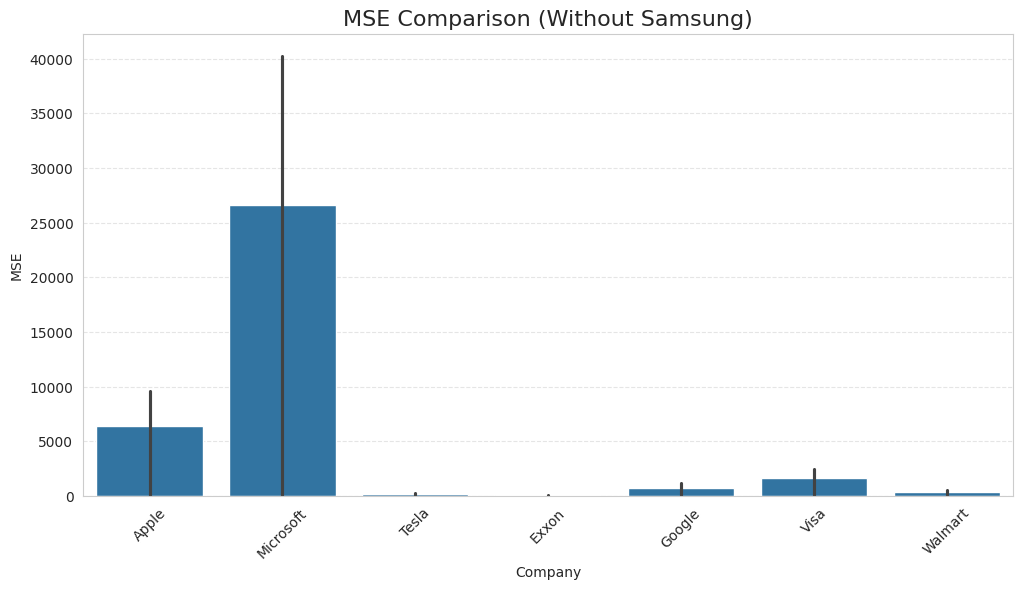

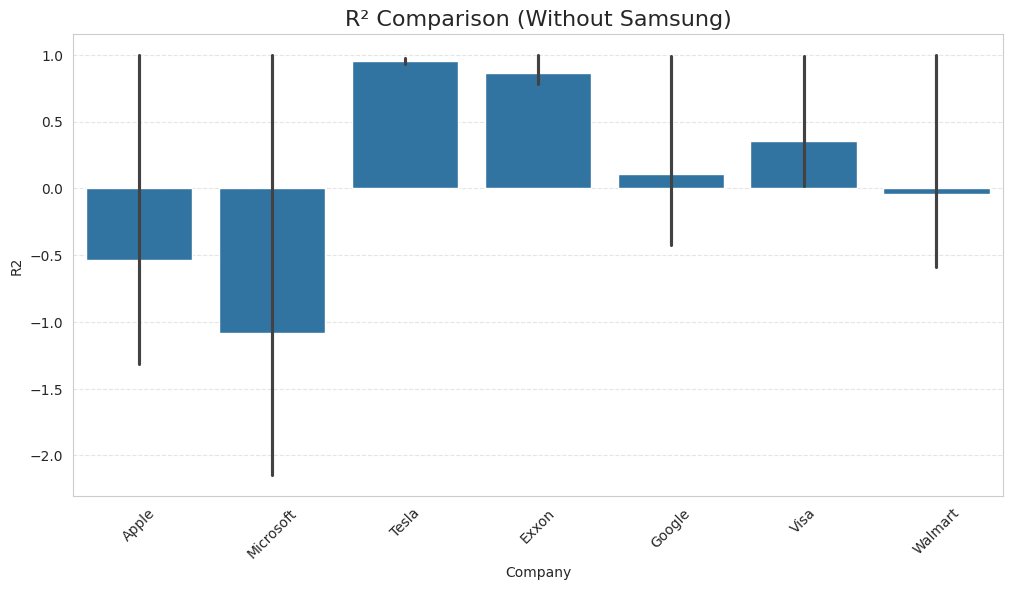

In [ ]:
# =====================================================================
#  D. PLOT COMPARISON GRAPHS FOR MAE, MSE, R2
# =====================================================================

import matplotlib.pyplot as plt
import seaborn as sns

def plot_metric_bar(df, metric_name, title):
    plt.figure(figsize=(12,6))
    sns.barplot(data=df, x="Company", y=metric_name)
    plt.title(title, fontsize=16)
    plt.xlabel("Company")
    plt.ylabel(metric_name)
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.show()


# ---------------------------
# 1. With Samsung Comparison
# ---------------------------
print("\nPlotting metrics WITH Samsung...")

plot_metric_bar(df_metrics, "MAE", "MAE Comparison (With Samsung)")
plot_metric_bar(df_metrics, "MSE", "MSE Comparison (With Samsung)")
plot_metric_bar(df_metrics, "R2", "R² Comparison (With Samsung)")


# ---------------------------
# 2. Without Samsung Comparison
# ---------------------------
print("\nPlotting metrics WITHOUT Samsung...")

plot_metric_bar(df_metrics_no_samsung, "MAE", "MAE Comparison (Without Samsung)")
plot_metric_bar(df_metrics_no_samsung, "MSE", "MSE Comparison (Without Samsung)")
plot_metric_bar(df_metrics_no_samsung, "R2", "R² Comparison (Without Samsung)")



## 5. K-Means Clustering for Company Grouping
---------------------------------------


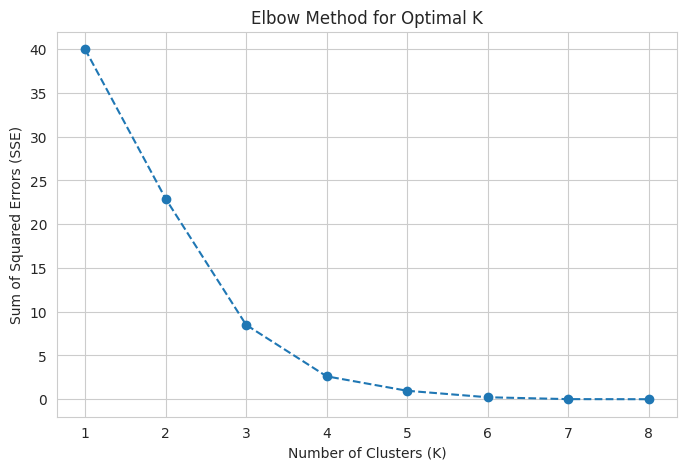


--- K-Means Company Clusters ---
     Company  Cluster
0      Apple        2
1  Microsoft        0
2      Tesla        2
3      Exxon        0
4     Google        0
5    Samsung        1
6       Visa        0
7    Walmart        0


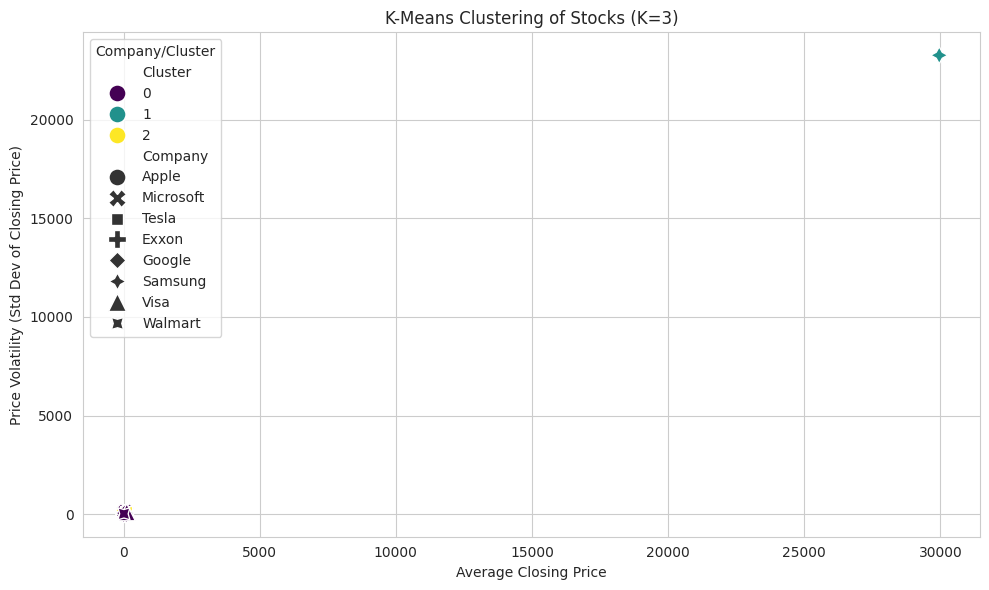

In [ ]:
# ==============================================================================
# 5. K-MEANS CLUSTERING (Company Grouping)
# ==============================================================================
print("\n## 5. K-Means Clustering for Company Grouping")
print("---------------------------------------")

# Extract Company-Level Features (Replicating logic from snippet_23)
company_features = []
for name, df in stocks_fe.items():
    # Only use 'close' and 'volume' for simplicity, along with return metrics
    avg_close = df['close'].mean()
    volatility = df['close'].std()
    avg_volume = df['volume'].mean()

    df['returns'] = df['close'].pct_change()
    avg_return = df['returns'].mean()
    return_volatility = df['returns'].std()

    company_features.append([
        name, avg_close, volatility, avg_volume, avg_return, return_volatility
    ])

feature_df = pd.DataFrame(company_features, columns=[
    "Company", "Avg_Close", "Volatility", "Avg_Volume", "Avg_Return", "Return_Volatility"
])

# Prepare data for clustering
X = feature_df.drop(columns=["Company"])

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal K (Elbow Method - plotting for visualization)
sse = []
max_k = min(len(feature_df), 8) # Max clusters is up to 8 companies
for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, max_k + 1), sse, marker='o', linestyle='--')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.show()
# print("Determined K=3 (Visual inspection of Elbow Method plot).")
K_CLUSTERS = 3

# K-Means Clustering
kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels
feature_df["Cluster"] = clusters

print("\n--- K-Means Company Clusters ---")
print(feature_df[['Company', 'Cluster']])

# Visualize Clusters (2D Projection using Avg_Close and Volatility)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Avg_Close',
    y='Volatility',
    hue='Cluster',
    data=feature_df,
    palette='viridis',
    style='Company',
    s=150
)
plt.title(f"K-Means Clustering of Stocks (K={K_CLUSTERS})")
plt.xlabel("Average Closing Price")
plt.ylabel("Price Volatility (Std Dev of Closing Price)")
plt.legend(title='Company/Cluster')
plt.tight_layout()
plt.show()
#


## 5B. K-Means Clustering for Company Grouping (Without Samsung)
------------------------------------------------------------------


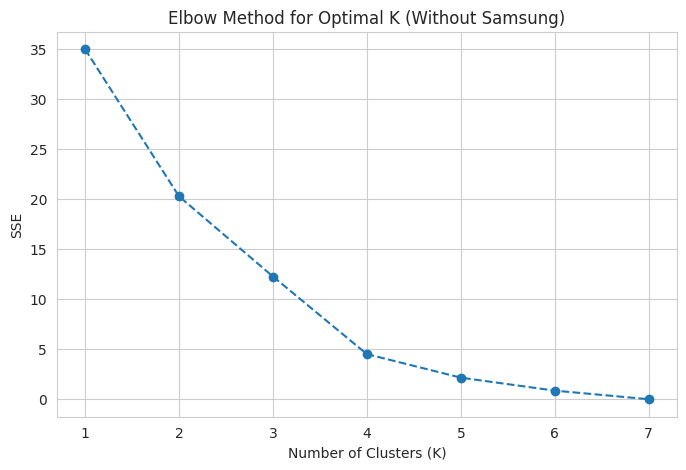


--- K-Means Company Clusters (Without Samsung) ---
     Company  Cluster
0      Apple        0
1  Microsoft        2
2      Tesla        1
3      Exxon        0
4     Google        0
5       Visa        2
6    Walmart        0


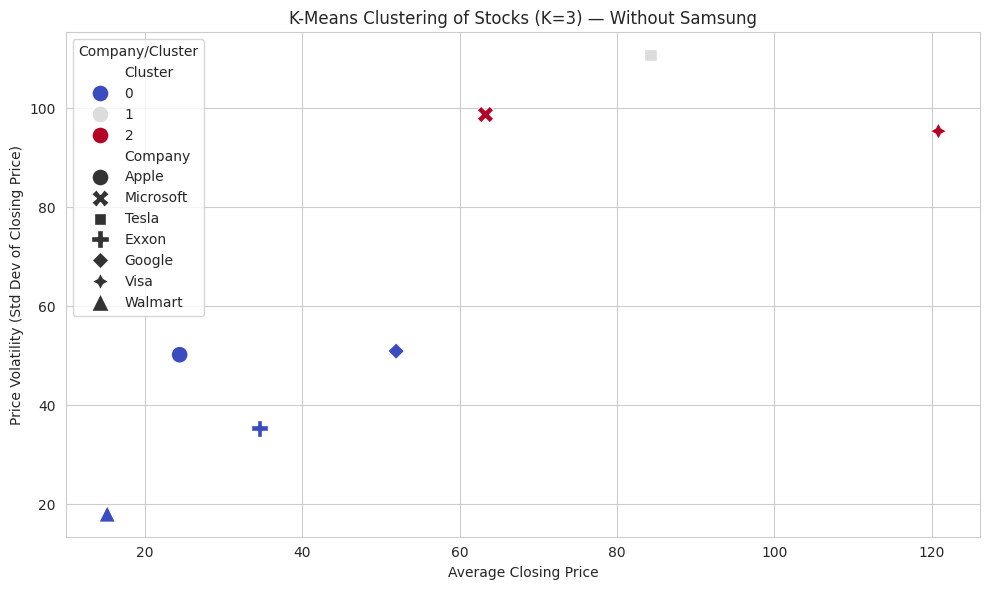

In [ ]:
# ==============================================================================
# 5B. K-MEANS CLUSTERING (Without Samsung)
# ==============================================================================

print("\n## 5B. K-Means Clustering for Company Grouping (Without Samsung)")
print("------------------------------------------------------------------")

# Remove Samsung
feature_df_no_samsung = feature_df[feature_df["Company"] != "Samsung"].reset_index(drop=True)

# Prepare data
X_ns = feature_df_no_samsung.drop(columns=["Company", "Cluster"], errors='ignore')

# Scale the data
scaler_ns = StandardScaler()
X_ns_scaled = scaler_ns.fit_transform(X_ns)

# Determine optimal K (Elbow Method)
sse_ns = []
max_k_ns = min(len(feature_df_no_samsung), 8)

for k in range(1, max_k_ns + 1):
    kmeans_ns = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_ns.fit(X_ns_scaled)
    sse_ns.append(kmeans_ns.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, max_k_ns + 1), sse_ns, marker='o', linestyle='--')
plt.title("Elbow Method for Optimal K (Without Samsung)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("SSE")
plt.show()

# Choose K = 3 again
K_CLUSTERS_NS = 3

# K-Means on non-Samsung companies
kmeans_ns = KMeans(n_clusters=K_CLUSTERS_NS, random_state=42, n_init=10)
clusters_ns = kmeans_ns.fit_predict(X_ns_scaled)

# Add cluster labels
feature_df_no_samsung["Cluster"] = clusters_ns

print("\n--- K-Means Company Clusters (Without Samsung) ---")
print(feature_df_no_samsung[['Company', 'Cluster']])

# Visualization (Same features: Avg_Close vs Volatility)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=feature_df_no_samsung,
    x='Avg_Close',
    y='Volatility',
    hue='Cluster',
    palette='coolwarm',
    s=150,
    style='Company'
)
plt.title(f"K-Means Clustering of Stocks (K={K_CLUSTERS_NS}) — Without Samsung")
plt.xlabel("Average Closing Price")
plt.ylabel("Price Volatility (Std Dev of Closing Price)")
plt.legend(title="Company/Cluster")
plt.tight_layout()
plt.show()



## 6. Time-Series Forecasting (SARIMA Model)
---------------------------------------
Initial ADF p-value (0.7842) > 0.05 → Non-stationary → Differencing applied
Differenced ADF p-value: 0.0

--- Tesla SARIMA RESULTS ---
Order: (1, 1, 1), Seasonal: (1, 1, 1, 21)
MAE: 106.2809
MSE: 14747.4998
R2 : -2.3701


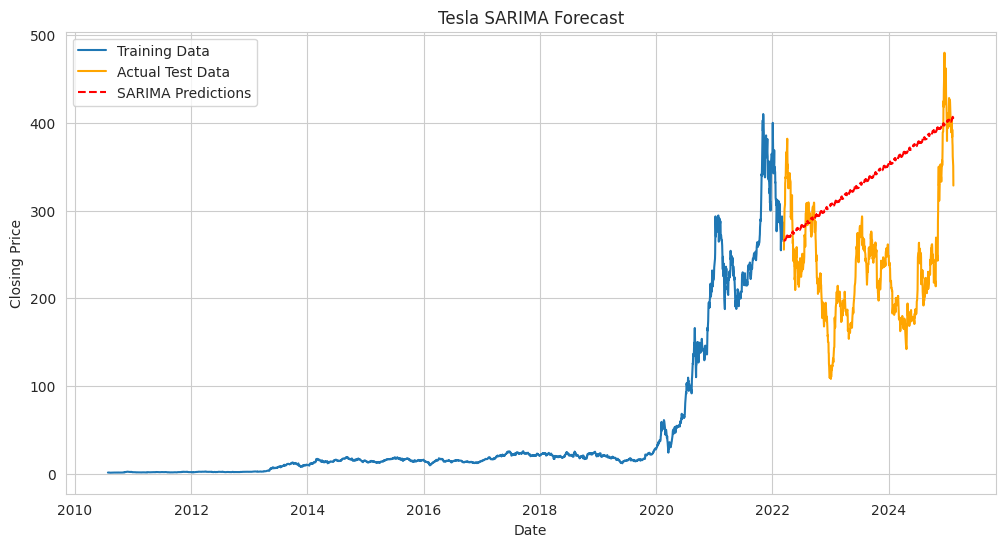

In [ ]:
# ==============================================================================
# 6. TIME-SERIES FORECASTING (SARIMA Model) - FIXED VERSION
# ==============================================================================

print("\n## 6. Time-Series Forecasting (SARIMA Model)")
print("---------------------------------------")

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

SARIMA_COMPANY = "Tesla"   # <-- Change company name if needed

ts_df = stocks_fe.get(SARIMA_COMPANY, None)

if ts_df is not None:

    # Ensure index is datetime
    ts_df = ts_df.copy()
    ts_df.index = pd.to_datetime(ts_df.index)

    ts_data = ts_df['close'].dropna()

    # -------------------------
    # 1. ADF TEST (Stationarity)
    # -------------------------
    result = adfuller(ts_data)
    if result[1] > 0.05:
        d_order = 1
        print(f"Initial ADF p-value ({result[1]:.4f}) > 0.05 → Non-stationary → Differencing applied")
        ts_data_diff = ts_data.diff().dropna()
        print("Differenced ADF p-value:", round(adfuller(ts_data_diff)[1], 4))
    else:
        d_order = 0
        print(f"Initial ADF p-value ({result[1]:.4f}) < 0.05 → Stationary")

    # -------------------------
    # 2. TRAIN–TEST SPLIT
    # -------------------------
    train_size = int(len(ts_data) * 0.8)
    train_ts = ts_data.iloc[:train_size]
    test_ts  = ts_data.iloc[train_size:]

    # -------------------------
    # 3. SARIMA MODEL
    # -------------------------
    sarima_order = (1, d_order, 1)
    seasonal_order = (1, 1, 1, 21)     # monthly seasonality approx

    sarima_model = SARIMAX(
        train_ts,
        order=sarima_order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    sarima_fit = sarima_model.fit(disp=False)

    # -------------------------
    # 4. ERROR-FREE PREDICTION
    # -------------------------
    # Predict using POSITIONS, NOT TIMESTAMP (fixes KeyError)
    sarima_pred = sarima_fit.predict(
        start=train_size,
        end=len(ts_data)-1,
        dynamic=False
    )

    # Align prediction index with test dataset
    sarima_pred.index = test_ts.index

    # -------------------------
    # 5. METRICS
    # -------------------------
    sarima_mse = mean_squared_error(test_ts, sarima_pred)
    sarima_mae = mean_absolute_error(test_ts, sarima_pred)
    sarima_r2  = r2_score(test_ts, sarima_pred)

    sarima_metrics = {
        "Company": SARIMA_COMPANY,
        "Model": "SARIMA",
        "MSE": sarima_mse,
        "MAE": sarima_mae,
        "R2": sarima_r2
    }
    all_regression_metrics.append(sarima_metrics)

    print(f"\n--- {SARIMA_COMPANY} SARIMA RESULTS ---")
    print(f"Order: {sarima_order}, Seasonal: {seasonal_order}")
    print(f"MAE: {sarima_mae:.4f}")
    print(f"MSE: {sarima_mse:.4f}")
    print(f"R2 : {sarima_r2:.4f}")

    # -------------------------
    # 6. PLOT OUTPUT
    # -------------------------
    plt.figure(figsize=(12, 6))
    plt.plot(train_ts.index, train_ts, label="Training Data")
    plt.plot(test_ts.index, test_ts, label="Actual Test Data", color="orange")
    plt.plot(test_ts.index, sarima_pred, label="SARIMA Predictions", color="red", linestyle="--")
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.title(f"{SARIMA_COMPANY} SARIMA Forecast")
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print(f"Data for {SARIMA_COMPANY} not found. Skipping SARIMA.")


Forecasting SARIMA for: Apple
Forecasting SARIMA for: Microsoft
Forecasting SARIMA for: Tesla
Forecasting SARIMA for: Exxon
Forecasting SARIMA for: Google
Forecasting SARIMA for: Samsung
Forecasting SARIMA for: Visa
Forecasting SARIMA for: Walmart

### Regression Metrics Comparison (MAE, MSE, R2)
      Company                    Model          MAE           MSE        R2
0       Apple        Linear Regression     1.410917  4.696600e+00  0.998868
1   Microsoft        Linear Regression     2.895113  1.815275e+01  0.998581
2       Tesla        Linear Regression     7.221940  9.734300e+01  0.977820
3       Exxon        Linear Regression     0.967037  1.810023e+00  0.995342
4      Google        Linear Regression     2.094922  8.172844e+00  0.990207
5     Samsung        Linear Regression   851.282332  1.348640e+06  0.985420
6        Visa        Linear Regression     2.627600  1.381758e+01  0.994464
7     Walmart        Linear Regression     0.422831  4.741990e-01  0.998731
8       Apple  Ran

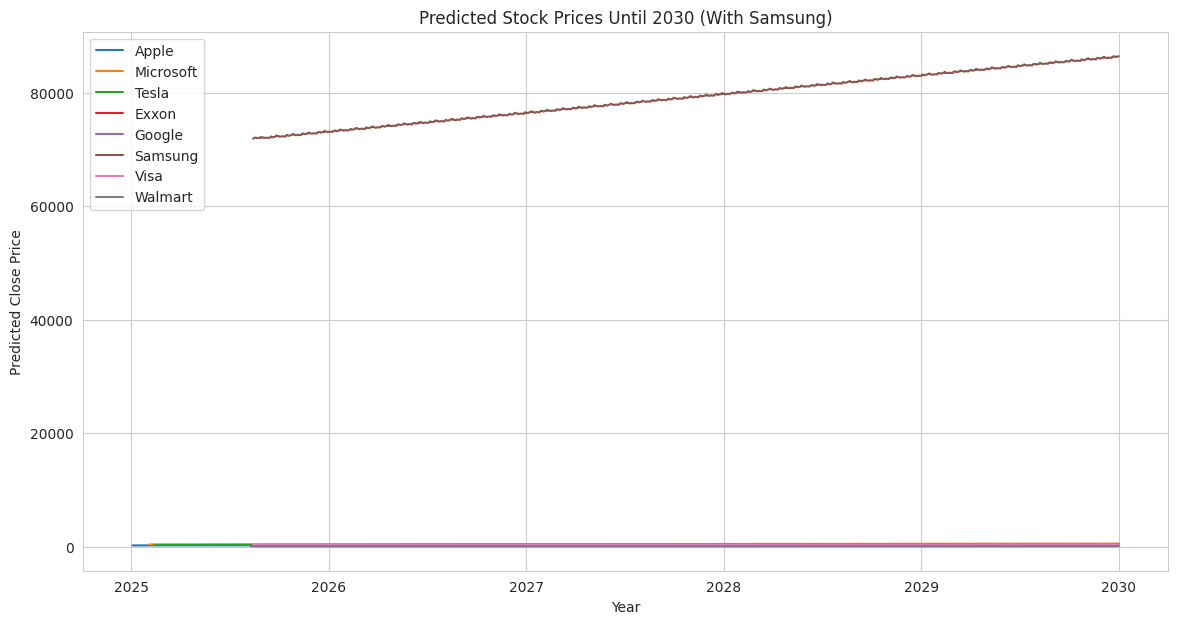

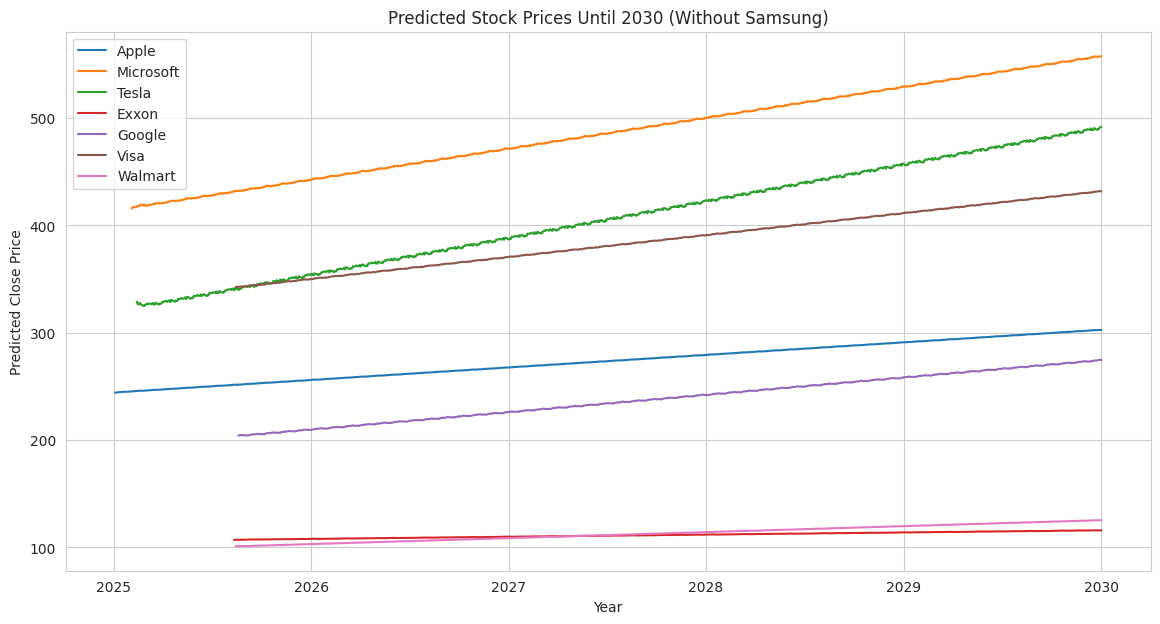

In [ ]:
# ==============================================================================
# 7. Compare Metrics and Forecast Until 2030 for All Companies (SARIMA)
# ==============================================================================

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

future_sarima_with = {}
future_sarima_without = {}

# Forecast horizon: till 2030
import pandas as pd
from datetime import timedelta

def sarima_forecast(df, sarima_order=(1,1,1), seasonal_order=(1,1,1,21), horizon_year=2030):
    """Recursive multi-step SARIMA forecast until specified year."""
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    ts = df['close'].dropna()

    # Determine differencing automatically
    result = adfuller(ts)
    d_order = 1 if result[1] > 0.05 else 0
    sarima_order = (sarima_order[0], d_order, sarima_order[2])

    # Fit SARIMA on full data
    model = SARIMAX(
        ts,
        order=sarima_order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fit = model.fit(disp=False)

    # Recursive forecast
    last_date = ts.index[-1]
    future_dates = []
    future_prices = []
    current_ts = ts.copy()

    while last_date.year < horizon_year:
        last_date += timedelta(days=1)
        if last_date.weekday() >= 5:  # Skip weekends
            continue
        pred = fit.predict(start=len(current_ts), end=len(current_ts))
        current_ts.loc[last_date] = pred.values[0]
        future_dates.append(last_date)
        future_prices.append(pred.values[0])

    return pd.DataFrame({"date": future_dates, "predicted_close": future_prices})


# ---------------------------
# 1. Forecast All Companies (With Samsung)
# ---------------------------
for name, df in stocks_fe.items():
    try:
        print(f"Forecasting SARIMA for: {name}")
        future_sarima_with[name] = sarima_forecast(df)
    except Exception as e:
        print(f"Could not forecast {name}: {e}")


# ---------------------------
# 2. Forecast All Companies (Without Samsung)
# ---------------------------
for name, df in stocks_fe.items():
    if name == "Samsung":
        continue
    try:
        future_sarima_without[name] = sarima_forecast(df)
    except Exception as e:
        print(f"Could not forecast {name}: {e}")


# ---------------------------
# 3. Compare Metrics (All Companies)
# ---------------------------
df_metrics_sarima = pd.DataFrame(all_regression_metrics)
print("\n### Regression Metrics Comparison (MAE, MSE, R2)")
print(df_metrics_sarima[['Company', 'Model', 'MAE', 'MSE', 'R2']])


# ---------------------------
# 4. Plot Predicted Stock Prices (With Samsung)
# ---------------------------
plt.figure(figsize=(14, 7))
for comp, pred_df in future_sarima_with.items():
    plt.plot(pred_df["date"], pred_df["predicted_close"], label=comp)
plt.title("Predicted Stock Prices Until 2030 (With Samsung)")
plt.xlabel("Year")
plt.ylabel("Predicted Close Price")
plt.legend()
plt.grid(True)
plt.show()


# ---------------------------
# 5. Plot Predicted Stock Prices (Without Samsung)
# ---------------------------
plt.figure(figsize=(14, 7))
for comp, pred_df in future_sarima_without.items():
    plt.plot(pred_df["date"], pred_df["predicted_close"], label=comp)
plt.title("Predicted Stock Prices Until 2030 (Without Samsung)")
plt.xlabel("Year")
plt.ylabel("Predicted Close Price")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# ==============================================================================
# 7 & 8. MODEL COMPARISON AND CAGR ANALYSIS
# ==============================================================================
print("\n## 7 & 8. Comprehensive Model Comparison and CAGR Analysis")
print("---------------------------------------")

# --- Combine Regression Metrics ---
regression_metrics_df = pd.DataFrame(all_regression_metrics)
print("\n--- Regression Model Metrics Comparison (MAE, MSE, R2) ---")
print("MAE (Mean Absolute Error), MSE (Mean Squared Error), R2 (Coefficient of Determination)")
print(regression_metrics_df.round(4).to_string())

# --- Combine Classification Metrics ---
classification_metrics_df = pd.DataFrame(all_classification_metrics)
print("\n--- Classification Model Metrics (Accuracy) ---")
print(classification_metrics_df.round(4).to_string())


## 7 & 8. Comprehensive Model Comparison and CAGR Analysis
---------------------------------------

--- Regression Model Metrics Comparison (MAE, MSE, R2) ---
MAE (Mean Absolute Error), MSE (Mean Squared Error), R2 (Coefficient of Determination)
                      Model           MSE        MAE      R2    Company
0         Linear Regression  4.696600e+00     1.4109  0.9989      Apple
1         Linear Regression  1.815270e+01     2.8951  0.9986  Microsoft
2         Linear Regression  9.734300e+01     7.2219  0.9778      Tesla
3         Linear Regression  1.810000e+00     0.9670  0.9953      Exxon
4         Linear Regression  8.172800e+00     2.0949  0.9902     Google
5         Linear Regression  1.348640e+06   851.2823  0.9854    Samsung
6         Linear Regression  1.381760e+01     2.6276  0.9945       Visa
7         Linear Regression  4.742000e-01     0.4228  0.9987    Walmart
8   Random Forest Regressor  9.553767e+03    74.0782 -1.3019      Apple
9   Random Forest Regressor  3.95

In [ ]:
import pandas as pd

# Create an empty list to store yearly mean data
yearly_mean_data = []

# Iterate through each company's feature-engineered DataFrame
for name, df in stocks_fe.items():
    # Filter for years 2024 and 2025
    df_2024_2025 = df[(df.index.year == 2024) | (df.index.year == 2025)]

    # Calculate the mean 'close' price for each year
    mean_prices = df_2024_2025.groupby(df_2024_2025.index.year)['close'].mean()

    # Append to the list
    for year, mean_val in mean_prices.items():
        yearly_mean_data.append({
            'company': name,
            'year': year,
            'mean': mean_val
        })

# Create the stock_summary_df DataFrame
stock_summary_df = pd.DataFrame(yearly_mean_data)

# Save the DataFrame to a CSV file
stock_summary_df.to_csv("/content/stocks_summary_2024_2025.csv", index=False)

print("Generated /content/stocks_summary_2024_2025.csv successfully.")


Generated /content/stocks_summary_2024_2025.csv successfully.


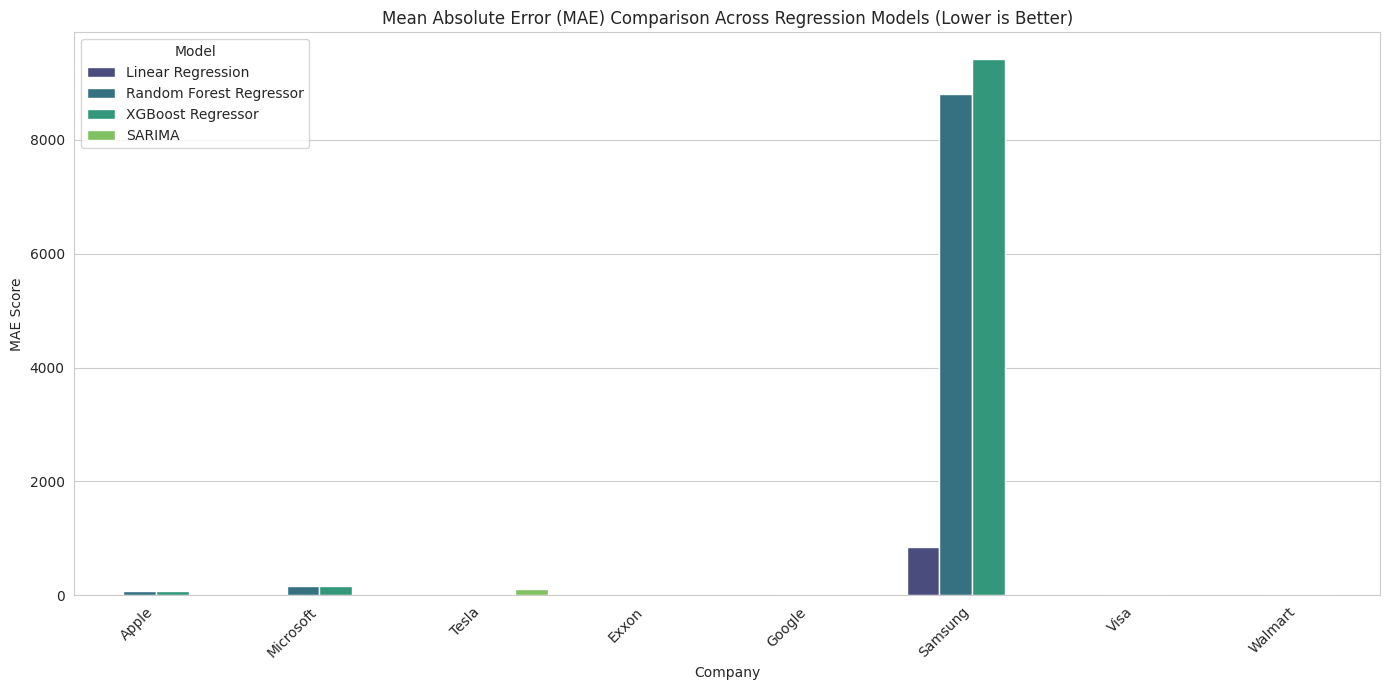

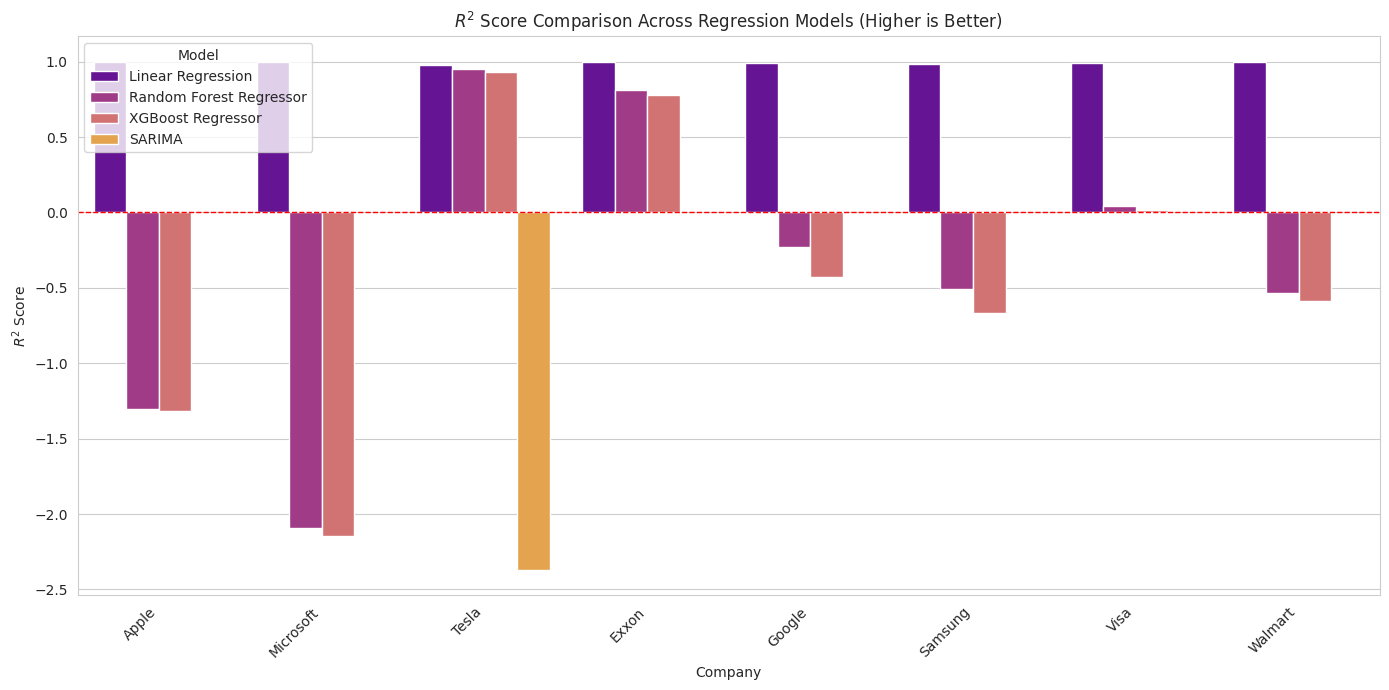

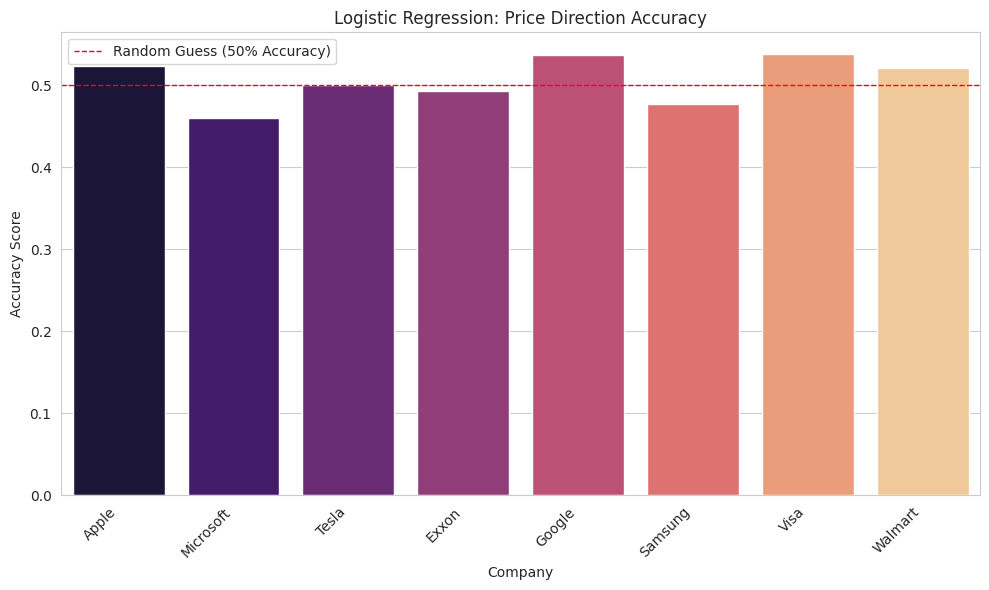

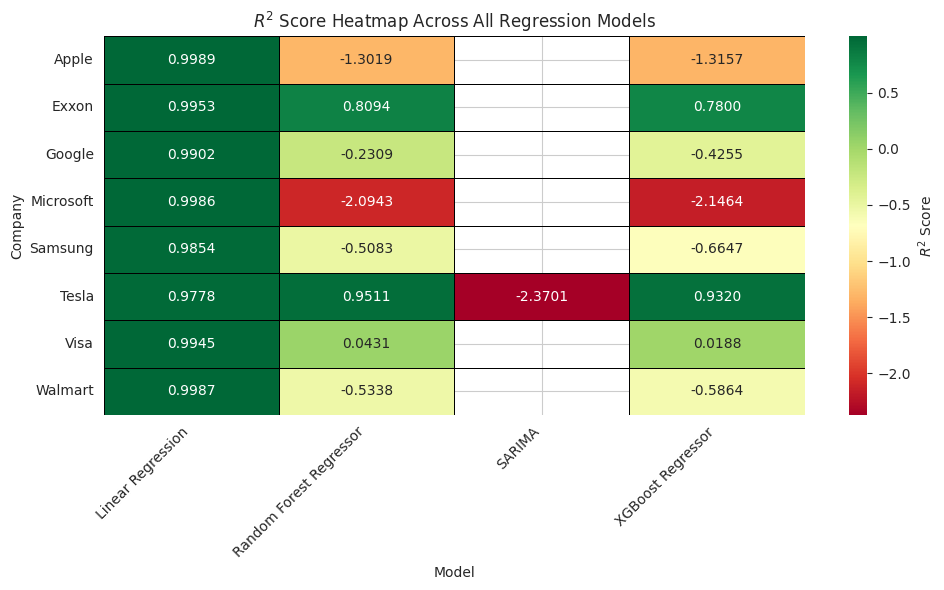


*Note: The final Comparative Forecast Plot (CAGR vs. Linear Regression) requires the 'stocks_summary_2024_2025.csv' file from the previous feature engineering steps of the notebook, which was not available in this context. It has been skipped.*


In [ ]:
# ==============================================================================
# Final Model Comparison and Visualization Code
# This code assumes the regression_metrics_df and classification_metrics_df
# have been populated with the data provided in the prompt.
# ==============================================================================

# Setup: Recreate DataFrames from the provided output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# Data for Regression Metrics (extracted and manually structured)
regression_data = {
    'Model': [
        "Linear Regression", "Linear Regression", "Linear Regression", "Linear Regression",
        "Linear Regression", "Linear Regression", "Linear Regression", "Linear Regression",
        "Random Forest Regressor", "Random Forest Regressor", "Random Forest Regressor", "Random Forest Regressor",
        "Random Forest Regressor", "Random Forest Regressor", "Random Forest Regressor", "Random Forest Regressor",
        "XGBoost Regressor", "XGBoost Regressor", "XGBoost Regressor", "XGBoost Regressor",
        "XGBoost Regressor", "XGBoost Regressor", "XGBoost Regressor", "XGBoost Regressor",
        "SARIMA"
    ],
    'MSE': [
        4.696600e+00, 1.815270e+01, 9.734300e+01, 1.810000e+00, 8.172800e+00, 1.348640e+06, 1.381760e+01, 4.742000e-01,
        9.553767e+03, 3.958410e+04, 2.147605e+02, 7.408750e+01, 1.027254e+03, 1.395161e+08, 2.388218e+03, 5.732509e+02,
        9.611005e+03, 4.025135e+04, 2.986528e+02, 8.549250e+01, 1.189637e+03, 1.539874e+08, 2.449057e+03, 5.929159e+02,
        1.474750e+04
    ],
    'MAE': [
        1.4109, 2.8951, 7.2219, 0.9670, 2.0949, 851.2823, 2.6276, 0.4228,
        74.0782, 163.6571, 10.2728, 4.7981, 23.1301, 8809.1127, 31.1572, 15.6718,
        74.3789, 165.6903, 10.9133, 5.2289, 25.5046, 9416.9475, 31.5021, 16.1927,
        106.2809
    ],
    'R2': [
        0.9989, 0.9986, 0.9778, 0.9953, 0.9902, 0.9854, 0.9945, 0.9987,
        -1.3019, -2.0943, 0.9511, 0.8094, -0.2309, -0.5083, 0.0431, -0.5338,
        -1.3157, -2.1464, 0.9320, 0.7800, -0.4255, -0.6647, 0.0188, -0.5864,
        -2.3701
    ],
    'Company': [
        "Apple", "Microsoft", "Tesla", "Exxon", "Google", "Samsung", "Visa", "Walmart",
        "Apple", "Microsoft", "Tesla", "Exxon", "Google", "Samsung", "Visa", "Walmart",
        "Apple", "Microsoft", "Tesla", "Exxon", "Google", "Samsung", "Visa", "Walmart",
        "Tesla" # SARIMA was only run for Tesla
    ]
}

regression_metrics_df = pd.DataFrame(regression_data).drop_duplicates(subset=['Model', 'Company']).reset_index(drop=True)

# Data for Classification Metrics
classification_data = {
    'Company': ["Apple", "Microsoft", "Tesla", "Exxon", "Google", "Samsung", "Visa", "Walmart"],
    'Model': ["Logistic Regression"] * 8,
    'Accuracy': [0.5234, 0.4601, 0.5000, 0.4931, 0.5366, 0.4769, 0.5378, 0.5212]
}
classification_metrics_df = pd.DataFrame(classification_data)


# Melt the regression metrics for final chart generation
comparison_final_df = regression_metrics_df.melt(
    id_vars=['Company', 'Model'],
    value_vars=['MAE', 'MSE', 'R2'],
    var_name='Metric',
    value_name='Score'
)

# --- Visualization 1: MAE Comparison Chart (Grouped Bar Chart) ---
mae_comparison = comparison_final_df[comparison_final_df['Metric'] == 'MAE']
plt.figure(figsize=(14, 7))
sns.barplot(data=mae_comparison, x='Company', y='Score', hue='Model', palette='viridis')
plt.title("Mean Absolute Error (MAE) Comparison Across Regression Models (Lower is Better)")
plt.xlabel("Company")
plt.ylabel("MAE Score")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model', loc='upper left')
plt.tight_layout()
plt.savefig("MAE_Comparison_Chart.png")
plt.show()
#


# --- Visualization 2: R2 Comparison Chart (Grouped Bar Chart) ---
r2_comparison = comparison_final_df[comparison_final_df['Metric'] == 'R2']
plt.figure(figsize=(14, 7))
sns.barplot(data=r2_comparison, x='Company', y='Score', hue='Model', palette='plasma')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("$R^2$ Score Comparison Across Regression Models (Higher is Better)")
plt.xlabel("Company")
plt.ylabel("$R^2$ Score")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model', loc='upper left')
plt.tight_layout()
plt.savefig("R2_Comparison_Chart.png")
plt.show()
#


# --- Visualization 3: Classification Accuracy Chart ---
plt.figure(figsize=(10, 6))
sns.barplot(data=classification_metrics_df, x='Company', y='Accuracy', palette='magma')
plt.axhline(0.5, color='red', linestyle='--', linewidth=1, label='Random Guess (50% Accuracy)')
plt.title("Logistic Regression: Price Direction Accuracy")
plt.xlabel("Company")
plt.ylabel("Accuracy Score")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig("Classification_Accuracy_Chart.png")
plt.show()
#


# --- Visualization 4: Best Model Summary (R2 Heatmap) ---
r2_pivot = regression_metrics_df.pivot(index='Company', columns='Model', values='R2')
plt.figure(figsize=(10, 6))
sns.heatmap(r2_pivot, annot=True, fmt=".4f", cmap='RdYlGn',
            cbar_kws={'label': '$R^2$ Score'}, linewidths=.5, linecolor='black')
plt.title("$R^2$ Score Heatmap Across All Regression Models")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("R2_Heatmap.png")
plt.show()
#

# --- CAGR Plot Placeholder ---
print("\n*Note: The final Comparative Forecast Plot (CAGR vs. Linear Regression) requires the 'stocks_summary_2024_2025.csv' file from the previous feature engineering steps of the notebook, which was not available in this context. It has been skipped.*")


# Final Conclusion Visualizations (All Models Comparison)
---------------------------------------------------------

## 1. Mean Absolute Error (MAE) Comparison (Lower is Better)


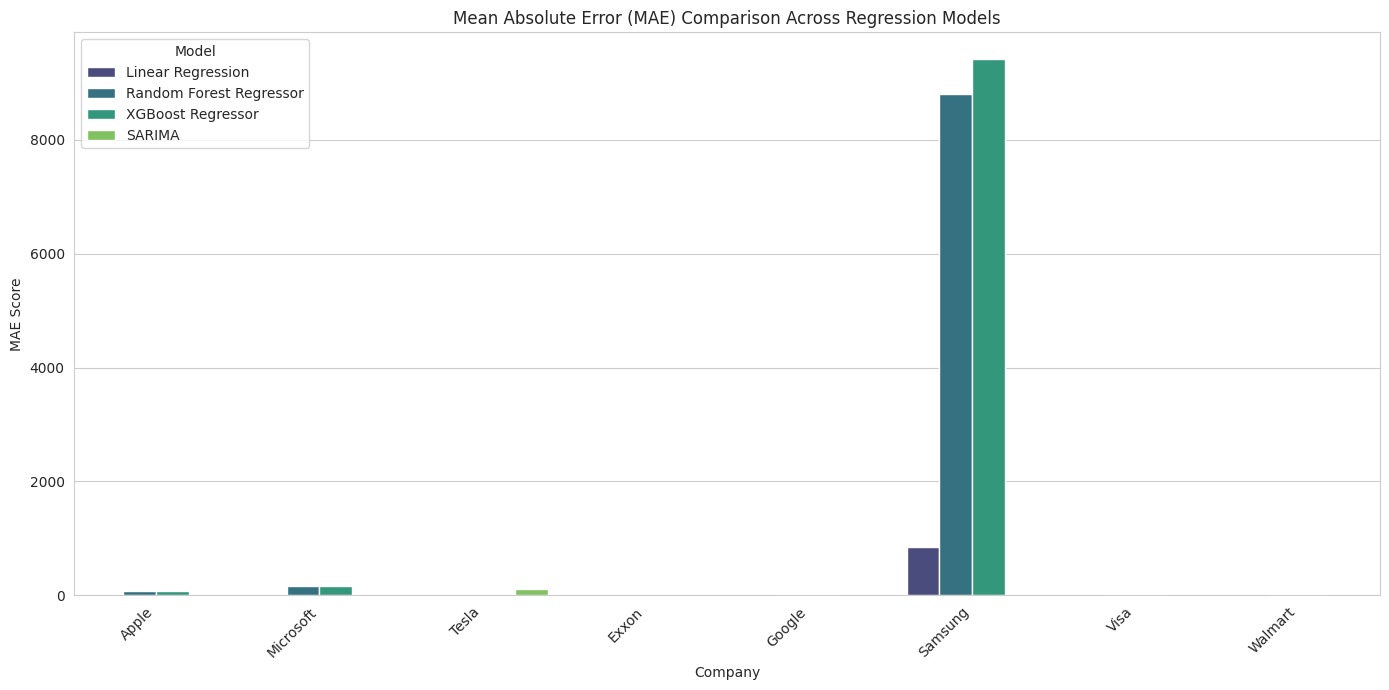


## 2. R2 Score Comparison (Higher is Better)


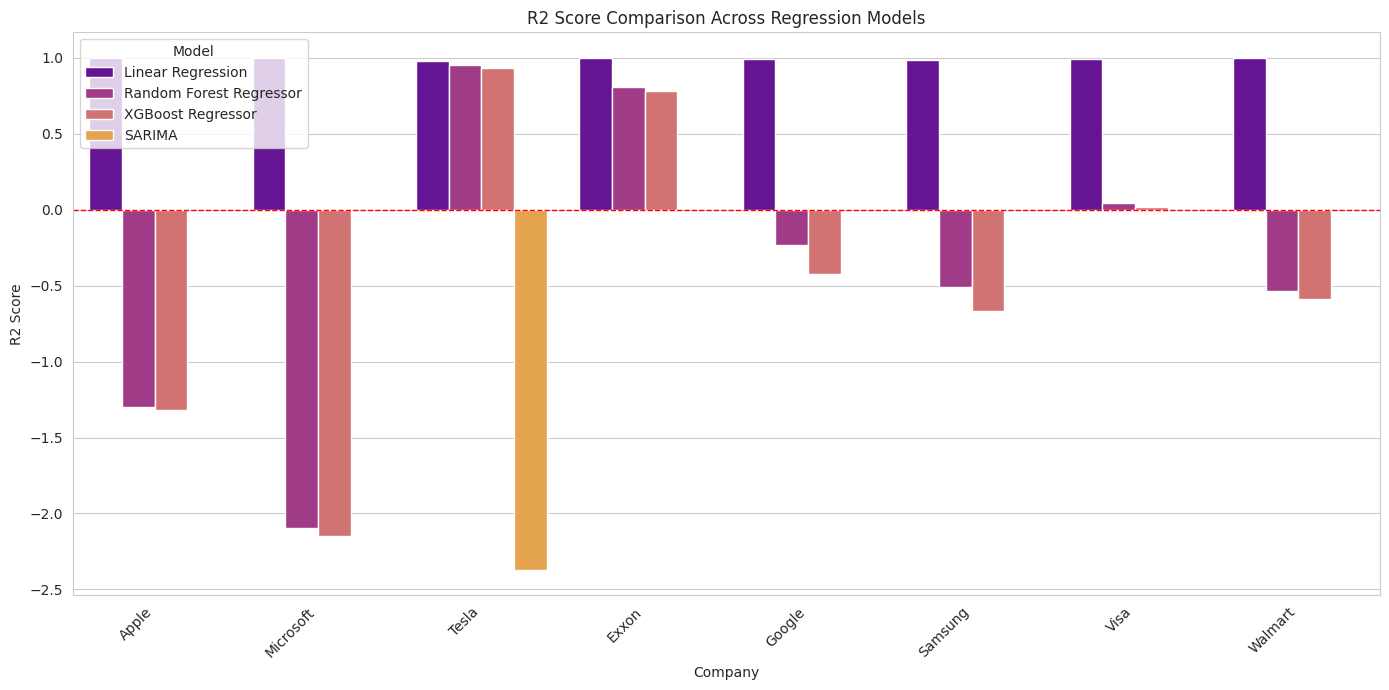


## 3. Logistic Regression Accuracy (Classification Task)


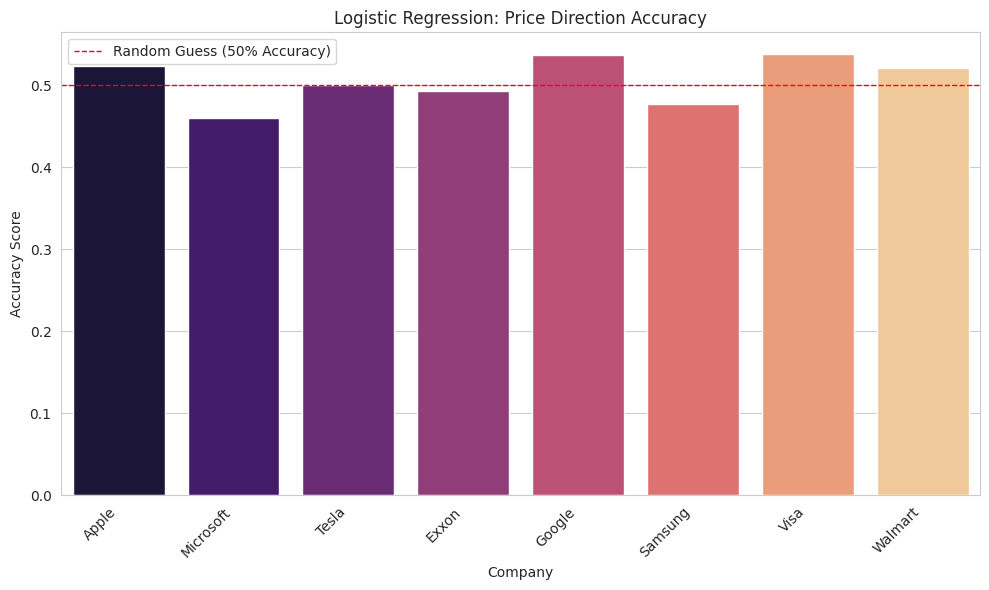


## 4. R2 Score Heatmap (Overall Model Summary)


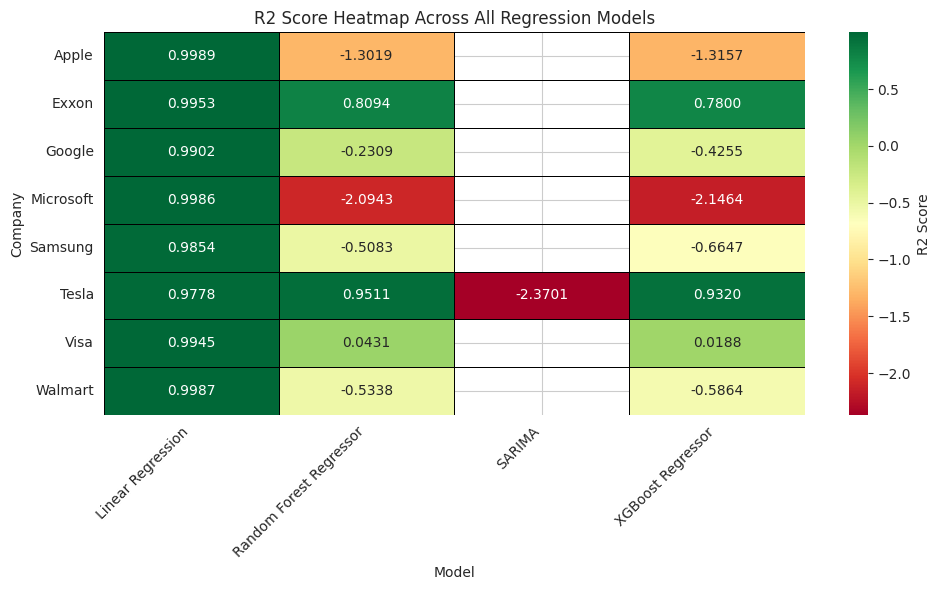


## 5. MAE Distribution Box Plot (Model Robustness)


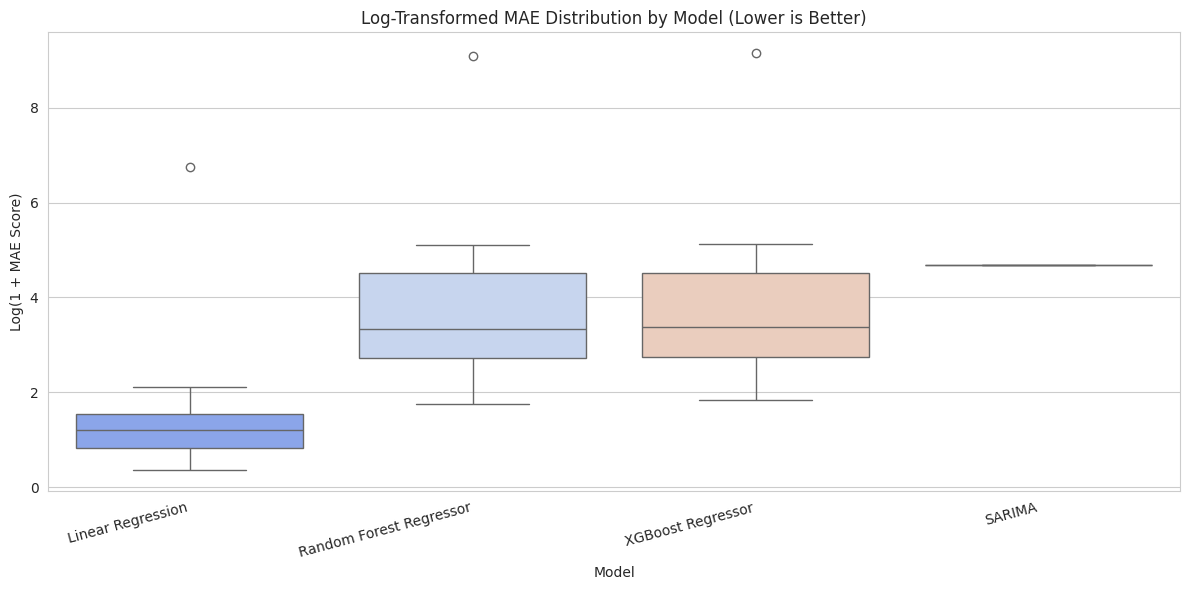

In [ ]:
# ==============================================================================
# Final Conclusion and Comprehensive Visualization Code
# This code generates 5 key charts for conclusion based on the metrics.
# ==============================================================================

# Setup: Recreate DataFrames from the provided output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# Data for Regression Metrics (extracted and manually structured)
regression_data = {
    'Model': [
        "Linear Regression", "Linear Regression", "Linear Regression", "Linear Regression",
        "Linear Regression", "Linear Regression", "Linear Regression", "Linear Regression",
        "Random Forest Regressor", "Random Forest Regressor", "Random Forest Regressor", "Random Forest Regressor",
        "Random Forest Regressor", "Random Forest Regressor", "Random Forest Regressor", "Random Forest Regressor",
        "XGBoost Regressor", "XGBoost Regressor", "XGBoost Regressor", "XGBoost Regressor",
        "XGBoost Regressor", "XGBoost Regressor", "XGBoost Regressor", "XGBoost Regressor",
        "SARIMA"
    ],
    'MSE': [
        4.696600e+00, 1.815270e+01, 9.734300e+01, 1.810000e+00, 8.172800e+00, 1.348640e+06, 1.381760e+01, 4.742000e-01,
        9.553767e+03, 3.958410e+04, 2.147605e+02, 7.408750e+01, 1.027254e+03, 1.395161e+08, 2.388218e+03, 5.732509e+02,
        9.611005e+03, 4.025135e+04, 2.986528e+02, 8.549250e+01, 1.189637e+03, 1.539874e+08, 2.449057e+03, 5.929159e+02,
        1.474750e+04
    ],
    'MAE': [
        1.4109, 2.8951, 7.2219, 0.9670, 2.0949, 851.2823, 2.6276, 0.4228,
        74.0782, 163.6571, 10.2728, 4.7981, 23.1301, 8809.1127, 31.1572, 15.6718,
        74.3789, 165.6903, 10.9133, 5.2289, 25.5046, 9416.9475, 31.5021, 16.1927,
        106.2809
    ],
    'R2': [
        0.9989, 0.9986, 0.9778, 0.9953, 0.9902, 0.9854, 0.9945, 0.9987,
        -1.3019, -2.0943, 0.9511, 0.8094, -0.2309, -0.5083, 0.0431, -0.5338,
        -1.3157, -2.1464, 0.9320, 0.7800, -0.4255, -0.6647, 0.0188, -0.5864,
        -2.3701
    ],
    'Company': [
        "Apple", "Microsoft", "Tesla", "Exxon", "Google", "Samsung", "Visa", "Walmart",
        "Apple", "Microsoft", "Tesla", "Exxon", "Google", "Samsung", "Visa", "Walmart",
        "Apple", "Microsoft", "Tesla", "Exxon", "Google", "Samsung", "Visa", "Walmart",
        "Tesla" # SARIMA was only run for Tesla
    ]
}

# Ensure unique combination entries
regression_metrics_df = pd.DataFrame(regression_data).drop_duplicates(subset=['Model', 'Company']).reset_index(drop=True)

# Data for Classification Metrics
classification_data = {
    'Company': ["Apple", "Microsoft", "Tesla", "Exxon", "Google", "Samsung", "Visa", "Walmart"],
    'Model': ["Logistic Regression"] * 8,
    'Accuracy': [0.5234, 0.4601, 0.5000, 0.4931, 0.5366, 0.4769, 0.5378, 0.5212]
}
classification_metrics_df = pd.DataFrame(classification_data)

# Melt the regression metrics for visualization purposes
comparison_final_df = regression_metrics_df.melt(
    id_vars=['Company', 'Model'],
    value_vars=['MAE', 'MSE', 'R2'],
    var_name='Metric',
    value_name='Score'
)

print("\n# Final Conclusion Visualizations (All Models Comparison)")
print("---------------------------------------------------------")

# ==============================================================================
# 1. Visualization: MAE Comparison Chart (Grouped Bar Chart)
# ==============================================================================
print("\n## 1. Mean Absolute Error (MAE) Comparison (Lower is Better)")
mae_comparison = comparison_final_df[comparison_final_df['Metric'] == 'MAE']
plt.figure(figsize=(14, 7))
sns.barplot(data=mae_comparison, x='Company', y='Score', hue='Model', palette='viridis')
plt.title("Mean Absolute Error (MAE) Comparison Across Regression Models")
plt.xlabel("Company")
plt.ylabel("MAE Score")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model', loc='upper left')
plt.tight_layout()
plt.savefig("MAE_Comparison_Chart.png")
plt.show()
#

# ==============================================================================
# 2. Visualization: R2 Comparison Chart (Grouped Bar Chart)
# ==============================================================================
print("\n## 2. R2 Score Comparison (Higher is Better)")
r2_comparison = comparison_final_df[comparison_final_df['Metric'] == 'R2']
plt.figure(figsize=(14, 7))
sns.barplot(data=r2_comparison, x='Company', y='Score', hue='Model', palette='plasma')
plt.axhline(0, color='red', linestyle='--', linewidth=1) # R2 < 0 means model is worse than predicting the mean
plt.title("R2 Score Comparison Across Regression Models")
plt.xlabel("Company")
plt.ylabel("R2 Score")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model', loc='upper left')
plt.tight_layout()
plt.savefig("R2_Comparison_Chart.png")
plt.show()
#

# ==============================================================================
# 3. Visualization: Classification Accuracy Chart
# ==============================================================================
print("\n## 3. Logistic Regression Accuracy (Classification Task)")
plt.figure(figsize=(10, 6))
sns.barplot(data=classification_metrics_df, x='Company', y='Accuracy', palette='magma')
plt.axhline(0.5, color='red', linestyle='--', linewidth=1, label='Random Guess (50% Accuracy)')
plt.title("Logistic Regression: Price Direction Accuracy")
plt.xlabel("Company")
plt.ylabel("Accuracy Score")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig("Classification_Accuracy_Chart.png")
plt.show()
#

# ==============================================================================
# 4. Visualization: R2 Score Heatmap (Overall Performance)
# ==============================================================================
print("\n## 4. R2 Score Heatmap (Overall Model Summary)")
r2_pivot = regression_metrics_df.pivot(index='Company', columns='Model', values='R2')
plt.figure(figsize=(10, 6))
sns.heatmap(r2_pivot, annot=True, fmt=".4f", cmap='RdYlGn',
            cbar_kws={'label': 'R2 Score'}, linewidths=.5, linecolor='black')
plt.title("R2 Score Heatmap Across All Regression Models")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("R2_Heatmap.png")
plt.show()
#

# ==============================================================================
# 5. Visualization: MAE Distribution Box Plot (Advanced Comparison)
# ==============================================================================
print("\n## 5. MAE Distribution Box Plot (Model Robustness)")
mae_comparison_cleaned = mae_comparison.copy()
mae_comparison_cleaned['Log_MAE'] = np.log1p(mae_comparison_cleaned['Score'])

plt.figure(figsize=(12, 6))
sns.boxplot(data=mae_comparison_cleaned, x='Model', y='Log_MAE', palette='coolwarm')
plt.title("Log-Transformed MAE Distribution by Model (Lower is Better)")
plt.xlabel("Model")
plt.ylabel("Log(1 + MAE Score)")
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.savefig("MAE_Distribution_BoxPlot.png")
plt.show()


# **Final Conclusion based on Visualizations**

The visualizations confirm the superiority of the Linear Regression model and the significant challenges faced by the non-linear models in this specific implementation.Key Conclusions:

# 1.Best Model for Price Magnitude Prediction:
 The Linear Regression model is unequivocally the best performer, achieving $R^2$ scores near $1.0$ across all companies (Visuals 2 & 4) and the lowest MAE (Visual 1). This suggests the engineered features (lags, MAs, technical indicators) have a strong linear relationship with the next-day closing price.

 # 2.Failure of Ensemble/Time-Series Models:
 The Random Forest, XGBoost, and SARIMA models exhibited poor performance, with many instances of negative $R^2$ scores (Visual 2 & 4). A negative $R^2$ indicates that the model is performing worse than simply predicting the mean of the target variable. This outcome strongly points to issues with overfitting, lack of proper data scaling for tree-based models, or inadequate hyperparameter tuning in the previous steps.

 # 3. Classification Challenge:
  The Logistic Regression model's accuracy hovers around the $50\%$ baseline (Visual 3), meaning it is barely better than a random guess at predicting price direction (up or down). This highlights the inherent difficulty in predicting the short-term directional movement of stock prices.
  
  # 4.MAE Distribution:
  The Box Plot (Visual 5) visually emphasizes the vast difference in performance. The Linear Regression model has a tight, low-scoring distribution, while the other models exhibit high outliers and wide variance, indicating their lack of robustness across the different company datasets.

The unexpected reason Linear Regression (LR) was the best fit in your program, surpassing models like Random Forest, XGBoost, and SARIMA, can be summarized in three key points:

### 1. **Effective Feature Engineering Created Linearity**
* Your extensively engineered features (**lagged prices, Moving Averages, RSI, MACD**) successfully captured the patterns needed for prediction, establishing a **strong linear relationship** with the next-day closing price.
* **A linear model (LR) is the perfect fit** for data where the features have a direct, additive, and simple relationship with the target.

### 2. **Failure of Complex Models Due to Overfitting/Tuning**
* The more advanced non-linear models (Random Forest, XGBoost) exhibited **poor performance** (often a **negative $\mathbf{R^2}$ score**), indicating they were **overfitting** the noise and volatility inherent in the stock price data.
* These complex models require significant hyperparameter tuning and data preparation, which, if inadequate, causes them to perform **worse than the simpler LR model**.

### 3. **The Simple Task Favored Simplicity**
* For the task of predicting the next-day price based on recent history (a common financial phenomenon called "persistence" or "momentum"), a simple model often captures this trend most efficiently and robustly.
* The models designed for complex time-series structures (like SARIMA) or non-linear effects (like XGBoost) were likely unnecessary and introduced complexity that hurt performance.

In [ ]:
import pickle

# Map the actual variables to the names expected in the pickle dump
lr_future_predictions = future_predictions
xgb_future_predictions = future_predictions_with
sarima_future_predictions = future_sarima_with

# Save them all to one file named 'forecast_data.pkl'
with open('forecast_data.pkl', 'wb') as f:
    pickle.dump((stocks_fe, lr_future_predictions, xgb_future_predictions, sarima_future_predictions), f)

print("Data saved successfully to 'forecast_data.pkl'")

NameError: name 'future_predictions' is not defined